#2팀 코드 취합
- enter_lesson_page의 행 개수가 너무 많기 때문에 사용자 행동 패턴 확인 코드에서는 출력 장면을 생략, 텍스트로 대체

## 목차
1. 개발환경 세팅
2. 데이터 결측치 확인 및 전처리
3. 유치단계 (start_free_trial ~ complete_subscription) 분석
4. 유지단계 (complete_subscription ~ renew/resubscribe subscription) 분석


# 1. 개발환경 세팅 - 헤더 모음, 폰트 설치, 드라이브 연결

In [ ]:
# 라이브러리
import os
import gc
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from datetime import datetime
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from dateutil.relativedelta import relativedelta
from google.colab import files
import matplotlib.pyplot as plt

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (9,019 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126675 files and dire

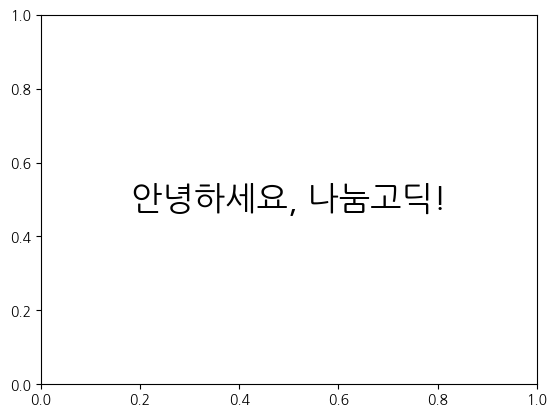

In [ ]:
### 개발환경 세팅하기

# ▶ 한글 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 나눔고딕 폰트를 설치합니다.
!apt-get install -y fonts-nanum
!fc-cache -fv
# 설치된 나눔고딕 폰트를 matplotlib에 등록합니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'NanumGothic'
# 폰트가 잘 설정되었는지 테스트합니다.
plt.text(0.5, 0.5, '안녕하세요, 나눔고딕!', ha='center', va='center', size=24)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#2. 데이터 결측치 확인 및 전처리

## 2-1 데이터 결측치 확인

### 데이터 로드

In [ ]:
TABLE_SPECS = {
  "enter_main_page" : "enter.main_page.csv",
  "enter_signup_page" : "enter.signup_page.csv",
  "complete_signup" : "complete.signup.csv",
  "enter_content_page" : "enter.content_page.csv",
  "click_start_content_button": "click.content_page_start_content_button.csv",
  "click_content_more_review_button": "click.content_page_more_review_button.csv",
  "enter_payment_page" : "enter.payment_page.csv",
  "complete_subscription" : "complete_subscription.csv",
  "renew_subscription" : "renew_subscription.csv",
  "resubscribe_subscription" : "resubscribe_subscription.csv",
  "start_free_trial" : "start.free_trial.csv",
  "start_content" : "start.content.flagged.csv",
  #"enter_lesson_page" : "enter.lesson_page.csv"
  "complete_lesson" : "complete.lesson.csv",
  "click_lesson_question_box": "click.lesson_page_related_question_box.csv",
  "end_content" : "end.content.flagged.csv",
  "click_cancel_plan_button": "click.cancel_plan_button.csv",
}

BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/중급 프로젝트/Cleaned"  # 경로만 수정

BATCH_SIZE = 3  # 섹션 크기(3개씩)

### 데이터 연결 확인 및 행 개수, 컬럼 개수 출력

In [ ]:
def load_olist(base_dir, specs=TABLE_SPECS):
  base = Path(base_dir)
  return {name: pd.read_csv(base / fname) for name, fname in specs.items()}

dfs = load_olist(BASE_DIR)
for i, (k, v) in enumerate(dfs.items()):
  print(f"{i+1}. {k} : {v.shape}")

/tmp/ipython-input-512025769.py:3: DtypeWarning: Columns (0,2,4,5,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  return {name: pd.read_csv(base / fname) for name, fname in specs.items()}


1. enter_main_page : (2132794, 12)
2. enter_signup_page : (596790, 12)
3. complete_signup : (145133, 13)
4. enter_content_page : (1914079, 13)
5. click_start_content_button : (165502, 15)
6. click_content_more_review_button : (93961, 13)
7. enter_payment_page : (136080, 12)
8. complete_subscription : (13881, 16)
9. renew_subscription : (15684, 16)
10. resubscribe_subscription : (758, 16)
11. start_free_trial : (16310, 14)
12. start_content : (124798, 15)
13. complete_lesson : (5396773, 14)
14. click_lesson_question_box : (1379052, 15)
15. end_content : (120167, 14)
16. click_cancel_plan_button : (17840, 12)


### 데이터 유틸 함수 정의 및 컬럼별 결측치 개수 출력

In [ ]:
# 파일 존재 여부 체크 후 로드
def load_subset(base_dir: str, specs: dict, keys: list) -> dict:
  base = Path(base_dir)
  dfs = {}
  for k in keys:
    fpath = base / specs[k]
    if not fpath.exists():
      print(f"[SKIP] 파일 없음: {fpath}")
      continue
    df = pd.read_csv(fpath)
    dfs[k] = df
  return dfs


#각 컬럼별 결측치 개수/비율 요약 테이블 반환
def summarize_missing(df: pd.DataFrame) -> pd.DataFrame:
  total = len(df)
  rows = []
  for col in df.columns:
    n_miss = df[col].isna().sum()
    if n_miss > 0:
      rows.append({
        "column": col,
        "dtype": str(df[col].dtype),
        "missing": int(n_miss),
        "missing_pct": round(100.0 * n_miss / total, 2)
      })
  if not rows:
    return pd.DataFrame(columns=["column", "dtype", "missing", "missing_pct"])
  out = pd.DataFrame(rows).sort_values(["missing_pct", "missing"], ascending=False)
  return out


#수치형 컬럼에 대해 IQR 방식 이상치 요약 테이블 반환 (IQR 기반)
def summarize_outliers_iqr(df: pd.DataFrame) -> pd.DataFrame:
  num_df = df.select_dtypes(include=[np.number])
  if num_df.shape[1] == 0:
    return pd.DataFrame(columns=[
      "column","q1","q3","iqr","lower","upper",
      "low_count","high_count","total_outliers","outlier_pct","min","max"
    ])

  total = len(num_df)
  rows = []
  for col in num_df.columns:
    s = num_df[col].replace([np.inf, -np.inf], np.nan).dropna()
    if s.empty:
      continue

    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1

    # 분산이 거의 없는 컬럼은 이상치 없음 처리
    if iqr == 0 or np.isnan(iqr):
      low_count = 0
      high_count = 0
      total_out = 0
      lower = q1
      upper = q3
    else:
      lower = q1 - 1.5 * iqr
      upper = q3 + 1.5 * iqr
      low_count = (num_df[col] < lower).sum()
      high_count = (num_df[col] > upper).sum()
      total_out = int(low_count + high_count)

    if total_out > 0:
      rows.append({
        "column": col,
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "lower": lower,
        "upper": upper,
        "low_count": int(low_count),
        "high_count": int(high_count),
        "total_outliers": total_out,
        "outlier_pct": round(100.0 * total_out / total, 3),
        "min": s.min(),
        "max": s.max()
      })

  if not rows:
    return pd.DataFrame(columns=[
      "column","q1","q3","iqr","lower","upper",
      "low_count","high_count","total_outliers","outlier_pct","min","max"
    ])

  out = pd.DataFrame(rows).sort_values(["outlier_pct", "total_outliers"], ascending=False)
  return out

#단일 파일에 대한 결측치/이상치 요약을 프린트합니다.
def print_report(index: int, name: str, df: pd.DataFrame) -> None:
  print("-" * 70)
  print(f"{index}번째 파일 : {name}  shape={df.shape}")
  print("[MISSING]")
  miss = summarize_missing(df)
  if miss.empty:
    print("  결측치 없음")
  else:
    print(miss.to_string(index=False))

  print("\n[OUTLIERS - IQR (numeric columns only)]")
  out = summarize_outliers_iqr(df)
  if out.empty:
    print("  이상치 없음")
  else:
    to_show = out.head(5)
    print(to_show.to_string(index=False))

In [ ]:
all_keys = [k for k, v in TABLE_SPECS.items() if v.lower().endswith(".csv")]

for i in range(0, len(all_keys), BATCH_SIZE):
  section_keys = all_keys[i:i + BATCH_SIZE]
  print("\n" + "=" * 70)
  print(f"[SECTION {i//BATCH_SIZE + 1}] Keys: {section_keys}")

  # 3개 로드
  dfs = load_subset(BASE_DIR, TABLE_SPECS, section_keys)

  # 파일별 리포트 출력
  for j, (k, df) in enumerate(dfs.items()):
    print_report(i+j+1, k, df)


[SECTION 1] Keys: ['enter_main_page', 'enter_signup_page', 'complete_signup']
----------------------------------------------------------------------
1번째 파일 : enter_main_page  shape=(2132794, 12)
[MISSING]
           column   dtype  missing  missing_pct
   device_carrier float64  2132794       100.00
          user_id  object  1610533        75.51
      device_type  object    60014         2.81
             city  object    56976         2.67
       os_version  object    13868         0.65
    device_family  object     2811         0.13
          os_name  object     2304         0.11
client_event_time  object     2090         0.10
          country  object     1867         0.09

[OUTLIERS - IQR (numeric columns only)]
  이상치 없음
----------------------------------------------------------------------
2번째 파일 : enter_signup_page  shape=(596790, 12)
[MISSING]
           column   dtype  missing  missing_pct
   device_carrier float64   596790       100.00
          user_id float64   596790      

/tmp/ipython-input-701766819.py:10: DtypeWarning: Columns (0,2,4,5,7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fpath)


----------------------------------------------------------------------
13번째 파일 : complete_lesson  shape=(5396773, 14)
[MISSING]
           column   dtype  missing  missing_pct
   device_carrier float64  5396773       100.00
             city  object   189531         3.51
          country  object   148271         2.75
      device_type  object    80747         1.50
       os_version  object    54005         1.00
          os_name  object    53220         0.99
    device_family  object    52964         0.98
         language  object    52943         0.98
         platform  object    52943         0.98
client_event_time  object     5214         0.10

[OUTLIERS - IQR (numeric columns only)]
  이상치 없음
----------------------------------------------------------------------
14번째 파일 : click_lesson_question_box  shape=(1379052, 15)
[MISSING]
           column   dtype  missing  missing_pct
   device_carrier float64  1379052       100.00
       content.id  object   554289        40.19
      questi

###테이블 별 연/ 연_월 별 유효값 개수, 결측치 개수 카운트

In [ ]:
TS_COL_NAME = "client_event_time"

# 혼합 타입 경고 제거 및 사용자 정의 결측 판정을 위한 토큰
MISSING_TOKENS = {"", "na", "n/a", "null", "none", "nan"}

# 출력이 너무 길면 제한(행 수). 전체 출력은 None
PRINT_LIMIT = None

if "is_missing_series" not in globals():
  def is_missing_series(s: pd.Series) -> pd.Series:
    ss = s.astype("string")
    return ss.isna() | ss.str.strip().str.lower().isin(MISSING_TOKENS)

def _pick_ts_col(df: pd.DataFrame, preferred: str | None = None) -> str | None:
  if preferred and preferred in df.columns:
    return preferred
  candidates = [
    "client_event_time", "event_time", "server_time", "timestamp",
    "event_timestamp", "time", "datetime", "created_at", "ts"
  ]
  for c in candidates:
    if c in df.columns:
      return c
  return None

if "build_valid_null_tables" not in globals():
  from typing import Tuple
  def build_valid_null_tables(period_series: pd.Series, period_index: pd.Index) -> "Tuple[pd.DataFrame, pd.DataFrame]":
    valid_df = pd.DataFrame(0, index=period_index, columns=df.columns, dtype="int64")
    null_df  = pd.DataFrame(0, index=period_index, columns=df.columns, dtype="int64")
    valid_ts = period_series.notna()
    for col in df.columns:
      miss_mask = is_missing_series(df[col])
      non_miss_mask = ~miss_mask
      valid_counts = (non_miss_mask & valid_ts).groupby(period_series).sum().astype("int64")
      null_counts  = (miss_mask     & valid_ts).groupby(period_series).sum().astype("int64")
      valid_df[col] = valid_counts.reindex(period_index, fill_value=0)
      null_df[col]  = null_counts.reindex(period_index, fill_value=0)
    return valid_df, null_df

def _print_table(title: str, table: pd.DataFrame):
  print("\n" + "-" * 120)
  print(title)
  if PRINT_LIMIT is None:
    print(table.to_string())
  else:
    print(table.head(PRINT_LIMIT).to_string())

def process_one_file(index: int, key: str, fname: str):
  fpath = Path(BASE_DIR) / fname
  if not fpath.exists():
    print(f"[SKIP] 파일 없음: {fpath}")
    return

  # 혼합 타입 경고 제거: 모두 문자열로 읽고, 기본 NA 인식 끔
  df_local = pd.read_csv(
    fpath,
    dtype=str,
    na_filter=False,
    low_memory=False
  )

  ts_col = TS_COL_NAME
  if ts_col is None:
    print(f"[WARN] 타임스탬프 컬럼을 찾을 수 없습니다: {key} ({fname})")
    return

  bak = globals().get("df", None)
  globals()["df"] = df_local

  try:
    ts_valid_mask = ~is_missing_series(df_local[ts_col])
    ts_parsed = pd.to_datetime(df_local.loc[ts_valid_mask, ts_col], errors="coerce")
    ts_full = pd.Series(pd.NaT, index=df_local.index, name=ts_col)
    ts_full.loc[ts_valid_mask] = ts_parsed

    year_full = pd.Series(np.nan, index=df_local.index, dtype="object")
    year_full.loc[ts_full.notna()] = ts_full.loc[ts_full.notna()].dt.year

    ym_full = pd.Series(np.nan, index=df_local.index, dtype="object")
    ym_full.loc[ts_full.notna()] = ts_full.loc[ts_full.notna()].dt.to_period("M").astype(str)

    years = pd.Index(sorted(pd.unique(year_full.dropna())), name="year")
    months = pd.Index(sorted(pd.unique(ym_full.dropna())), name="year_month")

    valid_by_year, null_by_year   = build_valid_null_tables(year_full, years)
    valid_by_month, null_by_month = build_valid_null_tables(ym_full, months)

    print("\n" + "=" * 120)
    print(f"{index}번째 파일 : {key}  ({fname})  rows={len(df_local)}, cols={df_local.shape[1]}")
    print(f"[TS]   column='{ts_col}', timestamp_null_rows={int(ts_full.isna().sum())}")

    _print_table("유효 데이터 개수(연 단위) (rows: year, cols: columns)", valid_by_year)
    _print_table("NULL 데이터 개수(연 단위) (rows: year, cols: columns)", null_by_year)
    _print_table("유효 데이터 개수(연_월 단위) (rows: YYYY-MM, cols: columns)", valid_by_month)
    _print_table("NULL 데이터 개수(연_월 단위) (rows: YYYY-MM, cols: columns)", null_by_month)

  finally:
    # 전역 df 복원
    if bak is None:
      del globals()["df"]
    else:
      globals()["df"] = bak
    del df_local
    gc.collect()

In [ ]:
keys_to_run = list(TABLE_SPECS.keys())

for i, k in enumerate(keys_to_run):
  process_one_file(i+1, k, TABLE_SPECS[k])


1번째 파일 : enter_main_page  (enter.main_page.csv)  rows=2132794, cols=12
[TS]   column='client_event_time', timestamp_null_rows=2090

------------------------------------------------------------------------------------------------------------------------
유효 데이터 개수(연 단위) (rows: year, cols: columns)
         city  client_event_time  country  device_carrier  device_family  device_type  event_type  language  os_name  os_version  platform  user_id
year                                                                                                                                               
2021       37                 38       38               0             38           38          38        38       38          38        38       13
2022  1034312            1061298  1060474               0        1059777      1057321     1061298   1061298  1059880     1056359   1061298   420838
2023  1039435            1069368  1068328               0        1068082      1013379     1069368   1069368  1

## 2-2 데이터 전처리

###데이터 전처리 기준

### 전체 테이블 공통 기준

- 시간 처리 X UTC로 유지
- 완전 중복(모든 컬럼이 동일)의 경우 1건만 유지
    - 다른 컬럼은 모두 동일하고, client_event_time이 10초 이내로 발생한 다중 이벤트일 경우 가장 늦게 발생한 로그 1건만 유지
- 1970년대 타임스탬프는 드랍

### 개별 테이블 기준

- enter_main_page
    - 시작 **2,133,548** → 드랍 **754**(NaT/1970s **10** + 완전중복 **744**) → 최종 **2,132,794** (↓**0.04%**)
    - user_id 결측 드랍
- enter.signup_page
    - 시작 **596,829** → 드랍 **39**(완전중복 **39**) → 최종 **596,790** (↓**0.01%**)
- complete_signup
    - 시작 **145,133** → 드랍 **0** → 최종 **145,133** (↓**0.00%)**
    - user_id 중복일 경우 최초 1건만 유지(드랍 0건)
- enter.content_page
    - 시작 **1,914,257** → 드랍 **178**(완전중복 **178**) → 최종 **1,914,079** (↓**0.01%**)
    - 근접 중복 제거 미적용 (enter 로그가 다른 테이블들과 같이 봐야하는데, 불안정해서 보수적으로 접근, 우선은 유지하기로 결정)
- click.content_page_start_content_button
    - 시작 **172,911** → 드랍 **7,409**(완전중복 **378** + 10초 근접중복 **7,031**) → 최종 **165,502** (↓**4.28%**)
- click_content_page_more_review_button
    - 시작 **93,962** → 드랍 **1**(완전중복 **1**) → 최종 **93,961** (↓**0.00%)**
- enter.payment_page
    - 시작 **165,061** → 드랍 **28,981**(완전중복 **21** + 10초 근접중복 **28,960**) → 최종 **136,080** (↓**17.56%**)
- start_free_trial
    - 시작 **30,621** → 드랍 **14,311**(user별 **최초 1건 유지**) → 최종 **16,310** (↓**46.74%**)
    - 중복 사용자(≥2건) **5,914명 (꽤 많음)**
    - user_id가 중복될 경우 최초 로그만 남기고 나머지는 드랍
- click.lesson_page-related_question_box
    - 시작 **1,379,136** → 드랍 **84**(완전중복 **84**) → 최종 **1,379,052** (↓**0.01%**)
    - lesson_id 결측치 처리 X
- click.cancel_plan_button
    - 시작 **17,895** → 드랍 **55**(10초 근접중복 **55**) → 최종 **17,840** (↓**0.31%)**
    - 근접 중복이 발생한 경우 가장 나중에 발생한 것만 유지(10초)
- start.content
    - 시작 124,917 → 드랍 119(10초 근접중복) → **최종 124,798** (↓0.095%)
- end.content
    - 시작 120,582 → 드랍 2(완전중복) + 413(10초 근접중복) → **최종 120,167** (↓0.34%)
- enter.lesson_page
    - 시작 21,029,707 → 드랍 674(완전중복) + 4,888,278(10초 근접중복, 버킷 처리) → **최종 16,140,755** (↓약 **23.25%**)
- complete.lesson
    - 시작 5,405,069 → 드랍 5(완전중복) + 8291(5분 근접중복) → 최종 5,396,773(↓**0.153%**)
    - 5분 내 근접중복은 가장 오래된 로그 1건만 유지
- complete.subscription
  - 동일아이디로 첫 결제가 동일 시각에 여러번 나타난 행에 대해 마지막 시점의 행만 남기고 삭제
- renew.subscription
  - renew 에서 두개 이상의 데이터가 20일 이내로 발생할 경우 해당 내용은, 첫 이벤트기준의 시각으로 하되, 금액정보는 마지막 시점의 정보로 대체하여 처리(재결재 이슈)
  - renew와 complete가 1:1로 데이터가 동일한 중복행들이 존재하고 결제데이터도 동일한 것을 확인하여, renew 만 삭제 처리
- resubscribe.subscription
  - 직접 파일로 확인했으며, 해당 내용 확인결과, 동일 아이디가 있는 데이터일 경우 그 텀이 길어, 구독취소 후 재구독을 반복 한 것으로 확인되어 처리 불필요.
  - renew와 비교 처리
파일 확인결과, 24행이 겹치고, 그 모든 내용이 동일하여 resubscribe 데이터 삭제
  -complete와 비교처리.
    - 파일 확인결과, 9행이 겹치고, 그 모든 내용이 동일하여 resubscribe 데이터 삭제

### 교차 이벤트 순서 점검 (시간 역행 로그 드랍)

- 역전 정의 : end_only, end 먼저 start 나중, start, end가 동일 user_id, 동일 content_id 중복
- start_content → end_content
    - user_id, content_id가 매칭된 건수 192989
    - 역전 발생 그룹 68414(35.45%)
    - 역전 이벤트 수 : 68704
    - 역전 이벤트 수별 사용자 유니크값 (전체 : 17278명)
        - 2개 이상 5개 미만 컨텐츠에서 역전 : 13219명
        - 5개 이상 : 4463명
        - 상위는 40개~60개도 발생
    - start 없이 end만 관측된 값 : 99.89%(전체 X 역전된 그룹에서만) - 68340 그룹
    - end 먼저 발생하고 start가 발생한 이벤트 : 0.06% - 42그룹
    - start/end가 동일 user_id, 동일 content_id에서 여러 번 발생한 이벤트 : 0.49% - 336그룹
    - 역전 이후 동일 컨텐츠 시청 이벤트는 거의 발생하지 않음. 있어도 수 개월 뒤에 등장하는 매우 드문 케이스이고, 전체적으로 start가 유실되거나 미수집된 것으로 보는 게 맞을 것 같음
    - 플래그만 추가하는 것으로 관리 (user_id, content_id, client_event_time 기반)
    
    ### 플래그 기준
    
    - 매칭 : user_id, content_id가 동일
    - 시간 역전 : 매칭이 되었을 때 end가 start보다 빠르게 발생한 경우
        1. 매칭되지 않았고, start_content 에만 존재할 때(매칭X) -> start_only
        2. 매칭되지 않았고, end_content 에만 존재할 때 -> end_only
        3. 매칭되었고, end의 이벤트 타임이 start의 이벤트 타임보다 빠를 때 -> inversion
        4. 매칭되었고, 동일 user_id, content_id에 대해 매칭이 여러 번 발생했을 때(2번 이상) -> duplication
        5. 매칭되었고, 시간이 정상이며 그 기간이 7일 이내일 때 start에서는 -> has_next_end_7d
        6. 매칭되었고, 시간이 정상이며 그 기간이 7일 이내일 때 end에서는 -> has_prior_start_7d
        7. 매칭되었고, 시간이 정상이며 그 기간이 7일보다 길 때 start에서는 -> matched_over_7d_start
        8. 매칭되었고, 시간이 정상이며 그 기간이 7일보다 길 때 end에서는 -> matched_over_7d_end
        9. 매칭되지 않았고, 이전 조건들을 다 부합하지 않을 때 -> unmatched
        10. 매칭되었고, 이전 조건들을 다 부합하지 않을 때 -> matched

###데이터 전처리 코드
- 결제 관련 테이블 (complete.subscription, renew.subscription, resubscribe.subscription)을 제외하면 모두 pycharm에서 진행.
- 데이터 전처리 코드들은 전부 데이터 처리 후 저장 목적으로 작성되었기 때문에 출력 X.(파일의 크기가 너무 크기 때문에 실행 시간이 5시간 이상 소요)
- 데이터 전처리 기준은 위와 같으며, 아래는 각각 데이터 전처리, 시간 역행 로그 드랍, 플래그 생성 순으로 작성됩니다.

### 결제, enter_lesson_page 제외한 테이블들 전처리

In [ ]:
import os, time, pandas as pd, numpy as np

BASE_DIR = os.getcwd()
OUT_DIR = os.path.join(BASE_DIR, "preprocess")
os.makedirs(OUT_DIR, exist_ok=True)

SKIP_IF_OUTPUT_EXISTS = True

TABLES = {
    "enter.main_page":                     os.path.join(BASE_DIR, "enter.main_page.csv"),
    "enter.signup_page":                   os.path.join(BASE_DIR, "enter.signup_page.csv"),
    "complete.signup":                     os.path.join(BASE_DIR, "complete.signup.csv"),
    "enter.content_page":                  os.path.join(BASE_DIR, "enter.content_page.csv"),
    "click.content_page_start_content_button": os.path.join(BASE_DIR, "click.content_page_start_content_button.csv"),
    "click.content_page_more_review_button":   os.path.join(BASE_DIR, "click.content_page_more_review_button.csv"),
    "enter.payment_page":                  os.path.join(BASE_DIR, "enter.payment_page.csv"),
    "start.free_trial":                    os.path.join(BASE_DIR, "start.free_trial.csv"),
    "click.lesson_page_related_question_box": os.path.join(BASE_DIR, "click.lesson_page_related_question_box.csv"),
    "click.cancel_plan_button":            os.path.join(BASE_DIR, "click.cancel_plan_button.csv")
}

def read_csv_utc(path):
    df = pd.read_csv(path, dtype=str, low_memory=False)
    df.columns = [c.strip() for c in df.columns]
    if "client_event_time" in df.columns:
        df["client_event_time"] = pd.to_datetime(df["client_event_time"], errors="coerce", utc=True)
    return df

def write_csv(df, in_path):
    out_path = os.path.join(OUT_DIR, os.path.basename(in_path))
    df.to_csv(out_path, index=False)
    return out_path

def drop_bad_times(df):
    if "client_event_time" not in df.columns: return df, 0, 0
    nat = int(df["client_event_time"].isna().sum())
    df = df.dropna(subset=["client_event_time"]).copy()
    y = df["client_event_time"].dt.year
    y70 = int(((y>=1970)&(y<=1979)).sum())
    df = df[~((y>=1970)&(y<=1979))].copy()
    return df, nat, y70

def drop_full_duplicates(df):
    before = len(df); out = df.drop_duplicates(keep="first")
    return out, before - len(out)

def keep_oldest_per_user(df, user_col="user_id"):
    if user_col not in df.columns or "client_event_time" not in df.columns: return df, 0, 0
    before = len(df)
    df = df.sort_values([user_col, "client_event_time"])
    vc = df[user_col].astype(str).value_counts()
    dup_users = int((vc>=2).sum())
    out = df.drop_duplicates(subset=[user_col], keep="first")
    return out, before - len(out), dup_users

def dedup_10s_keep_latest(df):
    if "client_event_time" not in df.columns: return df, 0
    key_cols = [c for c in df.columns if c!="client_event_time"]
    if not key_cols: return df, 0
    df = df.sort_values(key_cols+["client_event_time"]).copy()
    def _per_group(g):
        dif = g["client_event_time"].diff()
        cid = (dif.isna() | (dif>pd.Timedelta(seconds=10))).cumsum()
        keep_idx = g.groupby(cid, as_index=False).tail(1).index
        return g.loc[keep_idx]
    before = len(df)
    out = df.groupby(key_cols, dropna=False, group_keys=False).apply(_per_group).reset_index(drop=True)
    return out, before - len(out)

summary = []
t_all = time.time()

for tbl, path in TABLES.items():
    if not os.path.exists(path):
        print(f"\n[{tbl}] SKIP (파일 없음): {path}")
        continue
    out_path = os.path.join(OUT_DIR, os.path.basename(path))
    if SKIP_IF_OUTPUT_EXISTS and os.path.exists(out_path):
        print(f"\n[{tbl}] SKIP (이미 저장): {out_path}")
        continue

    t0 = time.time()
    df = read_csv_utc(path)
    print(f"\n[{tbl}] rows={len(df):,}")
    df, nat, y70 = drop_bad_times(df); print(f"  - drop_bad_times(NaT/1970s): {nat+y70:,}")
    df, d_full   = drop_full_duplicates(df); print(f"  - drop_full_duplicates: {d_full:,}")

    # 테이블별 정책
    if tbl=="enter.main_page":
        if "user_id" in df.columns:
            before=len(df); df=df[df["user_id"].astype(str).str.strip()!=""].reset_index(drop=True)
            print(f"  - drop_missing_user_id: {before-len(df):,}")

    elif tbl=="complete.signup":
        df, d_keep, dup_users = keep_oldest_per_user(df, "user_id")
        print(f"  - keep_oldest_per_user: {d_keep:,}")
        print(f"  - duplicate users (>=2): {dup_users:,}")

    elif tbl=="enter.content_page":
        # 근접중복 미적용 (의사결정)
        pass

    elif tbl in ["click.content_page_start_content_button", "enter.payment_page",
                 "click.cancel_plan_button", "complete.subscription", "renew.subscription", "resubscribe.subscription"]:
        df, d_near = dedup_10s_keep_latest(df)
        print(f"  - drop_near_dupes_10s_keep_latest: {d_near:,}")

    elif tbl=="click.content_page_more_review_button":
        pass  # 그대로 둠

    elif tbl=="start.free_trial":
        df, d_keep, dup_users = keep_oldest_per_user(df, "user_id")
        print(f"  - keep_oldest_per_user: {d_keep:,}")
        print(f"  - duplicate users (>=2): {dup_users:,}")

    elif tbl=="click.lesson_page_related_question_box":
        pass  # lesson_id 결측 미처리

    out = write_csv(df, path)
    summary.append({"table":tbl, "final_rows":len(df), "out":out})
    print(f"[{tbl}] saved → {out} (elapsed {time.time()-t0:.1f}s)")

sum_df = pd.DataFrame(summary).sort_values("table")
sum_path = os.path.join(OUT_DIR, "preprocess_stage1_summary.csv")
sum_df.to_csv(sum_path, index=False)
print("\n[Stage1 Summary]")
print(sum_df)
print(f"\nSaved summary to: {sum_path}")
print(f"Stage1 done in {time.time()-t_all:.1f}s")


### lesson, content 관련 페이지 전처리

In [ ]:
import os, time, gc, pandas as pd, numpy as np

BASE_DIR = os.getcwd()
OUT_DIR = os.path.join(BASE_DIR, "preprocess")
os.makedirs(OUT_DIR, exist_ok=True)

SKIP_IF_OUTPUT_EXISTS = True
HEAVY_THRESHOLD = 5_000_000
N_BUCKETS = 128  # enter.lesson_page 대용량 대비

TABLES = {
    "start.content":      os.path.join(BASE_DIR, "start.content.csv"),
    "end.content":        os.path.join(BASE_DIR, "end.content.csv"),
    "enter.lesson_page":  os.path.join(BASE_DIR, "enter.lesson_page.csv"),
    "complete.lesson":    os.path.join(BASE_DIR, "complete.lesson.csv"),
}

def read_csv_utc(path):
    df = pd.read_csv(path, dtype=str, low_memory=False)
    df.columns = [c.strip() for c in df.columns]
    if "client_event_time" in df.columns:
        df["client_event_time"] = pd.to_datetime(df["client_event_time"], errors="coerce", utc=True)
    return df

def write_csv(df, in_path):
    out_path = os.path.join(OUT_DIR, os.path.basename(in_path))
    df.to_csv(out_path, index=False)
    return out_path

def drop_bad_times(df):
    if "client_event_time" not in df.columns: return df, 0, 0
    nat = int(df["client_event_time"].isna().sum())
    df = df.dropna(subset=["client_event_time"]).copy()
    y = df["client_event_time"].dt.year
    y70 = int(((y>=1970)&(y<=1979)).sum())
    df = df[~((y>=1970)&(y<=1979))].copy()
    return df, nat, y70

def drop_full_duplicates(df):
    before = len(df); out = df.drop_duplicates(keep="first")
    return out, before - len(out)

def _dedup_10s_group_sorted(g):
    dif = g["client_event_time"].diff()
    cid = (dif.isna() | (dif>pd.Timedelta(seconds=10))).cumsum()
    keep_idx = g.groupby(cid, as_index=False).tail(1).index
    return g.loc[keep_idx]

def dedup_10s_keep_latest(df, heavy=False, label="", used_keys=None):
    if "client_event_time" not in df.columns: return df, 0, used_keys or []
    if used_keys is None:
        used_keys = [c for c in df.columns if c!="client_event_time"]
    before = len(df)

    if not heavy:
        df = df.sort_values(used_keys+["client_event_time"]).copy()
        out = df.groupby(used_keys, dropna=False, group_keys=False).apply(_dedup_10s_group_sorted).reset_index(drop=True)
        return out, before - len(out), used_keys

    print(f"    * [HEAVY] {label} 10초 근접중복 제거 시작 (keys={len(used_keys)})")
    bucket_keys = [k for k in used_keys if k in df.columns]
    if "user_id" in df.columns and "user_id" not in bucket_keys:
        bucket_keys = ["user_id"] + bucket_keys

    df["_bucket_id"] = pd.util.hash_pandas_object(df[bucket_keys], index=False).values % N_BUCKETS
    dropped_total = 0
    parts = []
    for b in range(N_BUCKETS):
        sub = df[df["_bucket_id"]==b].copy()
        if sub.empty: continue
        t0 = time.time()
        sub = sub.sort_values(used_keys+["client_event_time"])
        sub_out = sub.groupby(used_keys, dropna=False, group_keys=False).apply(_dedup_10s_group_sorted).reset_index(drop=True)
        parts.append(sub_out)
        dropped = len(sub) - len(sub_out)
        dropped_total += dropped
        print(f"      - bucket {b:03d}: in={len(sub):,} out={len(sub_out):,} dropped={dropped:,} ({time.time()-t0:.1f}s)")
        del sub, sub_out; gc.collect()
    out = pd.concat(parts, ignore_index=True) if parts else df.drop(columns=["_bucket_id"])
    if "_bucket_id" in out.columns: out = out.drop(columns=["_bucket_id"])
    print(f"    * [HEAVY] 완료: dropped_total={dropped_total:,}")
    return out, dropped_total, used_keys

def dedup_complete_lesson_keep_oldest_within_5min(df):
    if "client_event_time" not in df.columns: return df, 0
    non_time = [c for c in df.columns if c!="client_event_time"]
    if not non_time: return df, 0
    df = df.dropna(subset=["client_event_time"]).sort_values(non_time+["client_event_time"])
    def _keep_oldest(g):
        keep, last = [], None
        for idx, t in zip(g.index, g["client_event_time"]):
            if last is None or (t-last)>pd.Timedelta(minutes=5):
                keep.append(idx); last=t
        return g.loc[keep]
    before=len(df)
    out = df.groupby(non_time, dropna=False, group_keys=False).apply(_keep_oldest).reset_index(drop=True)
    return out, before-len(out)

def find_content_key(cols):
    for c in ["content.id","content_id"]:
        if c in cols: return c
    return None

def find_lesson_key(cols):
    for c in ["lesson_id","lesson.id"]:
        if c in cols: return c
    return None

def count_inversions(start_df, end_df, key_cols):
    for c in key_cols+["client_event_time"]:
        if c not in start_df.columns or c not in end_df.columns:
            return {"inversion_events":0,"groups_with_inversion":0,"total_groups":0}
    s = start_df[key_cols+["client_event_time"]].dropna(subset=["client_event_time"]).copy()
    e = end_df[key_cols+["client_event_time"]].dropna(subset=["client_event_time"]).copy()
    for c in key_cols:
        s[c]=s[c].astype(str); e[c]=e[c].astype(str)
    s=s.sort_values(key_cols+["client_event_time"]); e=e.sort_values(key_cols+["client_event_time"])
    keys = pd.concat([s[key_cols], e[key_cols]], axis=0).drop_duplicates()
    s_grp = {tuple(k): g for k,g in s.groupby(key_cols)}
    e_grp = {tuple(k): g for k,g in e.groupby(key_cols)}
    inv_events=inv_groups=0
    for key in keys.itertuples(index=False, name=None):
        sg = s_grp.get(tuple(key), pd.DataFrame(columns=[*key_cols,"client_event_time"]))
        eg = e_grp.get(tuple(key), pd.DataFrame(columns=[*key_cols,"client_event_time"]))
        events = [("start",t) for t in sg["client_event_time"]] + [("end",t) for t in eg["client_event_time"]]
        events.sort(key=lambda x:x[1])
        open_cnt=inv_here=0
        for typ,_t in events:
            if typ=="start": open_cnt+=1
            else:
                if open_cnt>0: open_cnt-=1
                else: inv_here+=1
        if inv_here>0:
            inv_groups+=1; inv_events+=inv_here
    return {"inversion_events":int(inv_events),
            "groups_with_inversion":int(inv_groups),
            "total_groups":int(len(keys))}

summary=[]; t_all=time.time()

# start.content
tbl="start.content"; path=TABLES[tbl]
if os.path.exists(path):
    out_path = os.path.join(OUT_DIR, os.path.basename(path))
    if SKIP_IF_OUTPUT_EXISTS and os.path.exists(out_path):
        print(f"\n[{tbl}] SKIP (이미 저장): {out_path}")
        df_start = None
    else:
        t0=time.time()
        df_start = read_csv_utc(path)
        print(f"\n[{tbl}] rows={len(df_start):,}")
        df_start, nat, y70 = drop_bad_times(df_start); print(f"  - drop_bad_times(NaT/1970s): {nat+y70:,}")
        df_start, d_full = drop_full_duplicates(df_start); print(f"  - drop_full_duplicates: {d_full:,}")
        df_start, d_near, _ = dedup_10s_keep_latest(df_start, heavy=False, label=tbl)
        print(f"  - drop_near_dupes_10s_keep_latest: {d_near:,}")
        out = write_csv(df_start, path)
        summary.append({"table":tbl,"final_rows":len(df_start),"out":out})
        print(f"[{tbl}] saved → {out} (elapsed {time.time()-t0:.1f}s)")
else:
    print(f"\n[{tbl}] SKIP (파일 없음): {path}")
    df_start = None

# end.content
tbl="end.content"; path=TABLES[tbl]
if os.path.exists(path):
    out_path = os.path.join(OUT_DIR, os.path.basename(path))
    if SKIP_IF_OUTPUT_EXISTS and os.path.exists(out_path):
        print(f"\n[{tbl}] SKIP (이미 저장): {out_path}")
        df_end = None
    else:
        t0=time.time()
        df_end = read_csv_utc(path)
        print(f"\n[{tbl}] rows={len(df_end):,}")
        df_end, nat, y70 = drop_bad_times(df_end); print(f"  - drop_bad_times(NaT/1970s): {nat+y70:,}")
        df_end, d_full = drop_full_duplicates(df_end); print(f"  - drop_full_duplicates: {d_full:,}")
        df_end, d_near, _ = dedup_10s_keep_latest(df_end, heavy=False, label=tbl)
        print(f"  - drop_near_dupes_10s_keep_latest: {d_near:,}")
        out = write_csv(df_end, path)
        summary.append({"table":tbl,"final_rows":len(df_end),"out":out})
        print(f"[{tbl}] saved → {out} (elapsed {time.time()-t0:.1f}s)")
else:
    print(f"\n[{tbl}] SKIP (파일 없음): {path}")
    df_end = None

# enter.lesson_page (HEAVY)
tbl="enter.lesson_page"; path=TABLES[tbl]
if os.path.exists(path):
    out_path = os.path.join(OUT_DIR, os.path.basename(path))
    if SKIP_IF_OUTPUT_EXISTS and os.path.exists(out_path):
        print(f"\n[{tbl}] SKIP (이미 저장): {out_path}")
        df_enter_lesson = None
    else:
        t0=time.time()
        df_enter_lesson = read_csv_utc(path)
        print(f"\n[{tbl}] rows={len(df_enter_lesson):,}")
        df_enter_lesson, nat, y70 = drop_bad_times(df_enter_lesson); print(f"  - drop_bad_times(NaT/1970s): {nat+y70:,}")
        df_enter_lesson, d_full = drop_full_duplicates(df_enter_lesson); print(f"  - drop_full_duplicates: {d_full:,}")
        heavy = len(df_enter_lesson) >= HEAVY_THRESHOLD
        used_keys = [c for c in df_enter_lesson.columns if c!="client_event_time"]
        df_enter_lesson, d_near, _ = dedup_10s_keep_latest(df_enter_lesson, heavy=heavy, label=tbl, used_keys=used_keys)
        print(f"  - drop_near_dupes_10s_keep_latest: {d_near:,}")
        out = write_csv(df_enter_lesson, path)
        summary.append({"table":tbl,"final_rows":len(df_enter_lesson),"out":out})
        print(f"[{tbl}] saved → {out} (elapsed {time.time()-t0:.1f}s)")
else:
    print(f"\n[{tbl}] SKIP (파일 없음): {path}")
    df_enter_lesson = None

# complete.lesson (5분 내 중복: 오래된 유지)
tbl="complete.lesson"; path=TABLES[tbl]
if os.path.exists(path):
    out_path = os.path.join(OUT_DIR, os.path.basename(path))
    if SKIP_IF_OUTPUT_EXISTS and os.path.exists(out_path):
        print(f"\n[{tbl}] SKIP (이미 저장): {out_path}")
        df_comp_lesson = None
    else:
        t0=time.time()
        df_comp_lesson = read_csv_utc(path)
        print(f"\n[{tbl}] rows={len(df_comp_lesson):,}")
        df_comp_lesson, nat, y70 = drop_bad_times(df_comp_lesson); print(f"  - drop_bad_times(NaT/1970s): {nat+y70:,}")
        df_comp_lesson, d_full = drop_full_duplicates(df_comp_lesson); print(f"  - drop_full_duplicates: {d_full:,}")
        df_comp_lesson, d_special = dedup_complete_lesson_keep_oldest_within_5min(df_comp_lesson)
        print(f"  - dedup_within_5min_keep_oldest: {d_special:,}")
        out = write_csv(df_comp_lesson, path)
        summary.append({"table":tbl,"final_rows":len(df_comp_lesson),"out":out})
        print(f"[{tbl}] saved → {out} (elapsed {time.time()-t0:.1f}s)")
else:
    print(f"\n[{tbl}] SKIP (파일 없음): {path}")
    df_comp_lesson = None

# Cross-order checks (보고만)
print("\n[Cross-order checks]")
try:
    # start.content ↔ end.content
    sp = os.path.join(OUT_DIR, "start.content.csv")
    ep = os.path.join(OUT_DIR, "end.content.csv")
    if os.path.exists(sp) and os.path.exists(ep):
        s = read_csv_utc(sp); e = read_csv_utc(ep)
        ck = None
        for c in ["content.id","content_id"]:
            if c in s.columns and c in e.columns: ck=c; break
        if ck and "user_id" in s.columns and "user_id" in e.columns:
            stats = count_inversions(s, e, ["user_id", ck])
            print(f"  - start.content→end.content inversions: {stats}")
        else:
            print("  - [INFO] content key or user_id missing; skip.")
    else:
        print("  - [INFO] start/end cleaned csv not found; skip.")

    # enter.lesson_page ↔ complete.lesson
    elp = os.path.join(OUT_DIR, "enter.lesson_page.csv")
    clp = os.path.join(OUT_DIR, "complete.lesson.csv")
    if os.path.exists(elp) and os.path.exists(clp):
        el = read_csv_utc(elp); cl = read_csv_utc(clp)
        lk = None
        for c in ["lesson_id","lesson.id"]:
            if c in el.columns and c in cl.columns: lk=c; break
        if lk and "user_id" in el.columns and "user_id" in cl.columns:
            stats = count_inversions(el, cl, ["user_id", lk])
            print(f"  - enter.lesson→complete.lesson inversions: {stats}")
        else:
            print("  - [INFO] lesson key or user_id missing; skip.")
    else:
        print("  - [INFO] lesson cleaned csv not found; skip.")
except Exception as e:
    print("  - [WARN] cross check failed:", e)

# Summary
sum_df = pd.DataFrame(summary).sort_values("table")
sum_path = os.path.join(OUT_DIR, "preprocess_stage2_summary.csv")
sum_df.to_csv(sum_path, index=False)
print("\n[Stage2 Summary]")
print(sum_df)
print(f"\nSaved summary to: {sum_path}")
print(f"Stage2 done in {time.time()-t_all:.1f}s")


### start.content, end.content 교차검증 및 시간역행 전처리

In [ ]:
import os, time, pandas as pd

BASE_DIR = os.getcwd()
OUT_DIR = os.path.join(BASE_DIR, "preprocess")
os.makedirs(OUT_DIR, exist_ok=True)

SKIP_IF_OUTPUT_EXISTS = True  # 이미 저장되어 있으면 스킵

# ---- 공통 유틸 ----
def read_csv_utc(path):
    df = pd.read_csv(path, dtype=str, low_memory=False)
    df.columns = [c.strip() for c in df.columns]
    if "client_event_time" in df.columns:
        df["client_event_time"] = pd.to_datetime(df["client_event_time"], errors="coerce", utc=True)
    return df

def write_csv(df, in_path):
    out_path = os.path.join(OUT_DIR, os.path.basename(in_path))
    df.to_csv(out_path, index=False)
    return out_path

def drop_bad_times(df):
    if "client_event_time" not in df.columns: return df, 0, 0
    nat = int(df["client_event_time"].isna().sum())
    df = df.dropna(subset=["client_event_time"]).copy()
    y = df["client_event_time"].dt.year
    y70 = int(((y>=1970)&(y<=1979)).sum())
    df = df[~((y>=1970)&(y<=1979))].copy()
    return df, nat, y70

def drop_full_duplicates(df):
    before = len(df); out = df.drop_duplicates(keep="first")
    return out, before - len(out)

def dedup_complete_lesson_keep_oldest_within_5min(df):
    """client_event_time 제외 모든 컬럼 동일 & 5분 내이면 오래된(최초) 1건만 유지"""
    if "client_event_time" not in df.columns: return df, 0
    non_time = [c for c in df.columns if c != "client_event_time"]
    if not non_time: return df, 0
    df = df.dropna(subset=["client_event_time"]).sort_values(non_time + ["client_event_time"]).copy()
    keep_idx = []
    last_key = None
    last_time = None
    for idx, row in df.iterrows():
        key = tuple(row[c] for c in non_time)
        t = row["client_event_time"]
        if (last_key != key) or (last_time is None) or ((t - last_time) > pd.Timedelta(minutes=5)):
            keep_idx.append(idx)           # 오래된 것 유지
            last_key = key
            last_time = t
        else:
            # 동일 key에서 5분 내 중복 → 스킵(뒤 것은 버림)
            pass
    out = df.loc[keep_idx].reset_index(drop=True)
    return out, len(df) - len(out)

def find_content_key(cols):
    for c in ["content.id", "content_id"]:
        if c in cols: return c
    return None

def count_inversions(start_df, end_df, key_cols):
    """start.content → end.content 교차검증(역전 수). enter/complete 레슨 페어는 제외."""
    for c in key_cols + ["client_event_time"]:
        if c not in start_df.columns or c not in end_df.columns:
            return {"inversion_events":0, "groups_with_inversion":0, "total_groups":0}
    s = start_df[key_cols + ["client_event_time"]].dropna(subset=["client_event_time"]).copy()
    e = end_df[key_cols + ["client_event_time"]].dropna(subset=["client_event_time"]).copy()
    for c in key_cols:
        s[c] = s[c].astype(str); e[c] = e[c].astype(str)
    s = s.sort_values(key_cols + ["client_event_time"])
    e = e.sort_values(key_cols + ["client_event_time"])

    keys = pd.concat([s[key_cols], e[key_cols]], axis=0).drop_duplicates()
    s_grp = {tuple(k): g for k, g in s.groupby(key_cols)}
    e_grp = {tuple(k): g for k, g in e.groupby(key_cols)}

    inv_events = inv_groups = 0
    for key in keys.itertuples(index=False, name=None):
        sg = s_grp.get(tuple(key), pd.DataFrame(columns=[*key_cols, "client_event_time"]))
        eg = e_grp.get(tuple(key), pd.DataFrame(columns=[*key_cols, "client_event_time"]))
        events = [("start", t) for t in sg["client_event_time"]] + [("end", t) for t in eg["client_event_time"]]
        events.sort(key=lambda x: x[1])
        open_cnt = inv_here = 0
        for typ, _t in events:
            if typ == "start":
                open_cnt += 1
            else:
                if open_cnt > 0: open_cnt -= 1
                else: inv_here += 1
        if inv_here > 0:
            inv_groups += 1; inv_events += inv_here
    return {"inversion_events": int(inv_events),
            "groups_with_inversion": int(inv_groups),
            "total_groups": int(len(keys))}

# ---- 1) complete.lesson만 전처리 ----
tbl = "complete.lesson"
path = os.path.join(BASE_DIR, "complete.lesson.csv")
t0 = time.time()

if not os.path.exists(path):
    print(f"[{tbl}] SKIP (파일 없음): {path}")
else:
    out_path = os.path.join(OUT_DIR, os.path.basename(path))
    if SKIP_IF_OUTPUT_EXISTS and os.path.exists(out_path):
        print(f"[{tbl}] SKIP (이미 저장): {out_path}")
    else:
        df = read_csv_utc(path)
        print(f"\n[{tbl}] rows={len(df):,}")
        df, nat, y70 = drop_bad_times(df); print(f"  - drop_bad_times(NaT/1970s): {nat+y70:,}")
        df, d_full = drop_full_duplicates(df); print(f"  - drop_full_duplicates: {d_full:,}")
        df, d_special = dedup_complete_lesson_keep_oldest_within_5min(df); print(f"  - dedup_within_5min_keep_oldest: {d_special:,}")
        out = write_csv(df, path)
        print(f"[{tbl}] saved → {out} (elapsed {time.time()-t0:.1f}s)")

# ---- 2) 교차검증: start.content ↔ end.content만 수행 (enter/complete 레슨 페어 제외) ----
print("\n[Cross-order check: start.content → end.content only]")
sp = os.path.join(OUT_DIR, "start.content.csv")
ep = os.path.join(OUT_DIR, "end.content.csv")
if os.path.exists(sp) and os.path.exists(ep):
    s = read_csv_utc(sp); e = read_csv_utc(ep)
    ck = find_content_key(s.columns) if find_content_key(s.columns) in e.columns else find_content_key(e.columns)
    if ck and (ck in s.columns) and (ck in e.columns) and ("user_id" in s.columns) and ("user_id" in e.columns):
        stats = count_inversions(s, e, ["user_id", ck])
        print(f"  - start.content→end.content inversions: {stats}")
    else:
        print("  - [INFO] content key or user_id not found; skip.")
else:
    print("  - [INFO] cleaned start/end not found in preprocess/; skip.")


### start.content, end.content 각 행별로 tagging

In [ ]:
# start_end_tagging_pairwise_simple.py

import os
import time
import pandas as pd

BASE_DIR = os.getcwd()
PRE_DIR = os.path.join(BASE_DIR, "preprocess")

START_PATH = os.path.join(PRE_DIR, "start.content.csv")
END_PATH = os.path.join(PRE_DIR, "end.content.csv")

OUT_START = os.path.join(PRE_DIR, "start.content.flagged.csv")
OUT_END = os.path.join(PRE_DIR, "end.content.flagged.csv")

SEVEN_DAYS = pd.Timedelta(days=7)


def read_csv_utc(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, dtype=str, low_memory=False)
    df.columns = [c.strip() for c in df.columns]
    if "client_event_time" in df.columns:
        df["client_event_time"] = pd.to_datetime(df["client_event_time"], errors="coerce", utc=True)
    return df


def find_common_content_key(s_cols, e_cols) -> str:
    for c in ["content.id", "content_id"]:
        if c in s_cols and c in e_cols:
            return c
    raise RuntimeError("두 파일에 공통 content 키가 없습니다. (content.id 또는 content_id)")


def main():
    t0 = time.time()
    if not os.path.exists(START_PATH) or not os.path.exists(END_PATH):
        raise FileNotFoundError("preprocess 폴더의 start.content.csv 또는 end.content.csv를 찾을 수 없습니다.")

    start_df = read_csv_utc(START_PATH)
    end_df = read_csv_utc(END_PATH)
    print(f"[LOAD] start={len(start_df):,}, end={len(end_df):,} (elapsed {time.time()-t0:.1f}s)")

    ck = find_common_content_key(start_df.columns, end_df.columns)

    s = start_df[["user_id", ck, "client_event_time"]].copy()
    e = end_df[["user_id", ck, "client_event_time"]].copy()
    s["user_id"] = s["user_id"].astype(str)
    e["user_id"] = e["user_id"].astype(str)
    s[ck] = s[ck].astype(str)
    e[ck] = e[ck].astype(str)

    # 그룹별 카운트 및 단일 타임스탬프(1:1 판정을 위해)
    s_stats = (s.groupby(["user_id", ck], as_index=False)
                 .agg(s_count=("client_event_time", "size"),
                      s_time=("client_event_time", "min")))
    e_stats = (e.groupby(["user_id", ck], as_index=False)
                 .agg(e_count=("client_event_time", "size"),
                      e_time=("client_event_time", "min")))

    # 그룹 통합
    g = pd.merge(s_stats, e_stats, on=["user_id", ck], how="outer")
    g["s_count"] = g["s_count"].fillna(0).astype(int)
    g["e_count"] = g["e_count"].fillna(0).astype(int)

    # 기본 라벨 컬럼
    g["start_label"] = ""
    g["end_label"] = ""

    # start_only / end_only
    start_only_mask = (g["s_count"] > 0) & (g["e_count"] == 0)
    end_only_mask = (g["s_count"] == 0) & (g["e_count"] > 0)
    g.loc[start_only_mask, "start_label"] = "start_only"
    g.loc[end_only_mask, "end_label"] = "end_only"

    # 양쪽 모두 존재
    both_mask = (g["s_count"] > 0) & (g["e_count"] > 0)

    # 1:1이 아니면 전부 duplication
    duplication_mask = both_mask & ~((g["s_count"] == 1) & (g["e_count"] == 1))
    g.loc[duplication_mask, ["start_label", "end_label"]] = "duplication"

    # 정확히 1:1인 그룹만 시간 비교
    one_to_one = both_mask & (g["s_count"] == 1) & (g["e_count"] == 1)

    # 역전: end_time < start_time
    inv_mask = one_to_one & (g["e_time"] < g["s_time"])
    g.loc[inv_mask, "start_label"] = "inversion"
    g.loc[inv_mask, "end_label"] = "inversion"

    # 정상: start_time <= end_time
    normal_mask = one_to_one & ~inv_mask
    gap = g.loc[normal_mask, "e_time"] - g.loc[normal_mask, "s_time"]
    within_7d = gap <= SEVEN_DAYS
    over_7d = gap > SEVEN_DAYS

    # 7일 이내
    g.loc[normal_mask[normal_mask].index[within_7d], "start_label"] = "has_next_end_7d"
    g.loc[normal_mask[normal_mask].index[within_7d], "end_label"] = "has_prior_start_7d"

    # 7일 초과
    g.loc[normal_mask[normal_mask].index[over_7d], "start_label"] = "matched_over_7d_start"
    g.loc[normal_mask[normal_mask].index[over_7d], "end_label"] = "matched_over_7d_end"

    # 안전망: 여전히 비어 있으면 1:1이면 matched, 단일측이면 start_only/end_only 유지
    # (실제로는 NaT가 없다면 도달하지 않음)
    unmatched_1to1 = one_to_one & (g["start_label"] == "") & (g["end_label"] == "")
    g.loc[unmatched_1to1, "start_label"] = "matched"
    g.loc[unmatched_1to1, "end_label"] = "matched"

    # 라벨 매핑 준비
    start_map = g.set_index(["user_id", ck])["start_label"].to_dict()
    end_map = g.set_index(["user_id", ck])["end_label"].to_dict()

    # 행 단위 라벨 부여
    s["start_end_flag"] = s.set_index(["user_id", ck]).index.map(start_map).astype(str)
    e["start_end_flag"] = e.set_index(["user_id", ck]).index.map(end_map).astype(str)

    # 원본에 병합하여 저장
    start_out = start_df.copy()
    end_out = end_df.copy()
    start_out = start_out.join(s["start_end_flag"])
    end_out = end_out.join(e["start_end_flag"])

    start_out.to_csv(OUT_START, index=False)
    end_out.to_csv(OUT_END, index=False)

    # 요약 출력
    def summarize(df, label, path):
        print(f"\n[{label}] saved: {path}")
        print(f"- rows: {len(df):,}")
        vc = df["start_end_flag"].fillna("").value_counts()
        print("- flag distribution:")
        print(vc.to_string())

    summarize(start_out, "start", OUT_START)
    summarize(end_out, "end", OUT_END)

    print(f"\nDone. (elapsed {time.time()-t0:.1f}s)")


if __name__ == "__main__":
    main()



### 결제 테이블 complete/renew/resubscribe_subscription 전처리
- 이미 전처리가 된 데이터를 통해 코드를 실행했기 때문에 삭제 0

In [ ]:
cancel_plan = dfs['click_cancel_plan_button'].copy()
complete = dfs['complete_subscription'].copy()
renew = dfs['renew_subscription'].copy()
resubscribe = dfs['resubscribe_subscription'].copy()

complete.subscription 전처리

In [ ]:
# 'client_event_time' 컬럼을 datetime 객체로 변환합니다.
complete['client_event_time'] = pd.to_datetime(complete['client_event_time'])

# user_id와 client_event_time으로 정렬하여 최신 데이터를 쉽게 찾도록 합니다.
complete_sorted = complete.sort_values(by=['user_id', 'client_event_time'])

# 중복된 user_id를 삭제하되, 정렬된 상태에서 마지막 행(가장 최신 데이터)만 남깁니다.
# 이렇게 하면 user_id가 한 번만 나타나는 행은 그대로 유지됩니다.
complete_filtered = complete_sorted.drop_duplicates(subset='user_id', keep='last')

# 삭제된 행의 개수를 계산하고 출력합니다.
original_rows = len(complete)
removed_rows = original_rows - len(complete_filtered)
print(f"원래 데이터 행의 개수: {original_rows}")
print(f"삭제된 중복 데이터 행의 개수: {removed_rows}")


# 결과를 출력합니다.
display(complete_filtered)

원래 데이터 행의 개수: 13881
삭제된 중복 데이터 행의 개수: 0


,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Seoul,2023-03-25 14:40:01.647,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Safari,16.3,Web,0000572f2ba8079bcefd2760b632e820,15920,15920,0,NaN
1,Goyang-si,2023-04-08 11:45:01.586,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Edge,111.0.1661.62,Web,000087537cbfd934375364218ff10f91,131600,131600,0,NaN
2,Gyeongju,2023-11-29 01:13:51.820,South Korea,NaN,Apple iPad,Apple iPad,complete.subscription,Korean,Mobile Safari,15.4,Web,0001f15911b404f3bf5b8571afafa4e4,15920,15920,0,B
3,Yuseong-gu,2022-08-20 13:05:01.083,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,104,Web,000be07bc09ceff42c11978f4a9f1c1a,42960,42960,0,NaN
4,Seongnam-si,2022-04-28 10:49:02.241,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Edge,100,Web,001cd989a26ba664b086b92c364dc9cf,131600,111860,19740,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13876,Seoul,2023-10-29 18:09:42.524,South Korea,NaN,Mac,Mac,complete.subscription,Korean,Safari,16.3,Web,ffe800abf1a0c00994b2a5b1ce68c681,15920,15920,0,A
13877,Busanjin-gu,2023-11-28 13:56:53.231,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,119.0.0.0,Web,ffe8f08cd65e082952aca5a3110f5601,15920,15920,0,B
13878,Seoul,2023-06-25 10:04:08.372,South Korea,NaN,Samsung Phone,Samsung Galaxy Note20 5G,complete.subscription,Korean,Samsung Browser,21.0,Web,ffefd2c23af0e8de9a5bb9aebc498d07,131600,131600,0,NaN
13879,Nowon-gu,2022-06-20 02:03:39.500,South Korea,NaN,Windows,Windows,complete.subscription,Korean,Chrome,102,Web,fff219b952002818462faa3746343f09,42960,36516,6444,NaN


renew.subscription  전처리

In [ ]:
# 'client_event_time' 컬럼을 datetime 객체로 변환합니다.
if not pd.api.types.is_datetime64_any_dtype(renew['client_event_time']):
    renew['client_event_time'] = pd.to_datetime(renew['client_event_time'])

# user_id와 client_event_time으로 정렬합니다.
renew_sorted = renew.sort_values(by=['user_id', 'client_event_time'])

# user_id별로 그룹화하고 각 그룹의 시간 차이를 계산합니다.
# 시간 차이가 20일 이내인 그룹을 찾습니다.
renew_within_20_days = renew_sorted.groupby('user_id')['client_event_time'].apply(lambda x: (x.max() - x.min()) <= pd.Timedelta(days=20))

# 조건을 만족하는 user_id를 필터링합니다.
# 데이터가 두 개 이상인 user_id 중에서 시간 차이가 20일 이내인 user_id만 선택합니다.
users_with_multiple_renew_within_20_days = renew_within_20_days[(renew_within_20_days == True) & (renew_sorted.groupby('user_id').size() >= 2)].index.tolist()

# 조건을 만족하는 user_id의 데이터만 추출합니다.
extracted_renew_data = renew_sorted[renew_sorted['user_id'].isin(users_with_multiple_renew_within_20_days)].copy()

# 결과 데이터의 총 개수를 표시합니다.
print(f"user_id별 데이터가 두 개 이상이고 20일 이내 발생한 renew 데이터 총 개수: {len(extracted_renew_data)}")

# 결과를 출력합니다.
display(extracted_renew_data)

user_id별 데이터가 두 개 이상이고 20일 이내 발생한 renew 데이터 총 개수: 6


,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
1714,Incheon,2022-12-12 09:45:02.618,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Edge,107,Web,1b74bfad4dbf1928b829e3e388182174,42960,42960,0,NaN
1715,Suwon,2022-12-31 10:31:26.904,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Edge,108.0.1462.54,Web,1b74bfad4dbf1928b829e3e388182174,79200,79200,0,NaN
4528,Seoul,2022-12-14 22:15:01.780,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Safari,16.0,Web,4778acff0d54f25c60da67f1f07ee549,15920,15920,0,NaN
4529,Yangcheon-gu,2022-12-26 12:05:50.877,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Chrome,108.0.0.0,Web,4778acff0d54f25c60da67f1f07ee549,79200,79200,0,NaN
11928,Uljin County,2022-12-19 04:25:03.746,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,108.0.0.0,Web,c1997f08f476609ef0d797e9567296fd,15920,15920,0,NaN
11929,Uljin County,2022-12-23 05:40:37.946,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Edge,108.0.1462.54,Web,c1997f08f476609ef0d797e9567296fd,79200,79200,0,NaN


In [ ]:
# 'client_event_time' 컬럼을 datetime 객체로 변환합니다.
if not pd.api.types.is_datetime64_any_dtype(renew['client_event_time']):
    renew['client_event_time'] = pd.to_datetime(renew['client_event_time'])

# user_id와 client_event_time으로 정렬합니다.
renew_sorted = renew.sort_values(by=['user_id', 'client_event_time'])

# user_id별로 그룹화하고 각 그룹의 시간 차이를 계산합니다.
# 시간 차이가 20일 이내인 그룹을 찾습니다.
renew_within_20_days_users = renew_sorted.groupby('user_id')['client_event_time'].apply(lambda x: (x.max() - x.min()) <= pd.Timedelta(days=20))

# 조건을 만족하는 user_id를 필터링합니다.
# 데이터가 두 개 이상인 user_id 중에서 시간 차이가 20일 이내인 user_id만 선택합니다.
users_to_process = renew_within_20_days_users[
    (renew_within_20_days_users == True) &
    (renew_sorted.groupby('user_id').size() >= 2)
].index.tolist()

# 조건을 만족하는 user_id의 데이터만 추출합니다.
renew_data_to_process = renew_sorted[renew_sorted['user_id'].isin(users_to_process)].copy()

# 처리된 데이터를 저장할 리스트를 초기화합니다.
processed_renew_rows = []

# user_id별로 그룹화하여 처리합니다.
for user_id, group in renew_data_to_process.groupby('user_id'):
    # 가장 오래된 행을 가져옵니다.
    older_row = group.iloc[0].copy()

    # 가장 최근 행을 가져옵니다.
    newer_row = group.iloc[-1].copy()

    # 오래된 행의 특정 컬럼 값을 최신 행의 값으로 대체합니다.
    older_row['plan.price'] = newer_row['plan.price']
    older_row['paid_amount'] = newer_row['paid_amount']
    older_row['coupon.discount_amount'] = newer_row['coupon.discount_amount']
    older_row['pg.type'] = newer_row['pg.type']

    # 처리된 행을 리스트에 추가합니다.
    processed_renew_rows.append(older_row)

# 처리된 행들로 새로운 데이터프레임을 만듭니다.
processed_renew_df = pd.DataFrame(processed_renew_rows)

# 조건을 만족하지 않는 user_id의 renew 데이터와 합칩니다.
# 조건을 만족하는 user_id의 전체 데이터를 가져옵니다.
all_renew_data_for_processed_users = renew_sorted[renew_sorted['user_id'].isin(users_to_process)]

# 조건을 만족하지 않는 user_id의 renew 데이터를 필터링합니다.
renew_data_not_to_process = renew_sorted[~renew_sorted['user_id'].isin(users_to_process)].copy()

# 처리된 데이터와 조건을 만족하지 않는 데이터를 합칩니다.
renew_preprocessed = pd.concat([renew_data_not_to_process, processed_renew_df], ignore_index=True)


# 결과를 출력합니다.
print(f"처리된 renew 데이터 총 개수: {len(processed_renew_df)}")
print(f"전처리 후 renew 데이터 총 개수: {len(renew_preprocessed)}")

display(renew_preprocessed)

처리된 renew 데이터 총 개수: 3
전처리 후 renew 데이터 총 개수: 15681


,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type
0,Seoul,2023-04-25 14:45:01.747,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Safari,16.3,Web,0000572f2ba8079bcefd2760b632e820,15920,15920,0,NaN
1,Seoul,2023-05-25 14:50:01.753,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Safari,16.3,Web,0000572f2ba8079bcefd2760b632e820,15920,15920,0,NaN
2,Seoul,2022-12-01 14:15:35.085,South Korea,NaN,Samsung Phone,Samsung Galaxy S22,renew.subscription,Korean,Chrome,107.0.0.0,Web,000ae43430184824318d11fcd3ae8b45,79200,79200,0,NaN
3,Seo-gu,2022-11-20 13:10:01.891,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,106,Web,000be07bc09ceff42c11978f4a9f1c1a,42960,42960,0,NaN
4,Yuseong-gu,2023-01-25 06:16:22.464,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,109.0.0.0,Web,000be07bc09ceff42c11978f4a9f1c1a,95200,95200,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15676,Buk-gu,2023-08-07 04:08:47.246,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,115.0.0.0,Web,fffe529de03d6187ef7ed765650c8d2b,15920,15920,0,NaN
15677,Buk-gu,2023-09-27 04:07:34.773,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Chrome,117.0.0.0,Web,fffe529de03d6187ef7ed765650c8d2b,15920,15920,0,NaN
15678,Incheon,2022-12-12 09:45:02.618,South Korea,NaN,Windows,Windows,renew.subscription,Korean,Edge,107,Web,1b74bfad4dbf1928b829e3e388182174,79200,79200,0,NaN
15679,Seoul,2022-12-14 22:15:01.780,South Korea,NaN,Mac,Mac,renew.subscription,Korean,Safari,16.0,Web,4778acff0d54f25c60da67f1f07ee549,79200,79200,0,NaN


In [ ]:
# complete_filtered와 renew_preprocessed 데이터프레임에서 필요한 컬럼만 선택합니다.
complete_events = complete_filtered[['user_id', 'client_event_time']].copy()
renew_events = renew_preprocessed[['user_id', 'client_event_time']].copy()

# 각 이벤트 타입의 컬럼 이름을 명확하게 구분합니다.
complete_events = complete_events.rename(columns={"client_event_time": "complete_time"})
renew_events = renew_events.rename(columns={"client_event_time": "renew_time"})

# user_id를 기준으로 두 데이터프레임을 병합하되, 모든 가능한 complete-renew 쌍을 고려합니다.
# 이는 각 user_id의 complete 이벤트와 renew 이벤트를 모두 연결하는 방식으로 수행할 수 있습니다.
# 여기서는 일단 user_id를 기준으로 병합한 후, 시간 조건을 사용하여 필터링합니다.

complete_events = complete_events.sort_values(["user_id", "complete_time"])
renew_events = renew_events.sort_values(["user_id", "renew_time"])

# user_id를 기준으로 병합합니다. (left merge를 사용하여 complete 이벤트는 모두 유지하고 해당하는 renew 이벤트를 연결)
# 이후 renew_events를 다시 right merge하여 renew 이벤트는 모두 유지하고 해당하는 complete 이벤트를 연결하는 방식으로
# 모든 가능한 complete-renew 쌍을 생성할 수 있습니다.
# 하지만 이렇게 하면 데이터셋이 매우 커질 수 있으므로, 각 user_id별로 complete와 renew 이벤트를 가져와서 직접 시간 차이를 계산하는 것이 더 효율적입니다.


# 각 user_id별 complete 이벤트와 renew 이벤트를 리스트로 그룹화합니다.
complete_times_by_user = complete_events.groupby("user_id")["complete_time"].apply(list).to_dict()
renew_times_by_user = renew_events.groupby("user_id")["renew_time"].apply(list).to_dict()

# 시간 차이가 하루 이내인 complete-renew 이벤트 쌍을 찾습니다.
within_1_day_pairs_list = []
for user_id in complete_times_by_user.keys():
  if user_id in renew_times_by_user:
    complete_list = complete_times_by_user[user_id]
    renew_list = renew_times_by_user[user_id]
    for comp_time in complete_list:
      for ren_time in renew_list:
        time_diff = ren_time - comp_time
        if time_diff >= pd.Timedelta(seconds=0) and time_diff <= pd.Timedelta(days=1):
          within_1_day_pairs_list.append({
            "user_id": user_id,
            "complete_time": comp_time,
            "renew_time": ren_time,
            "time_difference": time_diff
          })



# 결과 리스트로 데이터프레임을 생성합니다.
cols = ["user_id", "complete_time", "renew_time", "time_difference"]
within_1_day_pairs_df = pd.DataFrame(within_1_day_pairs_list, columns=cols)
print(f"[디버그] 1일 이내 complete-renew 페어 수: {len(within_1_day_pairs_df)}")

# 조건을 만족하는 complete와 renew 이벤트 쌍의 원래 행들을 추출합니다.
# within_1_day_pairs_df 데이터프레임의 각 행은 complete와 renew 이벤트의 정확한 시간 정보를 가지고 있습니다.
# 이 정보를 사용하여 원래 complete_filtered와 renew_preprocessed 데이터프레임에서 해당 행들을 찾습니다.

# complete 이벤트 행 추출
extracted_complete_rows = complete_filtered.merge(within_1_day_pairs_df[['user_id', 'complete_time']],
                                                left_on=['user_id', 'client_event_time'],
                                                right_on=['user_id', 'complete_time'],
                                                how='right').drop(columns='complete_time')

# renew 이벤트 행 추출
extracted_renew_rows = renew_preprocessed.merge(within_1_day_pairs_df[['user_id', 'renew_time']],
                                               left_on=['user_id', 'client_event_time'],
                                               right_on=['user_id', 'renew_time'],
                                               how='right').drop(columns='renew_time')


# 추출된 complete 및 renew 행들을 합치고 정렬합니다.
extracted_complete_renew_data = pd.concat([extracted_complete_rows, extracted_renew_rows])
extracted_complete_renew_data = extracted_complete_renew_data.sort_values(by=['user_id', 'client_event_time']).reset_index(drop=True)


# 결과 데이터프레임의 총 개수를 표시합니다.
print(f"complete와 renew 간 시간 차이가 하루 이내인 이벤트 쌍 데이터 총 개수 (두 이벤트 모두 포함): {len(extracted_complete_renew_data)}")

# 결과를 출력합니다.
display(extracted_complete_renew_data)

[디버그] 1일 이내 complete-renew 페어 수: 0
complete와 renew 간 시간 차이가 하루 이내인 이벤트 쌍 데이터 총 개수 (두 이벤트 모두 포함): 0


,city,client_event_time,country,device_carrier,device_family,device_type,event_type,language,os_name,os_version,platform,user_id,plan.price,paid_amount,coupon.discount_amount,pg.type


In [ ]:
# extracted_complete_renew_data에서 event_type이 'renew.subscription'인 행만 필터링합니다.
renew_events_to_remove = extracted_complete_renew_data[
    extracted_complete_renew_data['event_type'] == 'renew.subscription'
].copy()

# 삭제 전 renew_preprocessed 데이터프레임의 행 수를 저장합니다.
original_renew_preprocessed_rows = len(renew_preprocessed)

# renew_preprocessed 데이터프레임에서 겹치는 행을 삭제합니다.
# 겹치는 행을 식별하기 위해 merge를 사용합니다.
# indicator=True를 사용하여 출처를 표시합니다.
merged_for_removal = pd.merge(
    renew_preprocessed,
    renew_events_to_remove,
    on=list(renew_preprocessed.columns), # 모든 컬럼을 기준으로 병합하여 정확히 겹치는 행만 찾습니다.
    how='left',
    indicator=True
)

# _merge 컬럼 값이 'left_only'가 아닌 행들 (즉, 겹치는 행)을 삭제합니다.
renew_preprocessed_cleaned = merged_for_removal[merged_for_removal['_merge'] == 'left_only'].drop(columns='_merge').copy()

# 삭제된 행의 개수를 계산합니다.
removed_rows_count = original_renew_preprocessed_rows - len(renew_preprocessed_cleaned)

print(f"삭제 전 renew_preprocessed 데이터프레임 행 수: {original_renew_preprocessed_rows}")
print(f"삭제된 겹치는 행의 개수: {removed_rows_count}")
print(f"삭제 후 renew_preprocessed_cleaned 데이터프레임 행 수: {len(renew_preprocessed_cleaned)}")

# 결과를 출력합니다.
display(renew_preprocessed_cleaned.head())

In [ ]:
# 'client_event_time' 컬럼을 datetime 객체로 변환합니다.
if not pd.api.types.is_datetime64_any_dtype(resubscribe['client_event_time']):
    resubscribe['client_event_time'] = pd.to_datetime(resubscribe['client_event_time'])

# user_id와 client_event_time으로 정렬합니다.
resubscribe_sorted = resubscribe.sort_values(by=['user_id', 'client_event_time'])

# user_id별로 그룹화하고 각 그룹의 시간 차이를 계산합니다.
# 시간 차이가 20일 이내인 그룹을 찾습니다.
resubscribe_within_20_days = resubscribe_sorted.groupby('user_id')['client_event_time'].apply(lambda x: (x.max() - x.min()) <= pd.Timedelta(days=20))

# 조건을 만족하는 user_id를 필터링합니다.
# 데이터가 두 개 이상인 user_id 중에서 시간 차이가 20일 이내인 user_id만 선택합니다.
users_with_multiple_resubscribe_within_20_days = resubscribe_within_20_days[
    (resubscribe_within_20_days == True) &
    (resubscribe_sorted.groupby('user_id').size() >= 2)
].index.tolist()

# 조건을 만족하는 user_id의 데이터만 추출합니다.
extracted_resubscribe_data = resubscribe_sorted[resubscribe_sorted['user_id'].isin(users_with_multiple_resubscribe_within_20_days)].copy()

# 결과 데이터의 총 개수를 표시합니다.
print(f"user_id별 데이터가 두 개 이상이고 20일 이내 발생한 resubscribe 데이터 총 개수: {len(extracted_resubscribe_data)}")

# 결과를 출력합니다.
display(extracted_resubscribe_data)

# 3. 유치단계 (start_free_trial ~ complete_subscription) 분석

## 무료체험 (start_free_trial)부터 첫 구독(complete_subscription)까지의 user 분석

### 코드 설명 및 기준 명시

- 잔존 그룹과 이탈 그룹을 분리해서 행동 패턴, 경향을 확인하고, 그룹 간 격차가 존재하는지 확인하려는 목적.
- enter_lesson_page 이벤트 수집으로 인해 코랩에서 메모리 부족으로 실행이 불가능. 따라서 파이참에서 로컬로 진행. 출력 결과는 아래 텍스트 셀에서 확인
- 완강 개수를 확인할 때, 역전 데이터를 필터링 하기 위해 start.content, end.content의 플래그 컬럼 참고
- start.free_trial 이벤트가 있는 user_id 기준으로 complete.subscription 테이블 안에 이벤트가 발생한 user를 잔존 그룹, 이벤트가 없는 user를 이탈 그룹으로 분리

### 총 6가지 문제를 확인

1. 완강 개수와 잔존, 이탈 여부는 상관관계가 있는가?
  - 각 그룹의 완강 개수 평균도 출력
2. 그룹별 첫 컨텐츠 난이도 분포
3. 그룹별 기간 전체 {무료체험 시작일 ~ 무료체험 기간(7일)}
4. 무료 체험 ~ 첫 강의 시작 시간 / 첫 완강 소요 시간
- 기술통계
- 버킷별 분포 확인
5. 전체 기간 중 수강일수 및 수강일수 기준 하루 평균 content 수강 수 분포
- 분자 : start.content 개수 / 분모 : 수강일수
- 수강일 기준 : enter_lesson_page가 발생한 날짜 수 (개수 X 날짜 수로만 체크)
- 버킷별 분포 확인
- 그룹별 수강일수 평균 확인
6. 전체 기간 기준 하루 평균 content 수 분포
- 분자 : start.content 개수 / 분모 : 전체기간 (8일 - 무료체험 시작일 + 7일)
- 버킷별 분포 확인

In [ ]:
# 무료체험 ~ 첫 결제완료 여정: 잔존/이탈 분석 (print only, flags-based completion + 7d window for ALL)
# 반영:
# - 잔존/이탈 모두 trial 시작부터 7일 윈도우
# - 완강: end.content.flagged의 flag == 'has_prior_start_7d' 만 인정 (flag 미탐지 시 complete.lesson 폴백)
# - 난이도: start.content.flagged.csv의 content.difficulty 사용
# - 타임 버킷(첫 수강/완강): ≤1h / 1-3h / 3-6h / 6-12h / 12-24h / 1-2d / 2-3d / 4-5d / 6d+


import os
import numpy as np
import pandas as pd
from math import isnan

# =========================
# 설정
# =========================
PREPROCESS_DIR = os.path.join(os.getcwd(), "preprocess_1015")
TIME_COL = "client_event_time"
USER_COL = "user_id"
CONTENT_ID_COL = "content.id"  # 주의: 점(.) 포함

# 파일명(고정)
FN_TRIAL = "start.free_trial.csv"
FN_PAY   = "complete.subscription.csv"
FN_SC    = "start.content.flagged.csv"
FN_EC    = "end.content.flagged.csv"
FN_CL    = "complete.lesson.csv"      # 폴백
FN_EL    = "enter.lesson_page.csv"    # 수강일수

# 난이도 컬럼
DIFF_PRIMARY = "content.difficulty"
DIFF_FALLBACKS = ["content_difficulty", "difficulty", "difficulty_level", "lesson_difficulty"]
VALID_DIFFS = ["advanced", "beginner", "hard", "intermediate"]

# flag 자동 탐지 후보 & 기대값
FLAG_COL_CANDIDATES = [
    "pair_flag", "match_flag", "pair_status", "matching_flag",
    "start_end_flag", "pairing_flag", "flag", "status"
]
END_FLAG_EXPECTED = {"end_only", "has_prior_start_7d", "inversion", "duplication", "matched_over_7d_end"}

# 7일 윈도우(모든 그룹 동일)
WINDOW_DAYS = 7

# 완강수 버킷
COMP_BUCKETS = [-0.5, 0.5, 1.5, 3.5, 5.5, np.inf]
COMP_BUCKET_LABELS = ["0개", "1개", "2~3개", "4~5개", "6개 이상"]

# 타임 버킷(요청 사양) - 내부용: 3~4일 임시 포함
# days 단위 경계 (시간→일 변환 포함)
EDGES_DAYS_INTERNAL = [
    0.0,
    1.0/24.0,   # 1h
    3.0/24.0,   # 3h
    6.0/24.0,   # 6h
    12.0/24.0,  # 12h
    1.0,        # 24h
    2.0,        # 2d
    3.0,        # 3d
    4.0,        # 4d  ← 임시 버킷
    5.0,        # 5d
    np.inf      # 6d+
]
# 내부 레이블 (3~4일 포함)
LABELS_INTERNAL = [
    "≤1시간", "1~3시간", "3~6시간", "6~12시간", "12~24시간",
    "1~2일", "2~3일", "3~4일(내부)", "4~5일", "6일+"
]
# 최종 출력 레이블(요청된 9개)
LABELS_FINAL = [
    "≤1시간", "1~3시간", "3~6시간", "6~12시간", "12~24시간",
    "1~2일", "2~3일", "4~5일", "6일+"
]

# =========================
# 유틸
# =========================
def log(msg: str): print(f"[INFO] {msg}")

def read_csv(name: str, required: bool = True) -> pd.DataFrame | None:
    path = os.path.join(PREPROCESS_DIR, name)
    if not os.path.exists(path):
        if required:
            raise FileNotFoundError(f"필수 파일이 없습니다: {path}")
        log(f"(안내) 선택 파일 미존재: {path}")
        return None
    df = pd.read_csv(path, dtype=str, low_memory=False)
    if TIME_COL not in df.columns:
        raise KeyError(f"{name}에 {TIME_COL} 컬럼이 없습니다.")
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", utc=True)
    if USER_COL in df.columns: df[USER_COL] = df[USER_COL].astype("string")
    if CONTENT_ID_COL in df.columns: df[CONTENT_ID_COL] = df[CONTENT_ID_COL].astype("string")
    return df

def seconds_to_hours(x): return x / 3600.0
def hours_to_days(x): return x / 24.0
def pct(n, d): return "0.0%" if not d else f"{(100.0*n/d):.1f}%"

def print_section(title: str):
    print("\n" + "="*80)
    print(title)
    print("="*80)

def print_kv_block(title: str, kv: dict):
    print_section(title)
    for k, v in kv.items():
        print(f"- {k}: {v}")

def fmt_stats(series: pd.Series, unit_label: str) -> dict:
    s = series.dropna()
    if len(s) == 0:
        return {"N": 0, f"평균({unit_label})":"-", f"중앙값({unit_label})":"-",
                f"표준편차({unit_label})":"-", f"최소({unit_label})":"-",
                f"최대({unit_label})":"-"}
    return {
        "N": int(s.shape[0]),
        f"평균({unit_label})": f"{s.mean():.2f}",
        f"중앙값({unit_label})": f"{s.median():.2f}",
        f"표준편차({unit_label})": f"{s.std(ddof=1):.2f}" if s.shape[0]>1 else "0.00",
        f"최소({unit_label})": f"{s.min():.2f}",
        f"최대({unit_label})": f"{s.max():.2f}",
    }

def filter_in_window(events: pd.DataFrame, user_base: pd.DataFrame) -> pd.DataFrame:
    if events is None or len(events) == 0:
        return pd.DataFrame(columns=[])
    keep = list(set(events.columns.tolist() + [USER_COL]))
    df = events[keep].merge(
        user_base[[USER_COL, "trial_start_at", "window_end_at", "group_label"]],
        on=USER_COL, how="inner"
    )
    m = (df[TIME_COL] >= df["trial_start_at"]) & (df[TIME_COL] <= df["window_end_at"])
    return df.loc[m].copy()

def get_diff_series(df_sc_win: pd.DataFrame) -> pd.Series:
    if df_sc_win is None or len(df_sc_win) == 0:
        return pd.Series(dtype="object")
    if DIFF_PRIMARY in df_sc_win.columns:
        s = df_sc_win[DIFF_PRIMARY]
    else:
        found = next((c for c in DIFF_FALLBACKS if c in df_sc_win.columns), None)
        s = df_sc_win[found] if found else pd.Series(["미상"]*len(df_sc_win), index=df_sc_win.index)
    x = s.astype(str).str.strip().str.lower()
    x = np.where(pd.Series(x).isin(VALID_DIFFS), x, "미상")
    return pd.Series(x, index=df_sc_win.index, dtype="object")

def find_flag_column(df: pd.DataFrame, expected_values: set[str]) -> str | None:
    if df is None or len(df) == 0:
        return None
    for c in FLAG_COL_CANDIDATES:
        if c in df.columns:
            vals = set(str(v).strip().lower() for v in df[c].dropna().unique().tolist())
            if len(vals & expected_values) >= 1:
                return c
    for c in df.columns:
        if c == TIME_COL:
            continue
        vals = set(str(v).strip().lower() for v in df[c].dropna().unique().tolist())
        if len(vals & expected_values) >= 2:
            return c
    return None

def bucket_days_to_labels(series_days: pd.Series, missing_label: str) -> pd.Series:
    """
    일 단위 값(series_days)을 내부 버킷으로 자르고, 3~4일을 '4~5일'에 합산하여 최종 9개 라벨로 반환.
    """
    # 내부 버킷팅
    cats_internal = pd.cut(
        series_days,
        bins=EDGES_DAYS_INTERNAL,
        labels=LABELS_INTERNAL,
        include_lowest=True,
        right=True
    )
    # 합산 규칙: '3~4일(내부)' → '4~5일'로 치환
    cats = cats_internal.astype(object)
    cats = cats.replace({"3~4일(내부)": "4~5일"})
    # 결측은 missing_label
    cats = cats.fillna(missing_label)
    # 최종 라벨 리스트로 정렬을 보장하기 위해 Categorical로 캐스팅
    cats = pd.Categorical(cats, categories=LABELS_FINAL + [missing_label], ordered=True)
    return pd.Series(cats, index=series_days.index)

# =========================
# 데이터 로딩
# =========================
df_trial = read_csv(FN_TRIAL, required=True)[[USER_COL, TIME_COL]].rename(columns={TIME_COL: "trial_start_at"})
df_pay   = read_csv(FN_PAY,   required=True)[[USER_COL, TIME_COL]].rename(columns={TIME_COL: "pay_complete_at"})
df_sc    = read_csv(FN_SC,    required=False)
df_ec    = read_csv(FN_EC,    required=False)
df_cl    = read_csv(FN_CL,    required=False)
df_el    = read_csv(FN_EL,    required=False)

# =========================
# 사용자 베이스 (모든 그룹 동일 7일 윈도우)
# =========================
df_trial_first = df_trial.sort_values(["trial_start_at"]).drop_duplicates([USER_COL], keep="first")

# 결제는 '라벨'만 결정(윈도우에는 미반영)
df_trial_pay = df_trial_first.merge(df_pay, on=USER_COL, how="left")
df_trial_pay = df_trial_pay[df_trial_pay["pay_complete_at"] >= df_trial_pay["trial_start_at"]]
df_trial_pay = df_trial_pay.sort_values(["trial_start_at", "pay_complete_at"]).drop_duplicates([USER_COL], keep="first")

user = df_trial_first[[USER_COL, "trial_start_at"]].merge(
    df_trial_pay[[USER_COL, "pay_complete_at"]],
    on=USER_COL, how="left"
)
user["group_label"] = np.where(user["pay_complete_at"].notna(), "잔존", "이탈")
# ★ 윈도우: 잔존/이탈 모두 trial_start_at + 7일
user["window_end_at"] = user["trial_start_at"] + pd.to_timedelta(WINDOW_DAYS, unit="D")

print_kv_block("기본 수치",
               {"총 사용자 수": len(user),
                "잔존 수": int((user["group_label"]=="잔존").sum()),
                "이탈 수": int((user["group_label"]=="이탈").sum())})

# =========================
# 윈도우 필터링
# =========================
df_sc_win = filter_in_window(df_sc, user) if df_sc is not None else None
df_ec_win = filter_in_window(df_ec, user) if df_ec is not None else None
df_cl_win = filter_in_window(df_cl, user) if df_cl is not None else None
df_el_win = filter_in_window(df_el, user) if df_el is not None else None

# =========================
# 난이도 처리 (start.content.flagged만 사용)
# =========================
if df_sc_win is not None and len(df_sc_win) > 0:
    df_sc_win["difficulty"] = get_diff_series(df_sc_win)

# =========================
# flag 기반 완강 집계
# =========================
df_first_cl = None
df_cl_count = None

flag_end_col = find_flag_column(df_ec_win, END_FLAG_EXPECTED) if df_ec_win is not None else None

if df_ec_win is not None and len(df_ec_win) > 0 and flag_end_col is not None:
    df_ec_ok = df_ec_win[df_ec_win[flag_end_col].astype(str).str.strip().str.lower() == "has_prior_start_7d"].copy()
    if len(df_ec_ok) > 0:
        df_first_cl = (df_ec_ok.sort_values([USER_COL, TIME_COL])
                                .drop_duplicates([USER_COL], keep="first")
                                [[USER_COL, TIME_COL]]
                                .rename(columns={TIME_COL: "first_completion_at"}))
        df_cl_count = df_ec_ok.groupby(USER_COL, as_index=False).size().rename(columns={"size": "complete_lesson_count"})
# 폴백
if df_first_cl is None and df_cl_win is not None and len(df_cl_win) > 0:
    df_first_cl = (df_cl_win.sort_values([USER_COL, TIME_COL])
                           .drop_duplicates([USER_COL], keep="first")
                           [[USER_COL, TIME_COL]]
                           .rename(columns={TIME_COL: "first_completion_at"}))
if df_cl_count is None and df_cl_win is not None and len(df_cl_win) > 0:
    df_cl_count = df_cl_win.groupby(USER_COL, as_index=False).size().rename(columns={"size": "complete_lesson_count"})

# =========================
# 사용자 피처
# =========================
# 1) 첫 컨텐츠 시작 시각 + 첫 난이도
df_first_sc = None
if df_sc_win is not None and len(df_sc_win) > 0:
    df_first_sc = (df_sc_win.sort_values([USER_COL, TIME_COL])
                           .drop_duplicates([USER_COL], keep="first")
                           [[USER_COL, TIME_COL, "difficulty"]]
                           .rename(columns={TIME_COL: "first_content_start_at",
                                            "difficulty": "first_content_difficulty"}))

# 2) 수강일수(enter.lesson_page의 고유 날짜 수)
df_study_days = None
if df_el_win is not None and len(df_el_win) > 0:
    t = df_el_win.copy()
    t["study_date"] = t[TIME_COL].dt.date
    df_study_days = (t.groupby(USER_COL, as_index=False)["study_date"]
                       .nunique().rename(columns={"study_date": "study_days"}))

# 3) start 카운트
df_sc_count = None
if df_sc_win is not None and len(df_sc_win) > 0:
    df_sc_count = df_sc_win.groupby(USER_COL, as_index=False).size().rename(columns={"size": "start_content_count"})

# 병합
dfs = [user]
for d in [df_first_sc, df_first_cl, df_study_days, df_sc_count, df_cl_count]:
    if d is not None:
        dfs.append(d)
user = dfs[0]
for d in dfs[1:]:
    user = user.merge(d, on=USER_COL, how="left")

# 파생
user["start_content_count"] = user["start_content_count"].fillna(0).astype(int)
user["complete_lesson_count"] = user["complete_lesson_count"].fillna(0).astype(int)
user["study_days"] = user["study_days"].fillna(0).astype(int)

user["secs_to_first_start"] = (user["first_content_start_at"] - user["trial_start_at"]).dt.total_seconds()
user["secs_to_first_completion"] = (user["first_completion_at"] - user["trial_start_at"]).dt.total_seconds()

user["hrs_to_first_start"] = seconds_to_hours(user["secs_to_first_start"])
user["hrs_to_first_completion"] = seconds_to_hours(user["secs_to_first_completion"])
user["days_to_first_start"] = hours_to_days(user["hrs_to_first_start"])
user["days_to_first_completion"] = hours_to_days(user["hrs_to_first_completion"])

def compute_ratio(row):
    sd = row["study_days"]; sc = row["start_content_count"]
    if sd > 0: return sc / sd
    return 0.0 if sc == 0 else np.nan
user["content_per_study_day"] = user.apply(compute_ratio, axis=1)

# =========================
# 질문1) 완강 개수와 잔존/이탈의 관계 (+ 그룹 평균)
# =========================


def spearman_with_p_value(x: pd.Series, y: pd.Series, n_perm: int = 50000, seed: int = 42):
  df = pd.DataFrame({"x": x, "y": y}).dropna()
  n = len(df)
  if n < 3:
    return np.nan, np.nan, n, "insufficient"

  # 1) SciPy가 있으면 우선 사용
  try:
    from scipy.stats import spearmanr
    rho, p = spearmanr(df["x"], df["y"], nan_policy="omit")
    # 언더플로 등으로 0.0이 나오면 permutation으로 보정
    if p == 0.0 or np.isnan(p):
      raise RuntimeError("p==0.0 or NaN; fallback to permutation")
    return float(rho), float(p), n, "scipy"
  except Exception:
    pass

  # 2) permutation 근사(양측)
  xr = df["x"].rank(method="average")
  yr = df["y"].rank(method="average")
  obs = xr.corr(yr)

  rng = np.random.default_rng(seed)
  ge = 0
  for _ in range(n_perm):
    yr_perm = pd.Series(rng.permutation(yr.values), index=yr.index)
    r = xr.corr(yr_perm)
    if abs(r) >= abs(obs):
      ge += 1
  # 최소 양의 값으로 1/(n_perm+1) 보정 → 절대 0이 아님
  p_est = (ge + 1) / (n_perm + 1)
  return float(obs), float(p_est), n, "permutation"

def format_sci(x: float, sig: int = 6) -> str:
  if np.isnan(x):
    return "-"
  return f"{x:.{sig}e}"

tmp = user[["group_label", "complete_lesson_count"]].copy()
tmp["complete_lesson_count"] = tmp["complete_lesson_count"].clip(lower=0)
label_num = (tmp["group_label"] == "잔존").astype(int)

N_PERM = 100000  # spearman_with_p_value 호출에 넘기는 n_perm과 동일하게 유지

rho, pval, n_eff, how = spearman_with_p_value(
  x=tmp["complete_lesson_count"],
  y=label_num,
  n_perm=N_PERM,
  seed=42
)

def p_text_for_report(pval: float, method: str, n_perm: int, sig: int = 6) -> str:
  import numpy as np
  def sci(x):
    return f"{x:.{sig}e}"
  if np.isnan(pval):
    return "-"
  if method == "permutation":
    p_min = 1.0 / (n_perm + 1)         # add-one 스무딩 최소 양의 값
    eps = p_min * 1e-6                 # 부동소수 안전 여유
    # 바닥/천장에 걸린 경우 부등호로 표기
    if pval <= p_min + eps:
      return f"< {sci(p_min)} (0/{n_perm} perms ≥ |ρ_obs|)"
    if pval >= 1.0 - p_min - eps:
      return f"> {sci(1.0 - p_min)} ({n_perm}/{n_perm} perms ≥ |ρ_obs|)"
  return f"{pval:.{sig}e}"

if np.isnan(rho):
  print("- Spearman rho (완강 개수 vs 잔존 라벨): 데이터 부족으로 계산 불가")
else:
  p_text = p_text_for_report(pval, how, N_PERM, sig=6)
  print(f"- Spearman rho (완강 개수 vs 잔존 라벨): {rho:.4f} (p={p_text}, N={n_eff}, method={how})")

# 그룹 평균 완강 개수
avg_by_group = tmp.groupby("group_label", observed=False)["complete_lesson_count"].mean()
print(f"- 그룹별 평균 완강 개수: 잔존={avg_by_group.get('잔존',0):.2f}, 이탈={avg_by_group.get('이탈',0):.2f}")

# =========================
# 질문2) 첫 컨텐츠 난이도 분포 (그룹별)
# =========================
print_section("질문2) 첫 컨텐츠 난이도 분포 (그룹별)")

first_diff = user[["group_label", "first_content_difficulty"]].copy()
first_diff["first_content_difficulty"] = first_diff["first_content_difficulty"].fillna("미시작")

for g in ["잔존", "이탈"]:
    sub = first_diff[first_diff["group_label"] == g]
    N = len(sub)
    print(f"[{g}] N={N:,}")
    vc = sub["first_content_difficulty"].value_counts(dropna=False)
    for k in ["beginner", "intermediate", "advanced", "hard", "미시작", "미상"]:
        if k in vc.index:
            n = int(vc[k])
            print(f" - {k}: {n:,} ({pct(n, N)}, {n:,}/{N:,})")

# =========================
# 질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content 기준)
# =========================
print_section("질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content)")

if df_sc_win is not None and len(df_sc_win) > 0:
    dist_all = (df_sc_win.groupby(["group_label", "difficulty"], observed=False)
                        .size().reset_index(name="n"))
    for g in ["잔존", "이탈"]:
        sub = dist_all[dist_all["group_label"] == g]
        N = int(sub["n"].sum())
        print(f"[{g}] 총 수강 로그 수 N={N:,}")
        for k in ["beginner", "intermediate", "advanced", "hard", "미상"]:
            n = int(sub[sub["difficulty"] == k]["n"].sum())
            print(f" - {k}: {n:,} ({pct(n, N)}, {n:,}/{N:,})")
else:
    print("(start.content 데이터 없음)")

# =========================
# 질문4) 무료체험→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)
# =========================
print_section("질문4) 무료체험→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)")

def print_time_block(metric_name: str, days_col: str, missing_label: str):
    print(f"\n[{metric_name}]")
    for g in ["잔존", "이탈"]:
        sub = user[user["group_label"] == g]
        # 기술통계(시간/일)
        stats_hours = fmt_stats(sub[days_col]*24.0, "시간")
        stats_days  = fmt_stats(sub[days_col], "일")
        print(f" - {g} | 시간 통계: {stats_hours}")
        print(f" - {g} |   일 통계: {stats_days}")

        # 버킷 분포(세분화, 내부 3~4일 → 4~5일로 합산)
        cats = bucket_days_to_labels(sub[days_col], missing_label=missing_label)
        N = len(sub)
        vc = pd.Series(cats).value_counts().reindex(LABELS_FINAL + [missing_label], fill_value=0)
        print(f"   · 분포(N={N:,})")
        for k in LABELS_FINAL + [missing_label]:
            n = int(vc.get(k, 0))
            print(f"     - {k}: {n:,} ({pct(n, N)}, {n:,}/{N:,})")

print_time_block("첫 강의 시작", "days_to_first_start", "미시작")
print_time_block("첫 완강",     "days_to_first_completion", "미완료")

# =========================
# 질문5) 수강일수 및 '수강일수 대비 하루 평균 content 수' 분포
# =========================
print_section("질문5) 수강일수 및 '수강일수 대비 하루 평균 content 수' 분포")

# 수강일수 통계
for g in ["잔존", "이탈"]:
    sub = user[user["group_label"] == g]

    # 숫자형 보장 및 결측 제거용 분리
    ratio = pd.to_numeric(sub["content_per_study_day"], errors="coerce")
    n_nan = int(ratio.isna().sum())
    N_total = len(sub)
    ratio_ = ratio.dropna()

    # 0개
    zero_mask = (ratio_ == 0)
    n_0 = int(zero_mask.sum())

    # 양수만 구간화
    pos = ratio_[~zero_mask]

    # 요청 구간별 집계 (불리언 합계 → int)
    n_0_05 = int(((pos > 0.0) & (pos <= 0.5)).sum())
    n_05_1 = int(((pos > 0.5) & (pos <= 1.0)).sum())
    n_1_2  = int(((pos > 1.0) & (pos <  2.0)).sum())
    n_3p   = int(((pos >= 3.0)).sum())

    # (보완) 2 ≤ x < 3: 값이 있으면만 출력
    n_2_3  = int(((pos >= 2.0) & (pos < 3.0)).sum())

    denom = N_total - n_nan  # 정의가능 인원(=분모)

    print(f"\n[{g}] 하루평균 content 수 분포 (전체 N={N_total:,}, 정의불가 {n_nan:,}명 제외 후 분포)")
    print(f" - 0개: {n_0:,} ({pct(n_0, denom)}, {n_0:,}/{denom:,})")
    print(f" - 0~0.5개(0 초과 0.5 이하): {n_0_05:,} ({pct(n_0_05, denom)}, {n_0_05:,}/{denom:,})")
    print(f" - 0.5~1개(0.5 초과 1 이하): {n_05_1:,} ({pct(n_05_1, denom)}, {n_05_1:,}/{denom:,})")
    print(f" - 1~2개 미만(1 초과 2 미만): {n_1_2:,} ({pct(n_1_2, denom)}, {n_1_2:,}/{denom:,})")
    print(f" - 3개 이상: {n_3p:,} ({pct(n_3p, denom)}, {n_3p:,}/{denom:,})")
    if n_2_3 > 0:
        print(f" - 2~3개 미만(보완): {n_2_3:,} ({pct(n_2_3, denom)}, {n_2_3:,}/{denom:,})")

# 그룹별 일평균 content 수 평균(정의불가 제외)
mean_retained = pd.to_numeric(user.loc[user["group_label"]=="잔존","content_per_study_day"], errors="coerce").mean(skipna=True)
mean_churned  = pd.to_numeric(user.loc[user["group_label"]=="이탈","content_per_study_day"], errors="coerce").mean(skipna=True)
print("\n[그룹별 일평균 content 수 평균]")
print(f"- 잔존 그룹 평균: {0.0 if pd.isna(mean_retained) else round(float(mean_retained), 3)}")
print(f"- 이탈 그룹 평균: {0.0 if pd.isna(mean_churned)  else round(float(mean_churned), 3)}")

# =========================
# 6. 그룹별 수강일수 평균
# =========================
print_section("부가) 그룹별 수강일수 평균")

mean_days_retained = pd.to_numeric(user.loc[user["group_label"]=="잔존", "study_days"], errors="coerce").mean(skipna=True)
mean_days_churned  = pd.to_numeric(user.loc[user["group_label"]=="이탈", "study_days"], errors="coerce").mean(skipna=True)

print(f"- 잔존 그룹 수강일수 평균: {0.0 if pd.isna(mean_days_retained) else round(float(mean_days_retained), 3)}일")
print(f"- 이탈 그룹 수강일수 평균: {0.0 if pd.isna(mean_days_churned)  else round(float(mean_days_churned), 3)}일")


# =========================
#  '전체 기간(8일)' 기준 하루 평균 content 수 분포
#   - 윈도우 7일이면 총 8일로 간주 → WINDOW_DAYS + 1
#   - 분자: 윈도우 내 start.content 개수 (start_content_count)
#   - 분모: 총 8일
#   - 구간: 0, (0,0.5], (0.5,1], (1,2), [3,∞)  + (보완) [2,3)
# =========================
TOT_DAYS = int(WINDOW_DAYS) + 1  # 현재 7일 윈도우 → 8일

# 사용자별 8일 기준 일평균 content 수
user["content_per_total_8d"] = pd.to_numeric(user["start_content_count"], errors="coerce") / float(TOT_DAYS)

print_section(f"(추가) 전체 기간({TOT_DAYS}일) 기준 '하루 평균 content 수' 분포 - 세분화(0.125 단위)")

for g in ["잔존", "이탈"]:
    sub = user[user["group_label"] == g]
    ratio = pd.to_numeric(sub["content_per_total_8d"], errors="coerce")

    n_nan = int(ratio.isna().sum())
    N_total = len(sub)
    ratio_ = ratio.dropna()

    # 0개
    zero_mask = (ratio_ == 0)
    n_0 = int(zero_mask.sum())

    # 양수만 구간화
    pos = ratio_[~zero_mask]

    # 0~0.5 구간을 0.125 간격으로 4개로 분해
    n_0_0125  = int(((pos > 0.0)    & (pos <= 0.125)).sum())   # 총 1회/8일
    n_0125_025 = int(((pos > 0.125)  & (pos <= 0.25)).sum())   # 총 2회/8일
    n_025_0375 = int(((pos > 0.25)   & (pos <= 0.375)).sum())  # 총 3회/8일
    n_0375_05  = int(((pos > 0.375)  & (pos <= 0.5)).sum())    # 총 4회/8일

    # 상위 구간(이전 정의 유지)
    n_05_1   = int(((pos > 0.5)  & (pos <= 1.0)).sum())        # 총 5~8회/8일
    n_1_2    = int(((pos > 1.0)  & (pos <  2.0)).sum())        # 총 9~15회/8일
    n_2_3    = int(((pos >= 2.0) & (pos <  3.0)).sum())        # 총 16~23회/8일
    n_3p     = int(((pos >= 3.0)).sum())                       # 총 24회+/8일

    denom = N_total - n_nan  # 정의가능 인원

    print(f"\n[{g}] 전체 {TOT_DAYS}일 기준 하루평균 content 수 분포 (전체 N={N_total:,}, 정의불가 {n_nan:,}명 제외 후 분포)")
    print(f" - 0개: {n_0:,} ({pct(n_0, denom)}, {n_0:,}/{denom:,})")
    print(f" - 0~0.125개(=8일 1회): {n_0_0125:,} ({pct(n_0_0125, denom)}, {n_0_0125:,}/{denom:,})")
    print(f" - 0.125~0.25개(=8일 2회): {n_0125_025:,} ({pct(n_0125_025, denom)}, {n_0125_025:,}/{denom:,})")
    print(f" - 0.25~0.375개(=8일 3회): {n_025_0375:,} ({pct(n_025_0375, denom)}, {n_025_0375:,}/{denom:,})")
    print(f" - 0.375~0.5개(=8일 4회): {n_0375_05:,} ({pct(n_0375_05, denom)}, {n_0375_05:,}/{denom:,})")
    print(f" - 0.5~1개(=8일 5~8회): {n_05_1:,} ({pct(n_05_1, denom)}, {n_05_1:,}/{denom:,})")
    print(f" - 1~2개 미만(=8일 9~15회): {n_1_2:,} ({pct(n_1_2, denom)}, {n_1_2:,}/{denom:,})")
    print(f" - 2~3개 미만(=8일 16~23회): {n_2_3:,} ({pct(n_2_3, denom)}, {n_2_3:,}/{denom:,})")
    print(f" - 3개 이상(=8일 24회+): {n_3p:,} ({pct(n_3p, denom)}, {n_3p:,}/{denom:,})")


print("\n[끝] 모든 결과를 콘솔에 출력했습니다.")


### 출력 화면

================================================================================
기본 수치
================================================================================
- 총 사용자 수: 16310
- 잔존 수: 3456
- 이탈 수: 12854
- Spearman rho (완강 개수 vs 잔존 라벨): 0.3162 (p=< 9.999900e-06 (0/100000 perms ≥ |ρ_obs|), N=16310, method=permutation)
- 그룹별 평균 완강 개수: 잔존=0.52, 이탈=0.07

================================================================================
질문2) 첫 컨텐츠 난이도 분포 (그룹별)
================================================================================
[잔존] N=3,456
 - beginner: 1,178 (34.1%, 1,178/3,456)
 - intermediate: 176 (5.1%, 176/3,456)
 - advanced: 177 (5.1%, 177/3,456)
 - hard: 4 (0.1%, 4/3,456)
 - 미시작: 1,921 (55.6%, 1,921/3,456)
[이탈] N=12,854
 - beginner: 1,086 (8.4%, 1,086/12,854)
 - intermediate: 219 (1.7%, 219/12,854)
 - advanced: 235 (1.8%, 235/12,854)
 - hard: 5 (0.0%, 5/12,854)
 - 미시작: 11,309 (88.0%, 11,309/12,854)

================================================================================
질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content)
================================================================================
[잔존] 총 수강 로그 수 N=4,263
 - beginner: 2,116 (49.6%, 2,116/4,263)
 - intermediate: 1,532 (35.9%, 1,532/4,263)
 - advanced: 585 (13.7%, 585/4,263)
 - hard: 30 (0.7%, 30/4,263)
 - 미상: 0 (0.0%, 0/4,263)
[이탈] 총 수강 로그 수 N=3,442
 - beginner: 1,621 (47.1%, 1,621/3,442)
 - intermediate: 1,077 (31.3%, 1,077/3,442)
 - advanced: 714 (20.7%, 714/3,442)
 - hard: 30 (0.9%, 30/3,442)
 - 미상: 0 (0.0%, 0/3,442)

================================================================================
질문4) 무료체험→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)
================================================================================

[첫 강의 시작]
 - 잔존 | 시간 통계: {'N': 1535, '평균(시간)': '8.23', '중앙값(시간)': '0.06', '표준편차(시간)': '26.22', '최소(시간)': '0.00', '최대(시간)': '167.07'}
 - 잔존 |   일 통계: {'N': 1535, '평균(일)': '0.34', '중앙값(일)': '0.00', '표준편차(일)': '1.09', '최소(일)': '0.00', '최대(일)': '6.96'}
   · 분포(N=3,456)
     - ≤1시간: 1,199 (34.7%, 1,199/3,456)
     - 1~3시간: 68 (2.0%, 68/3,456)
     - 3~6시간: 37 (1.1%, 37/3,456)
     - 6~12시간: 29 (0.8%, 29/3,456)
     - 12~24시간: 60 (1.7%, 60/3,456)
     - 1~2일: 57 (1.6%, 57/3,456)
     - 2~3일: 20 (0.6%, 20/3,456)
     - 4~5일: 31 (0.9%, 31/3,456)
     - 6일+: 34 (1.0%, 34/3,456)
     - 미시작: 1,921 (55.6%, 1,921/3,456)
 - 이탈 | 시간 통계: {'N': 1545, '평균(시간)': '4.58', '중앙값(시간)': '0.05', '표준편차(시간)': '18.36', '최소(시간)': '0.00', '최대(시간)': '166.84'}
 - 이탈 |   일 통계: {'N': 1545, '평균(일)': '0.19', '중앙값(일)': '0.00', '표준편차(일)': '0.77', '최소(일)': '0.00', '최대(일)': '6.95'}
   · 분포(N=12,854)
     - ≤1시간: 1,302 (10.1%, 1,302/12,854)
     - 1~3시간: 63 (0.5%, 63/12,854)
     - 3~6시간: 22 (0.2%, 22/12,854)
     - 6~12시간: 30 (0.2%, 30/12,854)
     - 12~24시간: 46 (0.4%, 46/12,854)
     - 1~2일: 36 (0.3%, 36/12,854)
     - 2~3일: 14 (0.1%, 14/12,854)
     - 4~5일: 18 (0.1%, 18/12,854)
     - 6일+: 14 (0.1%, 14/12,854)
     - 미시작: 11,309 (88.0%, 11,309/12,854)

[첫 완강]
 - 잔존 | 시간 통계: {'N': 876, '평균(시간)': '37.99', '중앙값(시간)': '20.54', '표준편차(시간)': '45.10', '최소(시간)': '0.04', '최대(시간)': '167.95'}
 - 잔존 |   일 통계: {'N': 876, '평균(일)': '1.58', '중앙값(일)': '0.86', '표준편차(일)': '1.88', '최소(일)': '0.00', '최대(일)': '7.00'}
   · 분포(N=3,456)
     - ≤1시간: 76 (2.2%, 76/3,456)
     - 1~3시간: 171 (4.9%, 171/3,456)
     - 3~6시간: 66 (1.9%, 66/3,456)
     - 6~12시간: 54 (1.6%, 54/3,456)
     - 12~24시간: 116 (3.4%, 116/3,456)
     - 1~2일: 127 (3.7%, 127/3,456)
     - 2~3일: 76 (2.2%, 76/3,456)
     - 4~5일: 108 (3.1%, 108/3,456)
     - 6일+: 82 (2.4%, 82/3,456)
     - 미완료: 2,580 (74.7%, 2,580/3,456)
 - 이탈 | 시간 통계: {'N': 502, '평균(시간)': '30.57', '중앙값(시간)': '9.31', '표준편차(시간)': '40.87', '최소(시간)': '0.10', '최대(시간)': '166.89'}
 - 이탈 |   일 통계: {'N': 502, '평균(일)': '1.27', '중앙값(일)': '0.39', '표준편차(일)': '1.70', '최소(일)': '0.00', '최대(일)': '6.95'}
   · 분포(N=12,854)
     - ≤1시간: 68 (0.5%, 68/12,854)
     - 1~3시간: 120 (0.9%, 120/12,854)
     - 3~6시간: 39 (0.3%, 39/12,854)
     - 6~12시간: 34 (0.3%, 34/12,854)
     - 12~24시간: 56 (0.4%, 56/12,854)
     - 1~2일: 54 (0.4%, 54/12,854)
     - 2~3일: 50 (0.4%, 50/12,854)
     - 4~5일: 52 (0.4%, 52/12,854)
     - 6일+: 29 (0.2%, 29/12,854)
     - 미완료: 12,352 (96.1%, 12,352/12,854)

================================================================================
질문5) 수강일수 및 '수강일수 대비 하루 평균 content 수' 분포
================================================================================

[잔존] 하루평균 content 수 분포 (전체 N=3,456, 정의불가 34명 제외 후 분포)
 - 0개: 1,921 (56.1%, 1,921/3,422)
 - 0~0.5개(0 초과 0.5 이하): 559 (16.3%, 559/3,422)
 - 0.5~1개(0.5 초과 1 이하): 716 (20.9%, 716/3,422)
 - 1~2개 미만(1 초과 2 미만): 128 (3.7%, 128/3,422)
 - 3개 이상: 28 (0.8%, 28/3,422)
 - 2~3개 미만(보완): 70 (2.0%, 70/3,422)

[이탈] 하루평균 content 수 분포 (전체 N=12,854, 정의불가 66명 제외 후 분포)
 - 0개: 11,309 (88.4%, 11,309/12,788)
 - 0~0.5개(0 초과 0.5 이하): 429 (3.4%, 429/12,788)
 - 0.5~1개(0.5 초과 1 이하): 784 (6.1%, 784/12,788)
 - 1~2개 미만(1 초과 2 미만): 102 (0.8%, 102/12,788)
 - 3개 이상: 38 (0.3%, 38/12,788)
 - 2~3개 미만(보완): 126 (1.0%, 126/12,788)

[그룹별 일평균 content 수 평균]
- 잔존 그룹 평균: 0.367
- 이탈 그룹 평균: 0.112

================================================================================
부가) 그룹별 수강일수 평균
================================================================================
- 잔존 그룹 수강일수 평균: 3.348일
- 이탈 그룹 수강일수 평균: 1.422일

================================================================================
(추가) 전체 기간(8일) 기준 '하루 평균 content 수' 분포 - 세분화(0.125 단위)
================================================================================

[잔존] 전체 8일 기준 하루평균 content 수 분포 (전체 N=3,456, 정의불가 0명 제외 후 분포)
 - 0개: 1,921 (55.6%, 1,921/3,456)
 - 0~0.125개(=8일 1회): 466 (13.5%, 466/3,456)
 - 0.125~0.25개(=8일 2회): 405 (11.7%, 405/3,456)
 - 0.25~0.375개(=8일 3회): 280 (8.1%, 280/3,456)
 - 0.375~0.5개(=8일 4회): 147 (4.3%, 147/3,456)
 - 0.5~1개(=8일 5~8회): 203 (5.9%, 203/3,456)
 - 1~2개 미만(=8일 9~15회): 32 (0.9%, 32/3,456)
 - 2~3개 미만(=8일 16~23회): 2 (0.1%, 2/3,456)
 - 3개 이상(=8일 24회+): 0 (0.0%, 0/3,456)

[이탈] 전체 8일 기준 하루평균 content 수 분포 (전체 N=12,854, 정의불가 0명 제외 후 분포)
 - 0개: 11,309 (88.0%, 11,309/12,854)
 - 0~0.125개(=8일 1회): 735 (5.7%, 735/12,854)
 - 0.125~0.25개(=8일 2회): 399 (3.1%, 399/12,854)
 - 0.25~0.375개(=8일 3회): 188 (1.5%, 188/12,854)
 - 0.375~0.5개(=8일 4회): 89 (0.7%, 89/12,854)
 - 0.5~1개(=8일 5~8회): 107 (0.8%, 107/12,854)
 - 1~2개 미만(=8일 9~15회): 22 (0.2%, 22/12,854)
 - 2~3개 미만(=8일 16~23회): 4 (0.0%, 4/12,854)
 - 3개 이상(=8일 24회+): 1 (0.0%, 1/12,854)

[끝] 모든 결과를 콘솔에 출력했습니다.

종료 코드 0(으)로 완료된 프로세스


# 4. 유지단계 (complete_subscription ~ renew/resubscribe subscription) 분석

## 구독 플랜별 (1개월 / 3개월 / 12개월 / 전체) user 분석

### 코드 설명 및 기준 명시

- 첫 구독 이후 구독을 연장 혹은 이탈 후 재구독을 한 잔존 그룹과 이후 결제 내역 없이 이탈한 이탈 그룹을 분리해서 행동 패턴, 경향을 확인하고, 그룹 간 격차가 존재하는지 확인하려는 목적.
- 유치 단계의 분석과 유사하며, 그룹의 기준과 세부적인 내용에서 차이가 존재
- complete.subscription 테이블 안에 이벤트가 있는 user_id 기준으로 renew.subscription / resubscribe.subscription 두 테이블 안에 이벤트가 존재하는 user_id를 잔존 그룹, 이벤트가 없는 user를 이탈 그룹으로 분리.
- plan.price 별로 추적해서 각각 몇 개월 짜리 플랜인지 유추한 내용을 토대로 plan.price별로 그룹 분리
  - 단, 특정 테이블에만 존재하는 가격들도 있고, 표본이 특정 기간에만 존재하거나 극단적으로 표본 수가 적은 plan.price도 존재함.
  - 1개월  : 15920, 14328
  - 3개월  : 42960
  - 12개월 : 79200, 83200, 87200, 91200, 95200, 95520, 118440, 131600
- 첫 구매(complete.subscription)에서 몇 개월 플랜을 선택했냐에 따라 1개월, 3개월, 12개월, 모두를 합친 전체 그룹 총 4가지로 분리
  - 그룹 간 데이터 수집 기간 차이가 너무 크고 표본 수에서도 차이가 나기 때문에  해석에서 서로 노이즈가 될 가능성이 존재.
  - 따라서 그룹을 나눠서 서로 공통된 세그먼트끼리 비교
  - 12개월 그룹의 경우 complete.subscription이 2023년 1월 ~ 에 찍힌 경우 데이터의 수집 기간이 극단적으로 달라질 수 있기 때문에 우측 절단을 완화하기 위해 complete가 2022년에 발생한 user_id만 분석 진행
  - 이벤트 수집 기간은 각 그룹에 따라 1개월 그룹은 complete ~ 1개월까지, 3개월 그룹은 complete ~ 3개월까지, 12개월 그룹은 complete ~ 12개월까지의 이벤트를 수집 및 분석
- 수강일수 기준은 유치단계와 동일. enter.lesson_page 기준


### 총 5가지 문제를 확인
1. 완강 개수와 잔존, 이탈의 상관관계 분석
2. 그룹별 첫 컨텐츠 난이도 분포
3. 그룹별 구독 기간 전체 난이도 분포
4. 구독 시작 -> 첫 컨텐츠 수강 / 첫 완강까지의 소요시간
5. 수강일수 및 수강일수 대비 하루 평균 lesson 수 분포
  - 버킷별로 분포 확인
  - 그룹 user_id별로 하루 평균 lesson 수들의 평균도 계산


In [ ]:
# complete.subscription → renew/resubscribe (ever-renew) 분석
# 수정사항:
# 1) 12개월 플랜: complete.subscription이 "2022년"인 사용자만 포함(우측 절단 완화)

import os
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

# ============== 경로 & 상수 ==============
PREPROCESS_DIR = os.path.join(os.getcwd(), "preprocess")
TIME_COL = "client_event_time"
USER_COL = "user_id"
CONTENT_ID_COL = "content.id"

FN_COMP  = "complete.subscription.csv"
FN_RENEW = "renew.subscription.csv"
FN_RESUB = "resubscribe.subscription.csv"
FN_SC    = "start.content.flagged.csv"
FN_EC    = "end.content.flagged.csv"
FN_CL    = "complete.lesson.csv"      # 폴백용
FN_EL    = "enter.lesson_page.csv"    # 수강일수

PLAN_PRICE_COLS = ["plan.price", "plan_price", "price"]

# 프로젝트 공통: 가격→개월수 매핑
PRICE_TO_MONTHS = {
    15920: 1, 14328: 1,
    42960: 3,
    79200: 12, 131600: 12, 83200: 12, 87200: 12, 91200: 12, 95200: 12, 95520: 12, 118440: 12,
    19920: None,  # 분석 제외
}

DIFF_PRIMARY = "content.difficulty"
VALID_DIFFS = ["advanced", "beginner", "hard", "intermediate"]

# end.content 플래그(정상 매칭)
FLAG_COL_CANDIDATES = ["pair_flag","match_flag","pair_status","matching_flag","start_end_flag","pairing_flag","flag","status"]
VALID_END_FLAGS = {"has_prior_start_7d", "matched_over_7d_end"}

# 완강수 버킷
COMP_BUCKETS = [-0.5, 0.5, 1.5, 3.5, 5.5, np.inf]
COMP_BUCKET_LABELS = ["0개", "1개", "2~3개", "4~5개", "6개 이상"]

# 세분 타임 버킷(요청안)
EDGES_DAYS_INTERNAL = [0.0, 1/24, 3/24, 6/24, 12/24, 1.0, 2.0, 3.0, 4.0, 5.0, np.inf]
LABELS_INTERNAL     = ["≤1시간","1~3시간","3~6시간","6~12시간","12~24시간","1~2일","2~3일","3~4일(내부)","4~5일","6일+"]
LABELS_FINAL        = ["≤1시간","1~3시간","3~6시간","6~12시간","12~24시간","1~2일","2~3일","4~5일","6일+"]

# 질문5: 하루평균 lesson 수 구간 (세분화)
RATIO_BINS    = [0, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, np.inf]
RATIO_LABELS  = ["0~0.25","0.25~0.5","0.5~0.75","0.75~1.0","1.0~1.5","1.5~2.0","2.0~3.0","3.0+"]

# ============== 유틸 ==============
def log(msg: str): print(f"[INFO] {msg}")
def pct(n, d): return "0.0%" if not d else f"{(100.0*n/d):.1f}%"
def seconds_to_hours(x): return x / 3600.0
def hours_to_days(x): return x / 24.0

def print_section(title: str):
    print("\n" + "="*80)
    print(title)
    print("="*80)

def fmt_stats(series: pd.Series, unit_label: str) -> dict:
    s = series.dropna()
    if len(s) == 0:
        return {"N": 0, f"평균({unit_label})":"-", f"중앙값({unit_label})":"-",
                f"표준편차({unit_label})":"-", f"최소({unit_label})":"-", f"최대({unit_label})":"-"}
    return {
        "N": int(s.shape[0]),
        f"평균({unit_label})": f"{s.mean():.2f}",
        f"중앙값({unit_label})": f"{s.median():.2f}",
        f"표준편차({unit_label})": f"{s.std(ddof=1):.2f}" if s.shape[0]>1 else "0.00",
        f"최소({unit_label})": f"{s.min():.2f}",
        f"최대({unit_label})": f"{s.max():.2f}",
    }

def read_csv(name: str, required: bool = True) -> pd.DataFrame | None:
    path = os.path.join(PREPROCESS_DIR, name)
    if not os.path.exists(path):
        if required:
            raise FileNotFoundError(f"필수 파일이 없습니다: {path}")
        log(f"(안내) 선택 파일 미존재: {path}")
        return None
    df = pd.read_csv(path, dtype=str, low_memory=False)
    if TIME_COL not in df.columns:
        raise KeyError(f"{name}에 {TIME_COL} 컬럼이 없습니다.")
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce", utc=True)
    if USER_COL in df.columns: df[USER_COL] = df[USER_COL].astype("string")
    if CONTENT_ID_COL in df.columns: df[CONTENT_ID_COL] = df[CONTENT_ID_COL].astype("string")
    return df

def find_price_col(df: pd.DataFrame) -> str:
    for c in PLAN_PRICE_COLS:
        if c in df.columns: return c
    raise KeyError("complete.subscription에서 plan.price 컬럼을 찾지 못했습니다.")

def to_numeric_price(s: pd.Series) -> pd.Series:
    return (s.astype(str).str.replace(",", "", regex=False)
            .str.extract(r"(\d+)", expand=False).astype(float))

def map_months_from_price(price) -> int | None:
    try:
        p = int(float(price))
    except Exception:
        return None
    return PRICE_TO_MONTHS.get(p, None)

def add_months(ts: pd.Series, months: pd.Series) -> pd.Series:
    # 경고 없이 안정적으로 월 더하기
    m = pd.Series(months).astype("Int64").fillna(0)
    t = pd.to_datetime(ts, utc=True)
    out = [(ti + relativedelta(months=int(mi))) if pd.notna(ti) else pd.NaT
           for ti, mi in zip(t, m)]
    return pd.to_datetime(out, utc=True)

def find_flag_column(df: pd.DataFrame) -> str | None:
    if df is None or len(df) == 0: return None
    # 후보 우선
    for c in FLAG_COL_CANDIDATES:
        if c in df.columns:
            vals = set(str(v).strip().lower() for v in df[c].dropna().unique().tolist())
            if len(vals & VALID_END_FLAGS) >= 1: return c
    # 휴리스틱
    for c in df.columns:
        if c == TIME_COL: continue
        vals = set(str(v).strip().lower() for v in df[c].dropna().unique().tolist())
        if len(vals & VALID_END_FLAGS) >= 1: return c
    return None

def get_diff_series(df_sc_win: pd.DataFrame) -> pd.Series:
    if df_sc_win is None or len(df_sc_win) == 0:
        return pd.Series(dtype="object")
    s = df_sc_win[DIFF_PRIMARY] if DIFF_PRIMARY in df_sc_win.columns else pd.Series(["미상"]*len(df_sc_win), index=df_sc_win.index)
    x = s.astype(str).str.strip().str.lower()
    x = np.where(pd.Series(x).isin(VALID_DIFFS), x, "미상")
    return pd.Series(x, index=df_sc_win.index, dtype="object")

def bucket_days_to_labels(series_days: pd.Series, missing_label: str) -> pd.Series:
    cats_internal = pd.cut(series_days, bins=EDGES_DAYS_INTERNAL, labels=LABELS_INTERNAL,
                           include_lowest=True, right=True)
    cats = cats_internal.astype(object).replace({"3~4일(내부)": "4~5일"}).fillna(missing_label)
    cats = pd.Categorical(cats, categories=LABELS_FINAL + [missing_label], ordered=True)
    return pd.Series(cats, index=series_days.index)

def filter_in_window(events: pd.DataFrame, user_base: pd.DataFrame,
                     start_col: str = "sub_start_at", end_col: str = "window_end_at") -> pd.DataFrame:
    if events is None or len(events) == 0: return pd.DataFrame(columns=[])
    keep = list(set(events.columns.tolist() + [USER_COL, CONTENT_ID_COL]))
    df = events[keep].merge(user_base[[USER_COL, start_col, end_col, "group_label"]],
                            on=USER_COL, how="inner")
    m = (df[TIME_COL] >= df[start_col]) & (df[TIME_COL] <= df[end_col])
    return df.loc[m].copy()

# ============== 데이터 로드 ==============
df_comp  = read_csv(FN_COMP, required=True)
df_renew = read_csv(FN_RENEW, required=True)[[USER_COL, TIME_COL]]
df_resub = read_csv(FN_RESUB, required=True)[[USER_COL, TIME_COL]]
df_sc    = read_csv(FN_SC, required=False)
df_ec    = read_csv(FN_EC, required=False)
df_cl    = read_csv(FN_CL, required=False)
df_el    = read_csv(FN_EL, required=False)

# ============== 기준 사용자: "마지막 complete" & 플랜 매핑 & (12개월 2022 필터) ==============
price_col = find_price_col(df_comp)
dfc = df_comp[[USER_COL, TIME_COL, price_col]].rename(columns={TIME_COL: "sub_start_at"}).copy()
dfc["price_num"] = to_numeric_price(dfc[price_col])
dfc["months"] = dfc["price_num"].apply(map_months_from_price)
dfc = dfc[~dfc["months"].isna()].copy()
dfc["months"] = dfc["months"].astype(int)

# 사용자별 마지막 complete
df_comp_last = (dfc.sort_values([USER_COL, "sub_start_at"])
                 .drop_duplicates([USER_COL], keep="last")
                 .reset_index(drop=True))

# 12개월은 sub_start_at이 2022년인 사용자만 포함
mask_12_keep = (df_comp_last["months"] != 12) | (df_comp_last["sub_start_at"].dt.year == 2022)
df_comp_last = df_comp_last.loc[mask_12_keep].copy()

# 윈도우 종료(플랜 만료시점)
df_comp_last["window_end_at"] = add_months(df_comp_last["sub_start_at"], df_comp_last["months"])

# ============== 라벨링(ever-renew) ==============
renew_all = pd.concat([df_renew, df_resub], ignore_index=True).dropna(subset=[USER_COL, TIME_COL])
renew_all[USER_COL] = renew_all[USER_COL].astype("string")

ever_renew_users = (renew_all
                    .merge(df_comp_last[[USER_COL, "sub_start_at"]], on=USER_COL, how="inner")
                    .query(f"{TIME_COL} >= sub_start_at")
                    .drop_duplicates([USER_COL]))[USER_COL]

df_users = df_comp_last[[USER_COL, "sub_start_at", "months"]].copy()
df_users["group_label"] = np.where(df_users[USER_COL].isin(ever_renew_users), "잔존", "이탈")
df_users["plan_label"] = df_users["months"].map({1:"1개월", 3:"3개월", 12:"12개월"}).fillna("기타")

# ============== 분석 함수 ==============
def analyze_scope(scope_name: str, users_scope: pd.DataFrame):
    # 윈도우 부착
    users_scope = users_scope.copy()
    users_scope["window_end_at"] = add_months(users_scope["sub_start_at"], users_scope["months"])

    # 윈도우 내 이벤트
    df_sc_win = filter_in_window(df_sc, users_scope) if df_sc is not None else None
    df_ec_win = filter_in_window(df_ec, users_scope) if df_ec is not None else None
    df_cl_win = filter_in_window(df_cl, users_scope) if df_cl is not None else None
    df_el_win = filter_in_window(df_el, users_scope) if df_el is not None else None

    if df_sc_win is not None and len(df_sc_win) > 0:
        df_sc_win["difficulty"] = get_diff_series(df_sc_win)

    # end.content 정상이벤트 (완강 집계 및 end 난이도용)
    flag_end_col = find_flag_column(df_ec_win) if (df_ec_win is not None and len(df_ec_win) > 0) else None
    df_ec_ok = None
    if flag_end_col is not None:
        df_ec_ok = df_ec_win[df_ec_win[flag_end_col].astype(str).str.strip().str.lower().isin(VALID_END_FLAGS)].copy()

    # 첫 완강/완강 수(FLAG 우선, 폴백 complete.lesson)
    df_first_cl = None
    df_cl_count = None
    if df_ec_ok is not None and len(df_ec_ok) > 0:
        df_first_cl = (df_ec_ok.sort_values([USER_COL, TIME_COL])
                               .drop_duplicates([USER_COL], keep="first")
                               [[USER_COL, TIME_COL]].rename(columns={TIME_COL: "first_completion_at"}))
        df_cl_count = df_ec_ok.groupby(USER_COL, as_index=False).size().rename(columns={"size":"complete_lesson_count"})
    if df_first_cl is None and df_cl_win is not None and len(df_cl_win) > 0:
        df_first_cl = (df_cl_win.sort_values([USER_COL, TIME_COL])
                               .drop_duplicates([USER_COL], keep="first")
                               [[USER_COL, TIME_COL]].rename(columns={TIME_COL: "first_completion_at"}))
    if df_cl_count is None and df_cl_win is not None and len(df_cl_win) > 0:
        df_cl_count = df_cl_win.groupby(USER_COL, as_index=False).size().rename(columns={"size":"complete_lesson_count"})

    # 첫 수강/난이도
    df_first_sc = None
    if df_sc_win is not None and len(df_sc_win) > 0:
        df_first_sc = (df_sc_win.sort_values([USER_COL, TIME_COL])
                               .drop_duplicates([USER_COL], keep="first")
                               [[USER_COL, TIME_COL, "difficulty"]]
                               .rename(columns={TIME_COL:"first_content_start_at","difficulty":"first_content_difficulty"}))

    # 수강일수 / 시작로그수
    df_study_days = None
    if df_el_win is not None and len(df_el_win) > 0:
        t = df_el_win.copy(); t["study_date"] = t[TIME_COL].dt.date
        df_study_days = t.groupby(USER_COL, as_index=False)["study_date"].nunique().rename(columns={"study_date":"study_days"})
    df_sc_count = None
    if df_sc_win is not None and len(df_sc_win) > 0:
        df_sc_count = df_sc_win.groupby(USER_COL, as_index=False).size().rename(columns={"size":"start_content_count"})

    # 사용자단 피처 병합
    dfs = [users_scope[[USER_COL, "sub_start_at", "group_label"]].copy()]
    for d in [df_first_sc, df_first_cl, df_study_days, df_sc_count, df_cl_count]:
        if d is not None: dfs.append(d)
    user = dfs[0]
    for d in dfs[1:]: user = user.merge(d, on=USER_COL, how="left")

    # 파생
    user["start_content_count"]   = user["start_content_count"].fillna(0).astype(int)
    user["complete_lesson_count"] = user["complete_lesson_count"].fillna(0).astype(int)
    user["study_days"]            = user["study_days"].fillna(0).astype(int)

    user["secs_to_first_start"]      = (user["first_content_start_at"] - user["sub_start_at"]).dt.total_seconds()
    user["secs_to_first_completion"] = (user["first_completion_at"]   - user["sub_start_at"]).dt.total_seconds()
    user["hrs_to_first_start"]       = seconds_to_hours(user["secs_to_first_start"])
    user["hrs_to_first_completion"]  = seconds_to_hours(user["secs_to_first_completion"])
    user["days_to_first_start"]      = hours_to_days(user["hrs_to_first_start"])
    user["days_to_first_completion"] = hours_to_days(user["hrs_to_first_completion"])

    def compute_ratio(row):
        sd = row["study_days"]; sc = row["start_content_count"]
        if sd > 0: return sc / sd
        return 0.0 if sc == 0 else np.nan
    user["content_per_study_day"] = user.apply(compute_ratio, axis=1)

    # ===== 출력 =====
    print_section(f"[{scope_name}] 기본 수치")
    print(f"- 총 사용자 수: {len(user):,}")
    print(f"- 잔존 수: {int((user['group_label']=='잔존').sum()):,}")
    print(f"- 이탈 수: {int((user['group_label']=='이탈').sum()):,}")

    # 질문1) 완강 수 ↔ 잔존
    print_section(f"[{scope_name}] 질문1) 완강 개수와 잔존/이탈의 관계")
    tmp = user[["group_label","complete_lesson_count"]].copy()
    label_num = (tmp["group_label"]=="잔존").astype(int)
    rho = tmp["complete_lesson_count"].rank().corr(label_num.rank())
    print(f"- Spearman rho (완강 개수 vs 잔존 라벨): {rho:.4f}")

    tmp["completion_bucket"] = pd.cut(tmp["complete_lesson_count"], bins=COMP_BUCKETS,
                                      labels=COMP_BUCKET_LABELS, right=True, include_lowest=True)
    bucket = (tmp.groupby("completion_bucket", dropna=False, observed=False)
                .agg(n=("group_label","size"),
                     n_ret=("group_label", lambda x: (x=="잔존").sum()),
                     n_churn=("group_label", lambda x: (x=="이탈").sum()))
                .reset_index())
    bucket["retained_pct"] = bucket.apply(lambda r: pct(r["n_ret"], r["n"]), axis=1)
    bucket["churned_pct"]  = bucket.apply(lambda r: pct(r["n_churn"], r["n"]), axis=1)
    print("- 버킷별 잔존/이탈 분포 (각 행의 분모=N)")
    for _, r in bucket.iterrows():
        print(f"  · {r['completion_bucket']}: N={int(r['n']):,}, "
              f"잔존={int(r['n_ret']):,} ({r['retained_pct']}, {int(r['n_ret'])}/{int(r['n'])}), "
              f"이탈={int(r['n_churn']):,} ({r['churned_pct']}, {int(r['n_churn'])}/{int(r['n'])})")
    avg_by_group = tmp.groupby("group_label", observed=False)["complete_lesson_count"].mean()
    print(f"- 그룹별 평균 완강 개수: 잔존={float(avg_by_group.get('잔존',0)):.2f}, "
          f"이탈={float(avg_by_group.get('이탈',0)):.2f}")

    # 질문2) 첫 컨텐츠 난이도(그룹별)
    print_section(f"[{scope_name}] 질문2) 첫 컨텐츠 난이도 분포 (그룹별)")
    first_diff = user[["group_label","first_content_difficulty"]].copy()
    first_diff["first_content_difficulty"] = first_diff["first_content_difficulty"].fillna("미시작")
    for g in ["잔존","이탈"]:
        sub = first_diff[first_diff["group_label"]==g]; N=len(sub)
        print(f"[{g}] N={N:,}")
        vc = sub["first_content_difficulty"].value_counts(dropna=False)
        for k in ["beginner","intermediate","advanced","hard","미시작","미상"]:
            if k in vc.index:
                n=int(vc[k]); print(f" - {k}: {n:,} ({pct(n,N)}, {n:,}/{N:,})")

    # 질문3) 기간 전체 난이도 분포 (start.content + end.content)
    print_section(f"[{scope_name}] 질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content)")
    if df_sc_win is not None and len(df_sc_win)>0:
        dist_all = (df_sc_win.groupby(["group_label","difficulty"], observed=False).size().reset_index(name="n"))
        for g in ["잔존","이탈"]:
            sub = dist_all[dist_all["group_label"]==g]; N=int(sub["n"].sum())
            print(f"[{g}] 총 수강 로그 수 N={N:,}")
            for k in ["beginner","intermediate","advanced","hard","미상"]:
                n = int(sub[sub["difficulty"]==k]["n"].sum())
                print(f" - {k}: {n:,} ({pct(n,N)}, {n:,}/{N:,})")
    else:
        print("(start.content 데이터 없음)")

    print_section(f"[{scope_name}] 질문3-추가) 기간 전체 '완료' 난이도 분포 (그룹별, end.content)")
    if df_ec_ok is not None and len(df_ec_ok)>0:
        # end.content에 난이도 부여: user_id+content.id 기준으로 start.content의 difficulty 매핑
        diff_map = None
        if df_sc_win is not None and len(df_sc_win)>0:
            diff_map = (df_sc_win[[USER_COL, CONTENT_ID_COL, "difficulty"]]
                        .drop_duplicates([USER_COL, CONTENT_ID_COL], keep="first"))
        ecw = df_ec_ok[[USER_COL, CONTENT_ID_COL, TIME_COL, "group_label"]].copy()
        if diff_map is not None:
            ecw = ecw.merge(diff_map, on=[USER_COL, CONTENT_ID_COL], how="left")
        if "difficulty" not in ecw.columns: ecw["difficulty"] = "미상"
        ecw["difficulty"] = ecw["difficulty"].fillna("미상")
        dist_end = (ecw.groupby(["group_label","difficulty"], observed=False).size().reset_index(name="n"))
        for g in ["잔존","이탈"]:
            sub = dist_end[dist_end["group_label"]==g]; N=int(sub["n"].sum())
            print(f"[{g}] 총 '완료' 로그 수 N={N:,}")
            for k in ["beginner","intermediate","advanced","hard","미상"]:
                n = int(sub[sub["difficulty"]==k]["n"].sum())
                print(f" - {k}: {n:,} ({pct(n,N)}, {n:,}/{N:,})")
    else:
        print("(end.content의 정상 매칭 이벤트 없음)")

    # 질문4) 구독 시작→첫 수강/완강 시간 (세분 버킷)
    print_section(f"[{scope_name}] 질문4) 구독 시작→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)")
    def time_block(metric_name, days_col, missing_label):
        print(f"\n[{metric_name}]")
        for g in ["잔존","이탈"]:
            sub = user[user["group_label"]==g]
            stats_hours = fmt_stats(sub[days_col]*24.0, "시간")
            stats_days  = fmt_stats(sub[days_col], "일")
            print(f" - {g} | 시간 통계: {stats_hours}")
            print(f" - {g} |   일 통계: {stats_days}")
            cats = bucket_days_to_labels(sub[days_col], missing_label)
            N=len(sub); vc=pd.Series(cats).value_counts().reindex(LABELS_FINAL+[missing_label], fill_value=0)
            print(f"   · 분포(N={N:,})")
            for k in LABELS_FINAL+[missing_label]:
                n=int(vc.get(k,0)); print(f"     - {k}: {n:,} ({pct(n,N)}, {n:,}/{N:,})")
    time_block("첫 강의 시작", "days_to_first_start", "미시작")
    time_block("첫 완강",     "days_to_first_completion", "미완료")

    # 질문5) 수강일수 및 하루평균 lesson 수(세분 구간 + 그룹 평균의 평균)
    print_section(f"[{scope_name}] 질문5) 수강일수 및 '수강일수 대비 하루 평균 lesson 수' 분포")
    for g in ["잔존","이탈"]:
        sub = user[user["group_label"]==g]["study_days"]
        stats_days = fmt_stats(sub, "일")
        print(f"- {g} | 수강일수 통계: {stats_days}")

    for g in ["잔존","이탈"]:
        sub = user[user["group_label"]==g]
        ratio = sub["content_per_study_day"]
        n_nan = int(ratio.isna().sum()); N_total=len(sub)
        ratio_ = ratio.dropna()

        # 구간화(0 포함)
        cats = pd.cut(ratio_, bins=RATIO_BINS, labels=RATIO_LABELS, include_lowest=True, right=True)
        vc = cats.value_counts().reindex(RATIO_LABELS, fill_value=0)
        denom = len(ratio_)  # NaN 제외 분모

        print(f"\n[{g}] 하루평균 lesson 수 분포 (전체 N={N_total:,}, 정의불가 {n_nan:,}명 제외 후 분포)")
        for k in RATIO_LABELS:
            n = int(vc.get(k,0)); print(f" - {k}: {n:,} ({pct(n,denom)}, {n:,}/{denom:,})")

        # 그룹별 사용자 평균의 평균(산술평균)
        group_mean = ratio_.mean() if denom>0 else np.nan
        print(f" -> {g} | 하루평균 lesson 수의 '평균': {group_mean:.3f} (분모={denom:,}명)")

    print("\n[끝] 콘솔 출력 완료.")

# ============== 실행: 1/3/12개월 + 전체 ==============
# 1개월
analyze_scope("플랜=1개월", df_users[df_users["plan_label"]=="1개월"])
# 3개월
analyze_scope("플랜=3개월", df_users[df_users["plan_label"]=="3개월"])
# 12개월 (2022년 complete만 포함되어 있음)
analyze_scope("플랜=12개월(complete=2022 한정)", df_users[df_users["plan_label"]=="12개월"])
# 전체
analyze_scope("플랜=전체(1/3/12개월 합산)", df_users[df_users["plan_label"].isin(["1개월","3개월","12개월"])])


### 출력 확인

================================================================================
[플랜=1개월] 기본 수치
================================================================================
- 총 사용자 수: 7,568
- 잔존 수: 4,119
- 이탈 수: 3,449

================================================================================
[플랜=1개월] 질문1) 완강 개수와 잔존/이탈의 관계
================================================================================
- Spearman rho (완강 개수 vs 잔존 라벨): 0.2634
- 버킷별 잔존/이탈 분포 (각 행의 분모=N)
· 0개: N=4,386, 잔존=1,886 (43.0%, 1886/4386), 이탈=2,500 (57.0%, 2500/4386)
· 1개: N=1,113, 잔존=753 (67.7%, 753/1113), 이탈=360 (32.3%, 360/1113)
· 2~3개: N=1,090, 잔존=775 (71.1%, 775/1090), 이탈=315 (28.9%, 315/1090)
· 4~5개: N=491, 잔존=348 (70.9%, 348/491), 이탈=143 (29.1%, 143/491)
· 6개 이상: N=488, 잔존=357 (73.2%, 357/488), 이탈=131 (26.8%, 131/488)
- 그룹별 평균 완강 개수: 잔존=1.73, 이탈=0.88

================================================================================
[플랜=1개월] 질문2) 첫 컨텐츠 난이도 분포 (그룹별)
================================================================================
[잔존] N=4,119
- beginner: 1,521 (36.9%, 1,521/4,119)
- intermediate: 1,157 (28.1%, 1,157/4,119)
- advanced: 337 (8.2%, 337/4,119)
- hard: 23 (0.6%, 23/4,119)
- 미시작: 1,081 (26.2%, 1,081/4,119)
[이탈] N=3,449
- beginner: 786 (22.8%, 786/3,449)
- intermediate: 472 (13.7%, 472/3,449)
- advanced: 192 (5.6%, 192/3,449)
- hard: 16 (0.5%, 16/3,449)
- 미시작: 1,983 (57.5%, 1,983/3,449)

================================================================================
[플랜=1개월] 질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content)
================================================================================
[잔존] 총 수강 로그 수 N=13,044
- beginner: 3,528 (27.0%, 3,528/13,044)
- intermediate: 6,456 (49.5%, 6,456/13,044)
- advanced: 2,910 (22.3%, 2,910/13,044)
- hard: 150 (1.1%, 150/13,044)
- 미상: 0 (0.0%, 0/13,044)
[이탈] 총 수강 로그 수 N=6,105
- beginner: 1,817 (29.8%, 1,817/6,105)
- intermediate: 2,643 (43.3%, 2,643/6,105)
- advanced: 1,527 (25.0%, 1,527/6,105)
- hard: 118 (1.9%, 118/6,105)
- 미상: 0 (0.0%, 0/6,105)

================================================================================
[플랜=1개월] 질문3-추가) 기간 전체 ‘완료’ 난이도 분포 (그룹별, end.content)
================================================================================
[잔존] 총 ‘완료’ 로그 수 N=7,123
- beginner: 2,208 (31.0%, 2,208/7,123)
- intermediate: 3,100 (43.5%, 3,100/7,123)
- advanced: 995 (14.0%, 995/7,123)
- hard: 39 (0.5%, 39/7,123)
- 미상: 781 (11.0%, 781/7,123)
[이탈] 총 ‘완료’ 로그 수 N=3,040
- beginner: 1,076 (35.4%, 1,076/3,040)
- intermediate: 1,156 (38.0%, 1,156/3,040)
- advanced: 499 (16.4%, 499/3,040)
- hard: 43 (1.4%, 43/3,040)
- 미상: 266 (8.8%, 266/3,040)

================================================================================
[플랜=1개월] 질문4) 구독 시작→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)
================================================================================

[첫 강의 시작]
- 잔존 | 시간 통계: {‘N’: 3038, ‘평균(시간)’: ‘60.25’, ‘중앙값(시간)’: ‘0.65’, ‘표준편차(시간)’: ‘128.00’, ‘최소(시간)’: ‘0.00’, ‘최대(시간)’: ‘720.29’}
- 잔존 | 일 통계: {‘N’: 3038, ‘평균(일)’: ‘2.51’, ‘중앙값(일)’: ‘0.03’, ‘표준편차(일)’: ‘5.33’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘30.01’}
· 분포(N=4,119)
- ≤1시간: 1,578 (38.3%, 1,578/4,119)
- 1~3시간: 147 (3.6%, 147/4,119)
- 3~6시간: 73 (1.8%, 73/4,119)
- 6~12시간: 94 (2.3%, 94/4,119)
- 12~24시간: 189 (4.6%, 189/4,119)
- 1~2일: 197 (4.8%, 197/4,119)
- 2~3일: 115 (2.8%, 115/4,119)
- 4~5일: 167 (4.1%, 167/4,119)
- 6일+: 478 (11.6%, 478/4,119)
- 미시작: 1,081 (26.2%, 1,081/4,119)
- 이탈 | 시간 통계: {‘N’: 1466, ‘평균(시간)’: ‘53.22’, ‘중앙값(시간)’: ‘0.44’, ‘표준편차(시간)’: ‘118.80’, ‘최소(시간)’: ‘0.00’, ‘최대(시간)’: ‘692.42’}
- 이탈 | 일 통계: {‘N’: 1466, ‘평균(일)’: ‘2.22’, ‘중앙값(일)’: ‘0.02’, ‘표준편차(일)’: ‘4.95’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘28.85’}
· 분포(N=3,449)
- ≤1시간: 792 (23.0%, 792/3,449)
- 1~3시간: 69 (2.0%, 69/3,449)
- 3~6시간: 34 (1.0%, 34/3,449)
- 6~12시간: 47 (1.4%, 47/3,449)
- 12~24시간: 93 (2.7%, 93/3,449)
- 1~2일: 97 (2.8%, 97/3,449)
- 2~3일: 58 (1.7%, 58/3,449)
- 4~5일: 75 (2.2%, 75/3,449)
- 6일+: 201 (5.8%, 201/3,449)
- 미시작: 1,983 (57.5%, 1,983/3,449)

[첫 완강]
- 잔존 | 시간 통계: {‘N’: 2233, ‘평균(시간)’: ‘142.09’, ‘중앙값(시간)’: ‘74.24’, ‘표준편차(시간)’: ‘165.36’, ‘최소(시간)’: ‘0.02’, ‘최대(시간)’: ‘715.82’}
- 잔존 | 일 통계: {‘N’: 2233, ‘평균(일)’: ‘5.92’, ‘중앙값(일)’: ‘3.09’, ‘표준편차(일)’: ‘6.89’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘29.83’}
· 분포(N=4,119)
- ≤1시간: 102 (2.5%, 102/4,119)
- 1~3시간: 166 (4.0%, 166/4,119)
- 3~6시간: 82 (2.0%, 82/4,119)
- 6~12시간: 88 (2.1%, 88/4,119)
- 12~24시간: 173 (4.2%, 173/4,119)
- 1~2일: 263 (6.4%, 263/4,119)
- 2~3일: 209 (5.1%, 209/4,119)
- 4~5일: 281 (6.8%, 281/4,119)
- 6일+: 869 (21.1%, 869/4,119)
- 미완료: 1,886 (45.8%, 1,886/4,119)
- 이탈 | 시간 통계: {‘N’: 949, ‘평균(시간)’: ‘124.03’, ‘중앙값(시간)’: ‘55.36’, ‘표준편차(시간)’: ‘161.87’, ‘최소(시간)’: ‘0.04’, ‘최대(시간)’: ‘723.89’}
- 이탈 | 일 통계: {‘N’: 949, ‘평균(일)’: ‘5.17’, ‘중앙값(일)’: ‘2.31’, ‘표준편차(일)’: ‘6.74’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘30.16’}
· 분포(N=3,449)
- ≤1시간: 61 (1.8%, 61/3,449)
- 1~3시간: 71 (2.1%, 71/3,449)
- 3~6시간: 52 (1.5%, 52/3,449)
- 6~12시간: 40 (1.2%, 40/3,449)
- 12~24시간: 85 (2.5%, 85/3,449)
- 1~2일: 130 (3.8%, 130/3,449)
- 2~3일: 81 (2.3%, 81/3,449)
- 4~5일: 123 (3.6%, 123/3,449)
- 6일+: 306 (8.9%, 306/3,449)
- 미완료: 2,500 (72.5%, 2,500/3,449)

================================================================================
[플랜=1개월] 질문5) 수강일수 및 ‘수강일수 대비 하루 평균 lesson 수’ 분포
================================================================================
- 잔존 | 수강일수 통계: {‘N’: 4119, ‘평균(일)’: ‘8.86’, ‘중앙값(일)’: ‘7.00’, ‘표준편차(일)’: ‘7.09’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘32.00’}
- 이탈 | 수강일수 통계: {‘N’: 3449, ‘평균(일)’: ‘7.32’, ‘중앙값(일)’: ‘5.00’, ‘표준편차(일)’: ‘6.62’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘32.00’}

[잔존] 하루평균 lesson 수 분포 (전체 N=4,119, 정의불가 30명 제외 후 분포)
- 0~0.25: 1,818 (44.5%, 1,818/4,089)
- 0.25~0.5: 1,213 (29.7%, 1,213/4,089)
- 0.5~0.75: 479 (11.7%, 479/4,089)
- 0.75~1.0: 390 (9.5%, 390/4,089)
- 1.0~1.5: 90 (2.2%, 90/4,089)
- 1.5~2.0: 48 (1.2%, 48/4,089)
- 2.0~3.0: 23 (0.6%, 23/4,089)
- 3.0+: 28 (0.7%, 28/4,089)
-> 잔존 | 하루평균 lesson 수의 ‘평균’: 0.419 (분모=4,089명)

[이탈] 하루평균 lesson 수 분포 (전체 N=3,449, 정의불가 21명 제외 후 분포)
- 0~0.25: 2,245 (65.5%, 2,245/3,428)
- 0.25~0.5: 505 (14.7%, 505/3,428)
- 0.5~0.75: 243 (7.1%, 243/3,428)
- 0.75~1.0: 288 (8.4%, 288/3,428)
- 1.0~1.5: 65 (1.9%, 65/3,428)
- 1.5~2.0: 54 (1.6%, 54/3,428)
- 2.0~3.0: 15 (0.4%, 15/3,428)
- 3.0+: 13 (0.4%, 13/3,428)
-> 이탈 | 하루평균 lesson 수의 ‘평균’: 0.286 (분모=3,428명)

[끝] 콘솔 출력 완료.

================================================================================
[플랜=3개월] 기본 수치
================================================================================
- 총 사용자 수: 1,091
- 잔존 수: 466
- 이탈 수: 625

================================================================================
[플랜=3개월] 질문1) 완강 개수와 잔존/이탈의 관계
================================================================================
- Spearman rho (완강 개수 vs 잔존 라벨): 0.2092
- 버킷별 잔존/이탈 분포 (각 행의 분모=N)
· 0개: N=958, 잔존=372 (38.8%, 372/958), 이탈=586 (61.2%, 586/958)
· 1개: N=51, 잔존=37 (72.5%, 37/51), 이탈=14 (27.5%, 14/51)
· 2~3개: N=43, 잔존=28 (65.1%, 28/43), 이탈=15 (34.9%, 15/43)
· 4~5개: N=15, 잔존=14 (93.3%, 14/15), 이탈=1 (6.7%, 1/15)
· 6개 이상: N=24, 잔존=15 (62.5%, 15/24), 이탈=9 (37.5%, 9/24)
- 그룹별 평균 완강 개수: 잔존=0.65, 이탈=0.23

================================================================================
[플랜=3개월] 질문2) 첫 컨텐츠 난이도 분포 (그룹별)
================================================================================
[잔존] N=466
- beginner: 48 (10.3%, 48/466)
- intermediate: 64 (13.7%, 64/466)
- advanced: 40 (8.6%, 40/466)
- hard: 4 (0.9%, 4/466)
- 미시작: 310 (66.5%, 310/466)
[이탈] N=625
- beginner: 22 (3.5%, 22/625)
- intermediate: 19 (3.0%, 19/625)
- advanced: 22 (3.5%, 22/625)
- hard: 4 (0.6%, 4/625)
- 미시작: 558 (89.3%, 558/625)

================================================================================
[플랜=3개월] 질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content)
================================================================================
[잔존] 총 수강 로그 수 N=570
- beginner: 115 (20.2%, 115/570)
- intermediate: 209 (36.7%, 209/570)
- advanced: 216 (37.9%, 216/570)
- hard: 30 (5.3%, 30/570)
- 미상: 0 (0.0%, 0/570)
[이탈] 총 수강 로그 수 N=266
- beginner: 56 (21.1%, 56/266)
- intermediate: 86 (32.3%, 86/266)
- advanced: 105 (39.5%, 105/266)
- hard: 19 (7.1%, 19/266)
- 미상: 0 (0.0%, 0/266)

================================================================================
[플랜=3개월] 질문3-추가) 기간 전체 ‘완료’ 난이도 분포 (그룹별, end.content)
================================================================================
[잔존] 총 ‘완료’ 로그 수 N=304
- beginner: 71 (23.4%, 71/304)
- intermediate: 109 (35.9%, 109/304)
- advanced: 75 (24.7%, 75/304)
- hard: 10 (3.3%, 10/304)
- 미상: 39 (12.8%, 39/304)
[이탈] 총 ‘완료’ 로그 수 N=145
- beginner: 37 (25.5%, 37/145)
- intermediate: 42 (29.0%, 42/145)
- advanced: 38 (26.2%, 38/145)
- hard: 8 (5.5%, 8/145)
- 미상: 20 (13.8%, 20/145)

================================================================================
[플랜=3개월] 질문4) 구독 시작→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)
================================================================================

[첫 강의 시작]
- 잔존 | 시간 통계: {‘N’: 156, ‘평균(시간)’: ‘796.06’, ‘중앙값(시간)’: ‘702.19’, ‘표준편차(시간)’: ‘604.86’, ‘최소(시간)’: ‘0.01’, ‘최대(시간)’: ‘2203.68’}
- 잔존 | 일 통계: {‘N’: 156, ‘평균(일)’: ‘33.17’, ‘중앙값(일)’: ‘29.26’, ‘표준편차(일)’: ‘25.20’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘91.82’}
· 분포(N=466)
- ≤1시간: 1 (0.2%, 1/466)
- 1~3시간: 1 (0.2%, 1/466)
- 3~6시간: 2 (0.4%, 2/466)
- 6~12시간: 1 (0.2%, 1/466)
- 12~24시간: 9 (1.9%, 9/466)
- 1~2일: 4 (0.9%, 4/466)
- 2~3일: 5 (1.1%, 5/466)
- 4~5일: 3 (0.6%, 3/466)
- 6일+: 130 (27.9%, 130/466)
- 미시작: 310 (66.5%, 310/466)
- 이탈 | 시간 통계: {‘N’: 67, ‘평균(시간)’: ‘712.06’, ‘중앙값(시간)’: ‘404.54’, ‘표준편차(시간)’: ‘698.14’, ‘최소(시간)’: ‘0.04’, ‘최대(시간)’: ‘2185.31’}
- 이탈 | 일 통계: {‘N’: 67, ‘평균(일)’: ‘29.67’, ‘중앙값(일)’: ‘16.86’, ‘표준편차(일)’: ‘29.09’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘91.05’}
· 분포(N=625)
- ≤1시간: 5 (0.8%, 5/625)
- 1~3시간: 1 (0.2%, 1/625)
- 3~6시간: 0 (0.0%, 0/625)
- 6~12시간: 1 (0.2%, 1/625)
- 12~24시간: 1 (0.2%, 1/625)
- 1~2일: 4 (0.6%, 4/625)
- 2~3일: 3 (0.5%, 3/625)
- 4~5일: 1 (0.2%, 1/625)
- 6일+: 51 (8.2%, 51/625)
- 미시작: 558 (89.3%, 558/625)

[첫 완강]
- 잔존 | 시간 통계: {‘N’: 94, ‘평균(시간)’: ‘820.66’, ‘중앙값(시간)’: ‘804.83’, ‘표준편차(시간)’: ‘643.69’, ‘최소(시간)’: ‘2.08’, ‘최대(시간)’: ‘2153.33’}
- 잔존 | 일 통계: {‘N’: 94, ‘평균(일)’: ‘34.19’, ‘중앙값(일)’: ‘33.53’, ‘표준편차(일)’: ‘26.82’, ‘최소(일)’: ‘0.09’, ‘최대(일)’: ‘89.72’}
· 분포(N=466)
- ≤1시간: 0 (0.0%, 0/466)
- 1~3시간: 2 (0.4%, 2/466)
- 3~6시간: 0 (0.0%, 0/466)
- 6~12시간: 1 (0.2%, 1/466)
- 12~24시간: 7 (1.5%, 7/466)
- 1~2일: 5 (1.1%, 5/466)
- 2~3일: 2 (0.4%, 2/466)
- 4~5일: 3 (0.6%, 3/466)
- 6일+: 74 (15.9%, 74/466)
- 미완료: 372 (79.8%, 372/466)
- 이탈 | 시간 통계: {‘N’: 39, ‘평균(시간)’: ‘798.34’, ‘중앙값(시간)’: ‘459.29’, ‘표준편차(시간)’: ‘752.88’, ‘최소(시간)’: ‘0.03’, ‘최대(시간)’: ‘2189.84’}
- 이탈 | 일 통계: {‘N’: 39, ‘평균(일)’: ‘33.26’, ‘중앙값(일)’: ‘19.14’, ‘표준편차(일)’: ‘31.37’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘91.24’}
· 분포(N=625)
- ≤1시간: 1 (0.2%, 1/625)
- 1~3시간: 1 (0.2%, 1/625)
- 3~6시간: 1 (0.2%, 1/625)
- 6~12시간: 0 (0.0%, 0/625)
- 12~24시간: 0 (0.0%, 0/625)
- 1~2일: 2 (0.3%, 2/625)
- 2~3일: 2 (0.3%, 2/625)
- 4~5일: 1 (0.2%, 1/625)
- 6일+: 31 (5.0%, 31/625)
- 미완료: 586 (93.8%, 586/625)

================================================================================
[플랜=3개월] 질문5) 수강일수 및 ‘수강일수 대비 하루 평균 lesson 수’ 분포
================================================================================
- 잔존 | 수강일수 통계: {‘N’: 466, ‘평균(일)’: ‘16.52’, ‘중앙값(일)’: ‘11.00’, ‘표준편차(일)’: ‘15.80’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘83.00’}
- 이탈 | 수강일수 통계: {‘N’: 625, ‘평균(일)’: ‘13.34’, ‘중앙값(일)’: ‘9.00’, ‘표준편차(일)’: ‘14.15’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘89.00’}

[잔존] 하루평균 lesson 수 분포 (전체 N=466, 정의불가 1명 제외 후 분포)
- 0~0.25: 414 (89.0%, 414/465)
- 0.25~0.5: 36 (7.7%, 36/465)
- 0.5~0.75: 6 (1.3%, 6/465)
- 0.75~1.0: 7 (1.5%, 7/465)
- 1.0~1.5: 1 (0.2%, 1/465)
- 1.5~2.0: 0 (0.0%, 0/465)
- 2.0~3.0: 0 (0.0%, 0/465)
- 3.0+: 1 (0.2%, 1/465)
-> 잔존 | 하루평균 lesson 수의 ‘평균’: 0.095 (분모=465명)

[이탈] 하루평균 lesson 수 분포 (전체 N=625, 정의불가 0명 제외 후 분포)
- 0~0.25: 600 (96.0%, 600/625)
- 0.25~0.5: 17 (2.7%, 17/625)
- 0.5~0.75: 2 (0.3%, 2/625)
- 0.75~1.0: 3 (0.5%, 3/625)
- 1.0~1.5: 2 (0.3%, 2/625)
- 1.5~2.0: 1 (0.2%, 1/625)
- 2.0~3.0: 0 (0.0%, 0/625)
- 3.0+: 0 (0.0%, 0/625)
-> 이탈 | 하루평균 lesson 수의 ‘평균’: 0.033 (분모=625명)

[끝] 콘솔 출력 완료.

================================================================================
[플랜=12개월(complete=2022 한정)] 기본 수치
================================================================================
- 총 사용자 수: 1,921
- 잔존 수: 694
- 이탈 수: 1,227

================================================================================
[플랜=12개월(complete=2022 한정)] 질문1) 완강 개수와 잔존/이탈의 관계
================================================================================
- Spearman rho (완강 개수 vs 잔존 라벨): 0.0129
- 버킷별 잔존/이탈 분포 (각 행의 분모=N)
· 0개: N=884, 잔존=307 (34.7%, 307/884), 이탈=577 (65.3%, 577/884)
· 1개: N=242, 잔존=91 (37.6%, 91/242), 이탈=151 (62.4%, 151/242)
· 2~3개: N=294, 잔존=117 (39.8%, 117/294), 이탈=177 (60.2%, 177/294)
· 4~5개: N=182, 잔존=70 (38.5%, 70/182), 이탈=112 (61.5%, 112/182)
· 6개 이상: N=319, 잔존=109 (34.2%, 109/319), 이탈=210 (65.8%, 210/319)
- 그룹별 평균 완강 개수: 잔존=2.75, 이탈=3.06

================================================================================
[플랜=12개월(complete=2022 한정)] 질문2) 첫 컨텐츠 난이도 분포 (그룹별)
================================================================================
[잔존] N=694
- beginner: 366 (52.7%, 366/694)
- intermediate: 77 (11.1%, 77/694)
- advanced: 67 (9.7%, 67/694)
- hard: 3 (0.4%, 3/694)
- 미시작: 181 (26.1%, 181/694)
[이탈] N=1,227
- beginner: 664 (54.1%, 664/1,227)
- intermediate: 107 (8.7%, 107/1,227)
- advanced: 104 (8.5%, 104/1,227)
- hard: 5 (0.4%, 5/1,227)
- 미시작: 347 (28.3%, 347/1,227)

================================================================================
[플랜=12개월(complete=2022 한정)] 질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content)
================================================================================
[잔존] 총 수강 로그 수 N=3,614
- beginner: 1,181 (32.7%, 1,181/3,614)
- intermediate: 1,334 (36.9%, 1,334/3,614)
- advanced: 1,007 (27.9%, 1,007/3,614)
- hard: 92 (2.5%, 92/3,614)
- 미상: 0 (0.0%, 0/3,614)
[이탈] 총 수강 로그 수 N=6,907
- beginner: 2,260 (32.7%, 2,260/6,907)
- intermediate: 2,470 (35.8%, 2,470/6,907)
- advanced: 2,004 (29.0%, 2,004/6,907)
- hard: 173 (2.5%, 173/6,907)
- 미상: 0 (0.0%, 0/6,907)

================================================================================
[플랜=12개월(complete=2022 한정)] 질문3-추가) 기간 전체 ‘완료’ 난이도 분포 (그룹별, end.content)
================================================================================
[잔존] 총 ‘완료’ 로그 수 N=1,909
- beginner: 815 (42.7%, 815/1,909)
- intermediate: 633 (33.2%, 633/1,909)
- advanced: 405 (21.2%, 405/1,909)
- hard: 32 (1.7%, 32/1,909)
- 미상: 24 (1.3%, 24/1,909)
[이탈] 총 ‘완료’ 로그 수 N=3,751
- beginner: 1,586 (42.3%, 1,586/3,751)
- intermediate: 1,212 (32.3%, 1,212/3,751)
- advanced: 856 (22.8%, 856/3,751)
- hard: 57 (1.5%, 57/3,751)
- 미상: 40 (1.1%, 40/3,751)

================================================================================
[플랜=12개월(complete=2022 한정)] 질문4) 구독 시작→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)
================================================================================

[첫 강의 시작]
- 잔존 | 시간 통계: {‘N’: 513, ‘평균(시간)’: ‘1115.86’, ‘중앙값(시간)’: ‘36.18’, ‘표준편차(시간)’: ‘2064.26’, ‘최소(시간)’: ‘0.02’, ‘최대(시간)’: ‘8667.28’}
- 잔존 | 일 통계: {‘N’: 513, ‘평균(일)’: ‘46.49’, ‘중앙값(일)’: ‘1.51’, ‘표준편차(일)’: ‘86.01’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘361.14’}
· 분포(N=694)
- ≤1시간: 164 (23.6%, 164/694)
- 1~3시간: 17 (2.4%, 17/694)
- 3~6시간: 12 (1.7%, 12/694)
- 6~12시간: 18 (2.6%, 18/694)
- 12~24시간: 28 (4.0%, 28/694)
- 1~2일: 24 (3.5%, 24/694)
- 2~3일: 7 (1.0%, 7/694)
- 4~5일: 26 (3.7%, 26/694)
- 6일+: 217 (31.3%, 217/694)
- 미시작: 181 (26.1%, 181/694)
- 이탈 | 시간 통계: {‘N’: 880, ‘평균(시간)’: ‘890.40’, ‘중앙값(시간)’: ‘10.86’, ‘표준편차(시간)’: ‘1922.70’, ‘최소(시간)’: ‘0.00’, ‘최대(시간)’: ‘8665.64’}
- 이탈 | 일 통계: {‘N’: 880, ‘평균(일)’: ‘37.10’, ‘중앙값(일)’: ‘0.45’, ‘표준편차(일)’: ‘80.11’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘361.07’}
· 분포(N=1,227)
- ≤1시간: 355 (28.9%, 355/1,227)
- 1~3시간: 35 (2.9%, 35/1,227)
- 3~6시간: 27 (2.2%, 27/1,227)
- 6~12시간: 28 (2.3%, 28/1,227)
- 12~24시간: 47 (3.8%, 47/1,227)
- 1~2일: 37 (3.0%, 37/1,227)
- 2~3일: 32 (2.6%, 32/1,227)
- 4~5일: 28 (2.3%, 28/1,227)
- 6일+: 291 (23.7%, 291/1,227)
- 미시작: 347 (28.3%, 347/1,227)

[첫 완강]
- 잔존 | 시간 통계: {‘N’: 387, ‘평균(시간)’: ‘1409.31’, ‘중앙값(시간)’: ‘217.02’, ‘표준편차(시간)’: ‘2226.86’, ‘최소(시간)’: ‘0.21’, ‘최대(시간)’: ‘8712.47’}
- 잔존 | 일 통계: {‘N’: 387, ‘평균(일)’: ‘58.72’, ‘중앙값(일)’: ‘9.04’, ‘표준편차(일)’: ‘92.79’, ‘최소(일)’: ‘0.01’, ‘최대(일)’: ‘363.02’}
· 분포(N=694)
- ≤1시간: 6 (0.9%, 6/694)
- 1~3시간: 24 (3.5%, 24/694)
- 3~6시간: 8 (1.2%, 8/694)
- 6~12시간: 10 (1.4%, 10/694)
- 12~24시간: 18 (2.6%, 18/694)
- 1~2일: 41 (5.9%, 41/694)
- 2~3일: 16 (2.3%, 16/694)
- 4~5일: 30 (4.3%, 30/694)
- 6일+: 234 (33.7%, 234/694)
- 미완료: 307 (44.2%, 307/694)
- 이탈 | 시간 통계: {‘N’: 650, ‘평균(시간)’: ‘952.64’, ‘중앙값(시간)’: ‘162.54’, ‘표준편차(시간)’: ‘1854.45’, ‘최소(시간)’: ‘0.16’, ‘최대(시간)’: ‘8759.23’}
- 이탈 | 일 통계: {‘N’: 650, ‘평균(일)’: ‘39.69’, ‘중앙값(일)’: ‘6.77’, ‘표준편차(일)’: ‘77.27’, ‘최소(일)’: ‘0.01’, ‘최대(일)’: ‘364.97’}
· 분포(N=1,227)
- ≤1시간: 18 (1.5%, 18/1,227)
- 1~3시간: 37 (3.0%, 37/1,227)
- 3~6시간: 31 (2.5%, 31/1,227)
- 6~12시간: 22 (1.8%, 22/1,227)
- 12~24시간: 55 (4.5%, 55/1,227)
- 1~2일: 53 (4.3%, 53/1,227)
- 2~3일: 44 (3.6%, 44/1,227)
- 4~5일: 32 (2.6%, 32/1,227)
- 6일+: 358 (29.2%, 358/1,227)
- 미완료: 577 (47.0%, 577/1,227)

================================================================================
[플랜=12개월(complete=2022 한정)] 질문5) 수강일수 및 ‘수강일수 대비 하루 평균 lesson 수’ 분포
================================================================================
- 잔존 | 수강일수 통계: {‘N’: 694, ‘평균(일)’: ‘26.33’, ‘중앙값(일)’: ‘13.00’, ‘표준편차(일)’: ‘37.20’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘299.00’}
- 이탈 | 수강일수 통계: {‘N’: 1227, ‘평균(일)’: ‘22.89’, ‘중앙값(일)’: ‘11.00’, ‘표준편차(일)’: ‘33.04’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘321.00’}

[잔존] 하루평균 lesson 수 분포 (전체 N=694, 정의불가 5명 제외 후 분포)
- 0~0.25: 411 (59.7%, 411/689)
- 0.25~0.5: 182 (26.4%, 182/689)
- 0.5~0.75: 44 (6.4%, 44/689)
- 0.75~1.0: 38 (5.5%, 38/689)
- 1.0~1.5: 5 (0.7%, 5/689)
- 1.5~2.0: 6 (0.9%, 6/689)
- 2.0~3.0: 1 (0.1%, 1/689)
- 3.0+: 2 (0.3%, 2/689)
-> 잔존 | 하루평균 lesson 수의 ‘평균’: 0.319 (분모=689명)

[이탈] 하루평균 lesson 수 분포 (전체 N=1,227, 정의불가 7명 제외 후 분포)
- 0~0.25: 690 (56.6%, 690/1,220)
- 0.25~0.5: 321 (26.3%, 321/1,220)
- 0.5~0.75: 99 (8.1%, 99/1,220)
- 0.75~1.0: 77 (6.3%, 77/1,220)
- 1.0~1.5: 10 (0.8%, 10/1,220)
- 1.5~2.0: 13 (1.1%, 13/1,220)
- 2.0~3.0: 3 (0.2%, 3/1,220)
- 3.0+: 7 (0.6%, 7/1,220)
-> 이탈 | 하루평균 lesson 수의 ‘평균’: 0.327 (분모=1,220명)

[끝] 콘솔 출력 완료.

================================================================================
[플랜=전체(1/3/12개월 합산)] 기본 수치
================================================================================
- 총 사용자 수: 10,580
- 잔존 수: 5,279
- 이탈 수: 5,301

================================================================================
[플랜=전체(1/3/12개월 합산)] 질문1) 완강 개수와 잔존/이탈의 관계
================================================================================
- Spearman rho (완강 개수 vs 잔존 라벨): 0.1927
- 버킷별 잔존/이탈 분포 (각 행의 분모=N)
· 0개: N=6,228, 잔존=2,565 (41.2%, 2565/6228), 이탈=3,663 (58.8%, 3663/6228)
· 1개: N=1,406, 잔존=881 (62.7%, 881/1406), 이탈=525 (37.3%, 525/1406)
· 2~3개: N=1,427, 잔존=920 (64.5%, 920/1427), 이탈=507 (35.5%, 507/1427)
· 4~5개: N=688, 잔존=432 (62.8%, 432/688), 이탈=256 (37.2%, 256/688)
· 6개 이상: N=831, 잔존=481 (57.9%, 481/831), 이탈=350 (42.1%, 350/831)
- 그룹별 평균 완강 개수: 잔존=1.77, 이탈=1.31

================================================================================
[플랜=전체(1/3/12개월 합산)] 질문2) 첫 컨텐츠 난이도 분포 (그룹별)
================================================================================
[잔존] N=5,279
- beginner: 1,935 (36.7%, 1,935/5,279)
- intermediate: 1,298 (24.6%, 1,298/5,279)
- advanced: 444 (8.4%, 444/5,279)
- hard: 30 (0.6%, 30/5,279)
- 미시작: 1,572 (29.8%, 1,572/5,279)
[이탈] N=5,301
- beginner: 1,472 (27.8%, 1,472/5,301)
- intermediate: 598 (11.3%, 598/5,301)
- advanced: 318 (6.0%, 318/5,301)
- hard: 25 (0.5%, 25/5,301)
- 미시작: 2,888 (54.5%, 2,888/5,301)

================================================================================
[플랜=전체(1/3/12개월 합산)] 질문3) 기간 전체 수강 난이도 분포 (그룹별, start.content)
================================================================================
[잔존] 총 수강 로그 수 N=17,228
- beginner: 4,824 (28.0%, 4,824/17,228)
- intermediate: 7,999 (46.4%, 7,999/17,228)
- advanced: 4,133 (24.0%, 4,133/17,228)
- hard: 272 (1.6%, 272/17,228)
- 미상: 0 (0.0%, 0/17,228)
[이탈] 총 수강 로그 수 N=13,278
- beginner: 4,133 (31.1%, 4,133/13,278)
- intermediate: 5,199 (39.2%, 5,199/13,278)
- advanced: 3,636 (27.4%, 3,636/13,278)
- hard: 310 (2.3%, 310/13,278)
- 미상: 0 (0.0%, 0/13,278)

================================================================================
[플랜=전체(1/3/12개월 합산)] 질문3-추가) 기간 전체 ‘완료’ 난이도 분포 (그룹별, end.content)
================================================================================
[잔존] 총 ‘완료’ 로그 수 N=9,336
- beginner: 3,094 (33.1%, 3,094/9,336)
- intermediate: 3,842 (41.2%, 3,842/9,336)
- advanced: 1,475 (15.8%, 1,475/9,336)
- hard: 81 (0.9%, 81/9,336)
- 미상: 844 (9.0%, 844/9,336)
[이탈] 총 ‘완료’ 로그 수 N=6,936
- beginner: 2,699 (38.9%, 2,699/6,936)
- intermediate: 2,410 (34.7%, 2,410/6,936)
- advanced: 1,393 (20.1%, 1,393/6,936)
- hard: 108 (1.6%, 108/6,936)
- 미상: 326 (4.7%, 326/6,936)

================================================================================
[플랜=전체(1/3/12개월 합산)] 질문4) 구독 시작→첫 강의 시작 / 첫 완강 소요시간 (세분화 버킷)
================================================================================

[첫 강의 시작]
- 잔존 | 시간 통계: {‘N’: 3707, ‘평균(시간)’: ‘237.30’, ‘중앙값(시간)’: ‘2.13’, ‘표준편차(시간)’: ‘873.56’, ‘최소(시간)’: ‘0.00’, ‘최대(시간)’: ‘8667.28’}
- 잔존 | 일 통계: {‘N’: 3707, ‘평균(일)’: ‘9.89’, ‘중앙값(일)’: ‘0.09’, ‘표준편차(일)’: ‘36.40’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘361.14’}
· 분포(N=5,279)
- ≤1시간: 1,743 (33.0%, 1,743/5,279)
- 1~3시간: 165 (3.1%, 165/5,279)
- 3~6시간: 87 (1.6%, 87/5,279)
- 6~12시간: 113 (2.1%, 113/5,279)
- 12~24시간: 226 (4.3%, 226/5,279)
- 1~2일: 225 (4.3%, 225/5,279)
- 2~3일: 127 (2.4%, 127/5,279)
- 4~5일: 196 (3.7%, 196/5,279)
- 6일+: 825 (15.6%, 825/5,279)
- 미시작: 1,572 (29.8%, 1,572/5,279)
- 이탈 | 시간 통계: {‘N’: 2413, ‘평균(시간)’: ‘376.83’, ‘중앙값(시간)’: ‘1.56’, ‘표준편차(시간)’: ‘1237.79’, ‘최소(시간)’: ‘0.00’, ‘최대(시간)’: ‘8665.64’}
- 이탈 | 일 통계: {‘N’: 2413, ‘평균(일)’: ‘15.70’, ‘중앙값(일)’: ‘0.07’, ‘표준편차(일)’: ‘51.57’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘361.07’}
· 분포(N=5,301)
- ≤1시간: 1,152 (21.7%, 1,152/5,301)
- 1~3시간: 105 (2.0%, 105/5,301)
- 3~6시간: 61 (1.2%, 61/5,301)
- 6~12시간: 76 (1.4%, 76/5,301)
- 12~24시간: 141 (2.7%, 141/5,301)
- 1~2일: 138 (2.6%, 138/5,301)
- 2~3일: 93 (1.8%, 93/5,301)
- 4~5일: 104 (2.0%, 104/5,301)
- 6일+: 543 (10.2%, 543/5,301)
- 미시작: 2,888 (54.5%, 2,888/5,301)

[첫 완강]
- 잔존 | 시간 통계: {‘N’: 2714, ‘평균(시간)’: ‘346.29’, ‘중앙값(시간)’: ‘90.65’, ‘표준편차(시간)’: ‘972.40’, ‘최소(시간)’: ‘0.02’, ‘최대(시간)’: ‘8712.47’}
- 잔존 | 일 통계: {‘N’: 2714, ‘평균(일)’: ‘14.43’, ‘중앙값(일)’: ‘3.78’, ‘표준편차(일)’: ‘40.52’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘363.02’}
· 분포(N=5,279)
- ≤1시간: 108 (2.0%, 108/5,279)
- 1~3시간: 192 (3.6%, 192/5,279)
- 3~6시간: 90 (1.7%, 90/5,279)
- 6~12시간: 99 (1.9%, 99/5,279)
- 12~24시간: 198 (3.8%, 198/5,279)
- 1~2일: 309 (5.9%, 309/5,279)
- 2~3일: 227 (4.3%, 227/5,279)
- 4~5일: 314 (5.9%, 314/5,279)
- 6일+: 1,177 (22.3%, 1,177/5,279)
- 미완료: 2,565 (48.6%, 2,565/5,279)
- 이탈 | 시간 통계: {‘N’: 1638, ‘평균(시간)’: ‘468.90’, ‘중앙값(시간)’: ‘76.86’, ‘표준편차(시간)’: ‘1247.47’, ‘최소(시간)’: ‘0.03’, ‘최대(시간)’: ‘8759.23’}
- 이탈 | 일 통계: {‘N’: 1638, ‘평균(일)’: ‘19.54’, ‘중앙값(일)’: ‘3.20’, ‘표준편차(일)’: ‘51.98’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘364.97’}
· 분포(N=5,301)
- ≤1시간: 80 (1.5%, 80/5,301)
- 1~3시간: 109 (2.1%, 109/5,301)
- 3~6시간: 84 (1.6%, 84/5,301)
- 6~12시간: 62 (1.2%, 62/5,301)
- 12~24시간: 140 (2.6%, 140/5,301)
- 1~2일: 185 (3.5%, 185/5,301)
- 2~3일: 127 (2.4%, 127/5,301)
- 4~5일: 156 (2.9%, 156/5,301)
- 6일+: 695 (13.1%, 695/5,301)
- 미완료: 3,663 (69.1%, 3,663/5,301)

================================================================================
[플랜=전체(1/3/12개월 합산)] 질문5) 수강일수 및 ‘수강일수 대비 하루 평균 lesson 수’ 분포
================================================================================
- 잔존 | 수강일수 통계: {‘N’: 5279, ‘평균(일)’: ‘11.83’, ‘중앙값(일)’: ‘8.00’, ‘표준편차(일)’: ‘16.72’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘299.00’}
- 이탈 | 수강일수 통계: {‘N’: 5301, ‘평균(일)’: ‘11.63’, ‘중앙값(일)’: ‘7.00’, ‘표준편차(일)’: ‘18.61’, ‘최소(일)’: ‘0.00’, ‘최대(일)’: ‘321.00’}

[잔존] 하루평균 lesson 수 분포 (전체 N=5,279, 정의불가 36명 제외 후 분포)
- 0~0.25: 2,643 (50.4%, 2,643/5,243)
- 0.25~0.5: 1,431 (27.3%, 1,431/5,243)
- 0.5~0.75: 529 (10.1%, 529/5,243)
- 0.75~1.0: 435 (8.3%, 435/5,243)
- 1.0~1.5: 96 (1.8%, 96/5,243)
- 1.5~2.0: 54 (1.0%, 54/5,243)
- 2.0~3.0: 24 (0.5%, 24/5,243)
- 3.0+: 31 (0.6%, 31/5,243)
-> 잔존 | 하루평균 lesson 수의 ‘평균’: 0.377 (분모=5,243명)

[이탈] 하루평균 lesson 수 분포 (전체 N=5,301, 정의불가 28명 제외 후 분포)
- 0~0.25: 3,535 (67.0%, 3,535/5,273)
- 0.25~0.5: 843 (16.0%, 843/5,273)
- 0.5~0.75: 344 (6.5%, 344/5,273)
- 0.75~1.0: 368 (7.0%, 368/5,273)
- 1.0~1.5: 77 (1.5%, 77/5,273)
- 1.5~2.0: 68 (1.3%, 68/5,273)
- 2.0~3.0: 18 (0.3%, 18/5,273)
- 3.0+: 20 (0.4%, 20/5,273)
-> 이탈 | 하루평균 lesson 수의 ‘평균’: 0.266 (분모=5,273명)

## 12개월 plan 유저 세부 분석

### 코드 설명 및 기준 명시
- 위 유지 단계의 12개월 유저 (complete.subscription에서 12개월 플랜을 구독한 유저)를 더 세분화하여 분석 진행
  - 12개월이 너무 긴 기간이어서 행동 경향의 정확한 유추가 어려움.
  - 또한 잔존, 이탈 그룹 간 차이를 확인하고, 긴 기간 동안 구독을 유지하고 갱신을 추가로 한 인원이 어떤 수요가 있었는지 확인하기 위해 그룹 분할 결정
- 그룹 분할 기준 (2022년 complete.subscription에서 12개월 플랜 인원만)
  - 12개월 그룹 -> Q1, Q2, Q3, Q4로 3개월 단위로 끊어서 분기별 비교
    - Q1 (0 ~ 3개월) / Q2 (3 ~ 6개월) / Q3 (6 ~ 9개월) / Q4 (9 ~ 12개월)
  - 12개월 그룹 -> 갱신 때 12개월 plan을 유지한 유저들의 갱신 이후 1개월 간의 행동 로그 분석
  - 첫 구독에서 1개월 -> 12개월로 업그레이드 한 유저의 갱신 날짜 기준 전/후 1개월 간의 행동 로그 분석
- 수강일수의 기준을 변경. enter_lesson_page -> start.content 기준으로 변경
  - 기간이 길어지면서 enter_lesson_page의 기준으로 진행했을 때 수강 개수가 너무 적어지는 것을 확인
  - 그렇다고 enter_lesson_page를 기준으로 하자니 하루에 50~100건이 찍히는 유저가 있는데, 이를 이상치로 판단할지 적극적인 학습으로 판단할지 사이트를 모르다보니 기준이 모호해서 start.content 기준으로 변경
- 잔존, 이탈의 기준은 이전 단계와 동일. renew / resubscribe 이벤트 존재 여부

### 공통적으로 본 내용
1. 난이도 분포
  - start.content, end.content 난이도 카테고리별 건수, 비율 확인
2. 구독 시작 -> 첫 컨텐츠 시작, 완강까지의 소요시간
3. 하루 평균 content 수 분포 + 평균
  - 분자 (고유 컨텐츠 수) / 분모 (start.content 기준 수강일 수)
4. 수강일수 기술통계

### 별도의 기준
- 잔존과 이탈의 기준은 첫 구독 이후 renew / resubscribe 이벤트가 발생했는지 여부입니다. 다만, 12개월 유지 인원의 갱신 후 1개월, 업그레이드(1개월 -> 12개월) 유저의 전/후 1개월의 여정은 이미 renew / resubscribe가 있던 인원을 그룹화한 것이기 때문에 내용이 제외됩니다.

In [ ]:
# 12months_analysis.py
# -*- coding: utf-8 -*-
import os
import re
import math
import warnings
import pandas as pd
import numpy as np

warnings.simplefilter("ignore", category=FutureWarning)
pd.set_option("display.width", 220)
pd.set_option("display.max_columns", 200)

# =========================
# CONFIG
# =========================
DATA_DIR = os.path.join(os.getcwd(), "preprocess_1015")  # 기본 데이터 폴더
FILES = {
    "start": "start.content.csv",
    "end": "end.content.csv",
    "complete": "complete.subscription.csv",
    "renew": "renew.subscription.csv",
    "resub": "resubscribe.subscription.csv",
}
YEAR_12M = 2022     # 12개월 코호트 기준 연도
YEAR_UPGRADE = 2022 # 업그레이드 분석 기준 연도(complete=1개월). 전체에서 찾으려면 None.

# 시간 버킷(시간 단위), 1일 이내 통합
FIRST_TIME_BUCKETS = [
    ("≤1일", 0, 24),
    ("1~2일", 24, 48),
    ("2~3일", 48, 72),
    ("4~5일", 96, 120),   # 의도적으로 3~4일 구간은 생략 (요구안대로 유지)
    ("6일+", 120, math.inf),
]
FIRST_TIME_ORDER = [b[0] for b in FIRST_TIME_BUCKETS] + ["미발생"]

# 하루 평균 content 수 분포 버킷
AVG_CONTENT_BUCKETS = [
    ("0", 0.0, 0.0),
    ("(0,0.5]", 0.0, 0.5),
    ("(0.5,1]", 0.5, 1.0),
    ("(1,2]", 1.0, 2.0),
    ("(2,3]", 2.0, 3.0),
    ("[3,∞)", 3.0, math.inf),
]
AVG_CONTENT_ORDER = [b[0] for b in AVG_CONTENT_BUCKETS]

# 가격→개월 매핑(프로젝트 공통 규칙)
PRICE_TO_MONTHS = {
    15920: 1,
    14328: 1,
    42960: 3,
    79200: 12,
    131600: 12,
    83200: 12,
    87200: 12,
    91200: 12,
    95200: 12,
    95520: 12,
    118440: 12,
}
PRICE_EXCLUDE = {19920}

# =========================
# UTILS
# =========================
def info(msg):
    print(f"[INFO] {msg}")

def read_csv_smart(path):
    for enc in ["utf-8-sig", "utf-8", "cp949"]:
        try:
            return pd.read_csv(path, encoding=enc, low_memory=False)
        except Exception:
            continue
    return pd.read_csv(path, low_memory=False)

def coerce_datetime(df):
    # 가장 흔한 'client_event_time'을 우선 사용
    if "client_event_time" in df.columns:
        try:
            df["client_event_time"] = pd.to_datetime(df["client_event_time"], errors="coerce")
            return df, "client_event_time"
        except Exception:
            pass
    cand = [c for c in df.columns if re.search(r"time|date|at$", c, flags=re.I)]
    for c in cand:
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce")
            return df, c
        except Exception:
            pass
    raise ValueError("시간 컬럼을 찾지 못했습니다. (열 이름에 time/date/at 포함 필요)")

def find_user_col(df):
    for c in df.columns:
        lc = c.lower()
        if lc in ["user_id", "user.id", "userid", "userId".lower()]:
            return c
    raise ValueError("user_id 컬럼을 찾지 못했습니다.")

def normalize_user_col(df):
    c = find_user_col(df)
    return df.rename(columns={c: "user_id"}) if c != "user_id" else df

def normalize_content_id(df):
    for c in df.columns:
        if c in ["content_id", "content.id", "contentId", "contentID"]:
            return df.rename(columns={c: "content_id"}) if c != "content_id" else df
    return df

def find_difficulty_col(df):
    for c in df.columns:
        if c.lower() in ["difficulty", "content_difficulty", "content.difficulty", "level", "lesson_difficulty", "difficulty_level"]:
            return c
    return None

def _parse_plan_months_from_text(df):
    # 텍스트 기반 보조 파싱
    text_cols = [c for c in df.columns if re.search(r"plan|term|period|name", c, flags=re.I)]
    vals = []
    for _, row in df.iterrows():
        val = None
        for c in text_cols:
            s = str(row.get(c, ""))
            m = re.search(r"(\d+)\s*개월|(\d+)\s*month|(\d+)\s*m\b", s, flags=re.I)
            if m:
                val = int(next(g for g in m.groups() if g))
                break
            m2 = re.search(r"(\d+)\s*year", s, flags=re.I)
            if m2:
                val = int(m2.group(1)) * 12
                break
        vals.append(val)
    return pd.Series(vals, index=df.index)

def parse_plan_months_from_any(df):
    # 1) 이미 수치 컬럼이 있으면 우선
    for c in df.columns:
        if c.lower() in ["plan_months", "plan.months"]:
            df["plan_months"] = pd.to_numeric(df[c], errors="coerce")
            return df

    # 2) 가격 기반 매핑
    price_cols = [c for c in df.columns if "price" in c.lower()] + [c for c in df.columns if "paid_amount" in c.lower()]
    months_by_price = pd.Series([np.nan] * len(df), index=df.index, dtype="float")
    if price_cols:
        # 숫자 변환 후 정수화
        price_val = None
        for c in price_cols:
            try:
                pv = pd.to_numeric(df[c], errors="coerce")
                if pv.notna().sum() > 0:
                    price_val = pv
                    break
            except Exception:
                continue
        if price_val is not None:
            price_int = price_val.round().astype("Int64")
            mapped = price_int.map(lambda x: PRICE_TO_MONTHS.get(int(x)) if pd.notna(x) and int(x) not in PRICE_EXCLUDE else np.nan)
            months_by_price = mapped.astype("float")

    # 3) 텍스트 보조 파싱
    months_by_text = _parse_plan_months_from_text(df)

    # 4) 통합(가격 매핑 우선, 그 외 텍스트)
    plan_m = months_by_price.fillna(months_by_text)
    df["plan_months"] = pd.to_numeric(plan_m, errors="coerce")
    return df

def last_complete_2022_12m(df_complete):
    dc = df_complete.copy()
    dc = normalize_user_col(dc)
    dc, tcol = coerce_datetime(dc)
    dc = parse_plan_months_from_any(dc)

    # 진단용(필요 시)
    if (dc[tcol].dt.year == YEAR_12M).sum() == 0:
        info(f"complete.subscription 내 {YEAR_12M}년 로그가 보이지 않습니다. 우선 연도 분포를 점검하세요.")

    df = dc[(dc["plan_months"] == 12) & (dc[tcol].dt.year == YEAR_12M)].copy()

    if df.empty:
        info(f"{YEAR_12M}년 12개월 코호트가 비었습니다. 'plan.price' 분포/연도 분포를 확인하세요.")
        # 간단 진단 스냅샷
        if "plan.price" in dc.columns:
            snap = dc.assign(year=dc[tcol].dt.year)["plan.price"].groupby(dc[tcol].dt.year).value_counts().head(10)
            with pd.option_context("display.max_rows", None):
                print("[진단] 연도별 plan.price 상위 분포\n", snap)

    idx = df.sort_values(["user_id", tcol]).groupby("user_id")[tcol].idxmax()
    cohort = df.loc[idx, ["user_id", tcol, "plan_months"]].rename(columns={tcol: "complete_time"})
    return cohort

def label_retention_any(cohort, df_renew, df_resub):
    r = normalize_user_col(df_renew.copy()); r, r_t = coerce_datetime(r); r = parse_plan_months_from_any(r)
    s = normalize_user_col(df_resub.copy()); s, s_t = coerce_datetime(s); s = parse_plan_months_from_any(s)
    rows = []
    for _, row in cohort.iterrows():
        uid, ctime = row["user_id"], row["complete_time"]
        r_after = r[(r["user_id"] == uid) & (r[r_t] > ctime)]
        s_after = s[(s["user_id"] == uid) & (s[s_t] > ctime)]
        retained_any = (len(r_after) > 0) or (len(s_after) > 0)

        cand = []
        if not r_after.empty:
            r1 = r_after.sort_values(r_t).iloc[0]
            cand.append(("renew", r1[r_t], int(r1.get("plan_months") or 0)))
        if not s_after.empty:
            s1 = s_after.sort_values(s_t).iloc[0]
            cand.append(("resub", s1[s_t], int(s1.get("plan_months") or 0)))
        cand = sorted(cand, key=lambda x: x[1])
        retained_12m = False
        t12 = pd.NaT
        if cand:
            retained_12m = (cand[0][2] == 12)
            t12 = cand[0][1]
        rows.append({"user_id": uid, "retained_any": retained_any, "retained_12m": retained_12m, "first_renew_resub_time": t12})

    # 빈 입력이어도 스키마 유지
    if not rows:
        return pd.DataFrame(columns=["user_id", "retained_any", "retained_12m", "first_renew_resub_time"])
    return pd.DataFrame(rows)

def window_bounds_from_complete(complete_time, m0, m1):
    return complete_time + pd.DateOffset(months=m0), complete_time + pd.DateOffset(months=m1)

def clip_to_window(df, tcol, start, end):
    return df[(df[tcol] >= start) & (df[tcol] < end)].copy()

def hours_between(t0, t1):
    return (t1 - t0).total_seconds() / 3600.0

def bucket_first_time(hours):
    for name, lo, hi in FIRST_TIME_BUCKETS:
        if hours >= lo and hours < hi:
            return name
    return None

def bucket_avg_content(x):
    if pd.isna(x):
        return None
    if x == 0:
        return "0"
    if 0 < x <= 0.5:
        return "(0,0.5]"
    if 0.5 < x <= 1.0:
        return "(0.5,1]"
    if 1.0 < x <= 2.0:
        return "(1,2]"
    if 2.0 < x <= 3.0:
        return "(2,3]"
    if x > 3.0:
        return "[3,∞)"
    # 이론상 도달하지 않지만, 안전장치
    return "(0,0.5]"

def attach_difficulty_to_end(df_end, map_content_to_diff):
    de = df_end.copy()
    if "content_id" in de.columns:
        de["difficulty"] = de["content_id"].map(map_content_to_diff).fillna("미상")
    else:
        de["difficulty"] = "미상"
    return de

# =========================
# 핵심 집계 (유저별 서로 다른 윈도우 시작)
# =========================
def aggregate_per_user_variable_windows(sub_s, sub_e, users, user2starttime, month_span, window_name):
    def diff_counts(df):
        if df.empty or "difficulty" not in df.columns:
            return {}
        vc = df["difficulty"].value_counts().to_dict()
        total = int(df.shape[0])
        return {"total": total, **vc}

    start_diff = diff_counts(sub_s)
    end_diff = diff_counts(sub_e)

    rows = []
    for uid in users:
        ref = user2starttime[uid] + pd.DateOffset(months=month_span[0])
        u_s = sub_s[sub_s["user_id"] == uid]
        u_e = sub_e[sub_e["user_id"] == uid]

        fstart_h = None if u_s.empty else hours_between(ref, u_s["event_time"].min())
        fend_h = None if u_e.empty else hours_between(ref, u_e["event_time"].min())

        if not u_s.empty:
            study_days = u_s["event_time"].dt.normalize().nunique()
            uniq_ct = u_s["content_id"].nunique()
        else:
            study_days = 0
            uniq_ct = 0
        avg_ct = (uniq_ct / study_days) if study_days > 0 else 0.0

        rows.append({
            "user_id": uid,
            "first_start_h": fstart_h,
            "first_end_h": fend_h,
            "study_days": study_days,
            "unique_contents": uniq_ct,
            "avg_content_per_day": avg_ct,
        })
    feat = pd.DataFrame(rows)

    # 버킷
    def bucketize_first(series_h, N):
        buckets = {name: 0 for name, _, _ in FIRST_TIME_BUCKETS}
        miss = 0
        for v in series_h:
            if pd.isna(v):
                miss += 1
            else:
                b = bucket_first_time(v)
                if b:
                    buckets[b] += 1
        return buckets, miss

    fst_buckets, fst_miss = bucketize_first(feat["first_start_h"], len(users))
    fed_buckets, fed_miss = bucketize_first(feat["first_end_h"], len(users))

    study_stats = {
        "N": int(len(feat)),
        "mean": float(feat["study_days"].mean()) if len(feat) > 0 else 0.0,
        "median": float(feat["study_days"].median()) if len(feat) > 0 else 0.0,
        "std": float(feat["study_days"].std(ddof=0)) if len(feat) > 0 else 0.0,
        "min": float(feat["study_days"].min()) if len(feat) > 0 else 0.0,
        "max": float(feat["study_days"].max()) if len(feat) > 0 else 0.0,
    }

    def avg_content_dist(s):
        bins = {name: 0 for name, _, _ in AVG_CONTENT_BUCKETS}
        for x in s:
            bins[bucket_avg_content(x)] += 1
        return bins

    avg_dist = avg_content_dist(feat["avg_content_per_day"])
    avg_mean = float(feat["avg_content_per_day"].mean()) if len(feat) > 0 else 0.0

    return {
        "window": window_name,
        "start_diff": start_diff,
        "end_diff": end_diff,
        "first_start_buckets": fst_buckets,
        "first_start_miss": int(fst_miss),
        "first_end_buckets": fed_buckets,
        "first_end_miss": int(fed_miss),
        "study_stats": study_stats,
        "avg_content_dist": avg_dist,
        "avg_content_mean": avg_mean,
        "N_users": int(len(users)),
    }

# =========================
# 로딩 & 전처리
# =========================
def load_all():
    path = lambda k: os.path.join(DATA_DIR, FILES[k])
    df_start = read_csv_smart(path("start"))
    df_end = read_csv_smart(path("end"))
    df_c = read_csv_smart(path("complete"))
    df_rn = read_csv_smart(path("renew"))
    df_rs = read_csv_smart(path("resub"))

    # 표준화
    for name, df in [("start", df_start), ("end", df_end)]:
        df = normalize_user_col(df)
        df = normalize_content_id(df)
        df, tcol = coerce_datetime(df)
        df = df.rename(columns={tcol: "event_time"})
        if name == "start":
            dcol = find_difficulty_col(df)
            if dcol and dcol != "difficulty":
                df = df.rename(columns={dcol: "difficulty"})
            if "difficulty" not in df.columns:
                df["difficulty"] = "미상"
            df_start = df
        else:
            df_end = df

    # end 난이도 매핑
    if "difficulty" in df_start.columns and "content_id" in df_start.columns:
        map_diff = (df_start.groupby("content_id")["difficulty"]
                    .agg(lambda s: s.value_counts().index[0] if len(s) > 0 else "미상")
                    .to_dict())
    else:
        map_diff = {}
    df_end = attach_difficulty_to_end(df_end, map_diff)
    return df_start, df_end, df_c, df_rn, df_rs

# =========================
# 표 렌더링
# =========================
def _fmt(n, den):
    if den == 0:
        return "0 (0.0%)"
    return f"{n} ({n / den * 100:.1f}%)"

def table_first_event(title, metrics_left, metrics_right=None, label_left="잔존", label_right="이탈"):
    idx = FIRST_TIME_ORDER

    def col_from_metrics(m, which):
        den = m["N_users"]
        if which == "start":
            b = {**m["first_start_buckets"], "미발생": m["first_start_miss"]}
        else:
            b = {**m["first_end_buckets"], "미발생": m["first_end_miss"]}
        return [_fmt(b.get(k, 0), den) for k in idx]

    print(f"\n[표] {title}")
    if metrics_right is None:
        df = pd.DataFrame({label_left: col_from_metrics(metrics_left, "start")}, index=idx)
        df2 = pd.DataFrame({label_left: col_from_metrics(metrics_left, "end")}, index=idx)
        print("- 첫 강의 시작(경과시간)\n", df.to_string())
        print("- 첫 완강(경과시간)\n", df2.to_string())
        return

    df_start = pd.DataFrame({
        label_left: col_from_metrics(metrics_left, "start"),
        label_right: col_from_metrics(metrics_right, "start"),
    }, index=idx)
    df_end = pd.DataFrame({
        label_left: col_from_metrics(metrics_left, "end"),
        label_right: col_from_metrics(metrics_right, "end"),
    }, index=idx)

    print("- 첫 강의 시작(경과시간)\n", df_start.to_string())
    print("- 첫 완강(경과시간)\n", df_end.to_string())

def table_avg_content(title, metrics_left, metrics_right=None, label_left="잔존", label_right="이탈"):
    idx = AVG_CONTENT_ORDER

    def col_from_metrics(m):
        den = m["N_users"]
        b = m["avg_content_dist"]
        return [_fmt(b.get(k, 0), den) for k in idx]

    print(f"\n[표] {title}")
    if metrics_right is None:
        df = pd.DataFrame({label_left: col_from_metrics(metrics_left)}, index=idx)
        print(df.to_string())
        print(f"  · 평균({label_left}): {metrics_left['avg_content_mean']:.3f}")
        return

    df = pd.DataFrame({
        label_left: col_from_metrics(metrics_left),
        label_right: col_from_metrics(metrics_right),
    }, index=idx)
    print(df.to_string())
    print(f"  · 평균({label_left}): {metrics_left['avg_content_mean']:.3f} | 평균({label_right}): {metrics_right['avg_content_mean']:.3f}")

def table_study_days(title, metrics_left, metrics_right=None, label_left="잔존", label_right="이탈"):
    def row(m):
        s = m["study_stats"]
        return {
            "N": s["N"], "mean": f"{s['mean']:.2f}", "median": f"{s['median']:.2f}",
            "std": f"{s['std']:.2f}", "min": f"{s['min']:.2f}", "max": f"{s['max']:.2f}",
        }
    print(f"\n[표] {title}")
    if metrics_right is None:
        df = pd.DataFrame({label_left: row(metrics_left)}).T
        print(df.to_string())
        return
    df = pd.DataFrame({
        label_left: row(metrics_left),
        label_right: row(metrics_right),
    }).T
    print(df.to_string())

def print_diff_one_line(tag, m_left, m_right=None, label_left="잔존", label_right="이탈"):
    cats = ["beginner", "intermediate", "advanced", "hard", "미상"]

    def _pp(n, den):
        return f"{(n / den * 100):.1f}%"

    def line(m):
        if not m or "total" not in m or m["total"] == 0:
            return "데이터 없음"
        tot = m["total"]
        parts = []
        for c in cats:
            if c in m:
                parts.append(f"{c}:{m[c]}/{tot}({_pp(m[c], tot)})")
        return " | ".join(parts)

    if m_right is None:
        print(f"- {tag}: {line(m_left)}")
    else:
        print(f"- {tag} | {label_left}: {line(m_left)} || {label_right}: {line(m_right)}")

# =========================
# 업그레이드 유저 탐색
# =========================
def find_upgrade_users(df_complete, df_renew, df_resub, year=YEAR_UPGRADE):
    dc = normalize_user_col(df_complete.copy()); dc, c_t = coerce_datetime(dc); dc = parse_plan_months_from_any(dc)
    if year is not None:
        dc = dc[dc[c_t].dt.year == year]
    dr = normalize_user_col(df_renew.copy()); dr, r_t = coerce_datetime(dr); dr = parse_plan_months_from_any(dr)
    ds = normalize_user_col(df_resub.copy()); ds, s_t = coerce_datetime(ds); ds = parse_plan_months_from_any(ds)

    one = dc[dc["plan_months"] == 1].copy()
    if one.empty:
        return {}
    idx = one.sort_values(["user_id", c_t]).groupby("user_id")[c_t].idxmin()
    one_first = one.loc[idx]

    up = {}
    for _, row in one_first.iterrows():
        uid, t0 = row["user_id"], row[c_t]
        r_after = dr[(dr["user_id"] == uid) & (dr[r_t] > t0) & (dr["plan_months"] == 12)]
        s_after = ds[(ds["user_id"] == uid) & (ds[s_t] > t0) & (ds["plan_months"] == 12)]
        if r_after.empty and s_after.empty:
            continue
        cand = []
        if not r_after.empty:
            cand.append(r_after.sort_values(r_t).iloc[0][r_t])
        if not s_after.empty:
            cand.append(s_after.sort_values(s_t).iloc[0][s_t])
        up[uid] = min(cand)
    return up

# =========================
# 메인
# =========================
def main():
    print(f"[INFO] 현재 작업 디렉터리: {os.getcwd()}")
    print(f"[INFO] 데이터 폴더: {DATA_DIR}")

    df_start, df_end, df_c, df_rn, df_rs = load_all()

    # end 난이도 매핑을 위해 start.difficulty 기준 map 생성
    if "difficulty" in df_start.columns and "content_id" in df_start.columns:
        map_diff = (df_start.groupby("content_id")["difficulty"]
                    .agg(lambda s: s.value_counts().index[0] if len(s) > 0 else "미상")
                    .to_dict())
    else:
        map_diff = {}
    df_end = attach_difficulty_to_end(df_end, map_diff)

    # 코호트 구축
    cohort = last_complete_2022_12m(df_c)
    labels = label_retention_any(cohort, df_rn, df_rs)
    cohort = cohort.merge(labels, on="user_id", how="left")

    print("\n" + "=" * 100)
    print("[12개월 코호트: complete=2022, 마지막 complete만] 요약")
    print("=" * 100)
    total = cohort.shape[0]
    print(f"- 코호트 사용자 수: {total}")
    if total == 0:
        print("- 경고: 코호트가 비어 있습니다. 가격→개월 매핑 또는 연도 필터를 점검하세요.")
        return
    n_ret = int(cohort["retained_any"].sum())
    n_chu = total - n_ret
    print(f"- 잔존: {n_ret} ({n_ret / total * 100:.1f}%) | 이탈: {n_chu} ({n_chu / total * 100:.1f}%)")

    # 윈도우 정의
    windows = [
        ("Q1 (0~3개월)", (0, 3)),
        ("Q2 (3~6개월)", (3, 6)),
        ("Q3 (6~9개월)", (6, 9)),
        ("Q4 (9~12개월)", (9, 12)),
        ("최초 1개월", (0, 1)),
        ("최후 1개월", (11, 12)),
    ]
    ds = df_start.copy(); de = df_end.copy()
    user2ctime = dict(zip(cohort["user_id"], cohort["complete_time"]))
    retained_users = cohort[cohort["retained_any"] == True]["user_id"].tolist()
    churned_users = cohort[cohort["retained_any"] != True]["user_id"].tolist()

    # 윈도우별: 두 그룹을 한 번에 표로
    def slice_for(users, m0, m1):
        parts_s, parts_e = [], []
        for uid in users:
            ws, we = window_bounds_from_complete(user2ctime[uid], m0, m1)
            parts_s.append(clip_to_window(ds[ds["user_id"] == uid], "event_time", ws, we))
            parts_e.append(clip_to_window(de[de["user_id"] == uid], "event_time", ws, we))
        sub_s = pd.concat(parts_s, ignore_index=True) if parts_s else ds.iloc[0:0].copy()
        sub_e = pd.concat(parts_e, ignore_index=True) if parts_e else de.iloc[0:0].copy()
        return sub_s, sub_e

    for wname, (m0, m1) in windows:
        sub_s_r, sub_e_r = slice_for(retained_users, m0, m1)
        sub_s_c, sub_e_c = slice_for(churned_users, m0, m1)

        metrics_r = aggregate_per_user_variable_windows(sub_s_r, sub_e_r, retained_users, user2ctime, (m0, m1), wname)
        metrics_c = aggregate_per_user_variable_windows(sub_s_c, sub_e_c, churned_users,  user2ctime, (m0, m1), wname)

        print("\n" + "=" * 100)
        print(f"[윈도우] {wname}  |  잔존 N={metrics_r['N_users']}  vs  이탈 N={metrics_c['N_users']}")
        print("=" * 100)

        # 난이도(간결)
        print_diff_one_line("start.content 난이도", metrics_r["start_diff"], metrics_c["start_diff"])
        print_diff_one_line("end.content 난이도",   metrics_r["end_diff"],   metrics_c["end_diff"])

        # 표들
        table_first_event("첫 이벤트(시작/완료) 분포", metrics_r, metrics_c, "잔존", "이탈")
        table_avg_content("하루 평균 content 수 분포", metrics_r, metrics_c, "잔존", "이탈")
        table_study_days("수강일수 통계", metrics_r, metrics_c, "잔존", "이탈")

    # ===== 별도 분석 A: 12개월 플랜 '유지'(첫 갱신이 12개월) 갱신 후 1개월 =====
    keep12 = cohort[cohort["retained_12m"] & cohort["first_renew_resub_time"].notna()].copy()
    print("\n" + "=" * 100)
    print("[별도 분석 A] 12개월 플랜 '유지' 유저의 갱신 후 1개월 행동")
    print("=" * 100)
    print(f"- 유지 유저 수: {keep12.shape[0]}")
    if keep12.shape[0] > 0:
        parts_s, parts_e, users = [], [], keep12["user_id"].tolist()
        for _, row in keep12.iterrows():
            uid, rtime = row["user_id"], row["first_renew_resub_time"]
            ws, we = rtime, rtime + pd.DateOffset(months=1)
            parts_s.append(clip_to_window(ds[ds["user_id"] == uid], "event_time", ws, we))
            parts_e.append(clip_to_window(de[de["user_id"] == uid], "event_time", ws, we))
        sub_s = pd.concat(parts_s, ignore_index=True) if parts_s else ds.iloc[0:0].copy()
        sub_e = pd.concat(parts_e, ignore_index=True) if parts_e else de.iloc[0:0].copy()
        user2r = dict(zip(keep12["user_id"], keep12["first_renew_resub_time"]))

        metrics = aggregate_per_user_variable_windows(sub_s, sub_e, users, user2r, (0, 1), "갱신 후 1개월")
        print(f"- 대상 N={metrics['N_users']}")
        print_diff_one_line("start.content 난이도", metrics["start_diff"])
        print_diff_one_line("end.content 난이도",   metrics["end_diff"])
        table_first_event("첫 이벤트(시작/완료) 분포", metrics, None, "유지")
        table_avg_content("하루 평균 content 수 분포", metrics, None, "유지")
        table_study_days("수강일수 통계", metrics, None, "유지")

    # ===== 별도 분석 B: 업그레이드(1개월 → 12개월) 전/후 1개월 =====
    print("\n" + "=" * 100)
    print("[별도 분석 B] 업그레이드(1개월→12개월) 유저 전/후 1개월 행동")
    print("=" * 100)
    up_users = find_upgrade_users(df_c, df_rn, df_rs, year=YEAR_UPGRADE)
    print(f"- 업그레이드 유저 수: {len(up_users)}")
    if len(up_users) > 0:
        users = list(up_users.keys())

        # 전 1개월
        parts_s, parts_e = [], []
        for uid, ut in up_users.items():
            ws, we = ut - pd.DateOffset(months=1), ut
            parts_s.append(clip_to_window(ds[ds["user_id"] == uid], "event_time", ws, we))
            parts_e.append(clip_to_window(de[de["user_id"] == uid], "event_time", ws, we))
        sub_s = pd.concat(parts_s, ignore_index=True) if parts_s else ds.iloc[0:0].copy()
        sub_e = pd.concat(parts_e, ignore_index=True) if parts_e else de.iloc[0:0].copy()
        met_pre = aggregate_per_user_variable_windows(sub_s, sub_e, users, up_users, (-1, 0), "업그레이드 전 1개월")

        # 후 1개월
        parts_s, parts_e = [], []
        for uid, ut in up_users.items():
            ws, we = ut, ut + pd.DateOffset(months=1)
            parts_s.append(clip_to_window(ds[ds["user_id"] == uid], "event_time", ws, we))
            parts_e.append(clip_to_window(de[de["user_id"] == uid], "event_time", ws, we))
        sub_s = pd.concat(parts_s, ignore_index=True) if parts_s else ds.iloc[0:0].copy()
        sub_e = pd.concat(parts_e, ignore_index=True) if parts_e else de.iloc[0:0].copy()
        met_post = aggregate_per_user_variable_windows(sub_s, sub_e, users, up_users, (0, 1), "업그레이드 후 1개월")

        print("\n[전 1개월] N=", met_pre["N_users"])
        print_diff_one_line("start.content 난이도", met_pre["start_diff"])
        print_diff_one_line("end.content 난이도",   met_pre["end_diff"])
        table_first_event("첫 이벤트(시작/완료) 분포", met_pre, None, "업그레이드 전")
        table_avg_content("하루 평균 content 수 분포", met_pre, None, "업그레이드 전")
        table_study_days("수강일수 통계", met_pre, None, "업그레이드 전")

        print("\n[후 1개월] N=", met_post["N_users"])
        print_diff_one_line("start.content 난이도", met_post["start_diff"])
        print_diff_one_line("end.content 난이도",   met_post["end_diff"])
        table_first_event("첫 이벤트(시작/완료) 분포", met_post, None, "업그레이드 후")
        table_avg_content("하루 평균 content 수 분포", met_post, None, "업그레이드 후")
        table_study_days("수강일수 통계", met_post, None, "업그레이드 후")

    print("\n[끝] 간결 표 출력 완료.")

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("에러가 발생했습니다:", repr(e))
        raise


### 출력 확인

====================================================================================================
[12개월 코호트: complete=2022, 마지막 complete만] 요약
====================================================================================================
- 코호트 사용자 수: 1921
- 잔존: 694 (36.1%) | 이탈: 1227 (63.9%)

====================================================================================================
[윈도우] Q1 (0~3개월)  |  잔존 N=694  vs  이탈 N=1227
====================================================================================================
- start.content 난이도 | 잔존: beginner:877/2212(39.6%) | intermediate:794/2212(35.9%) | advanced:507/2212(22.9%) | hard:34/2212(1.5%) || 이탈: beginner:1843/4454(41.4%) | intermediate:1603/4454(36.0%) | advanced:951/4454(21.4%) | hard:57/4454(1.3%)
- end.content 난이도 | 잔존: beginner:1036/1965(52.7%) | intermediate:651/1965(33.1%) | advanced:274/1965(13.9%) | hard:4/1965(0.2%) || 이탈: beginner:1849/3498(52.9%) | intermediate:1150/3498(32.9%) | advanced:493/3498(14.1%) | hard:5/3498(0.1%) | 미상:1/3498(0.0%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
                잔존           이탈
≤1일   239 (34.4%)  492 (40.1%)
1~2일    24 (3.5%)    37 (3.0%)
2~3일     7 (1.0%)    32 (2.6%)
4~5일     7 (1.0%)    17 (1.4%)
6일+   117 (16.9%)  165 (13.4%)
미발생   281 (40.5%)  473 (38.5%)
- 첫 완강(경과시간)
                잔존           이탈
≤1일   123 (17.7%)  218 (17.8%)
1~2일    54 (7.8%)    80 (6.5%)
2~3일    33 (4.8%)    59 (4.8%)
4~5일    23 (3.3%)    25 (2.0%)
6일+   181 (26.1%)  325 (26.5%)
미발생   257 (37.0%)  484 (39.4%)

[표] 하루 평균 content 수 분포
                  잔존           이탈
0        281 (40.5%)  473 (38.5%)
(0,0.5]     0 (0.0%)     0 (0.0%)
(0.5,1]  229 (33.0%)  379 (30.9%)
(1,2]    173 (24.9%)  348 (28.4%)
(2,3]      11 (1.6%)    22 (1.8%)
[3,∞)       0 (0.0%)     5 (0.4%)
  · 평균(잔존): 0.722 | 평균(이탈): 0.786

[표] 수강일수 통계
       N  mean median   std   min    max
잔존   694  2.56   1.00  3.49  0.00  18.00
이탈  1227  2.86   1.00  4.08  0.00  37.00

====================================================================================================
[윈도우] Q2 (3~6개월)  |  잔존 N=694  vs  이탈 N=1227
====================================================================================================
- start.content 난이도 | 잔존: beginner:139/577(24.1%) | intermediate:214/577(37.1%) | advanced:203/577(35.2%) | hard:21/577(3.6%) || 이탈: beginner:188/1021(18.4%) | intermediate:367/1021(35.9%) | advanced:424/1021(41.5%) | hard:42/1021(4.1%)
- end.content 난이도 | 잔존: beginner:101/308(32.8%) | intermediate:110/308(35.7%) | advanced:94/308(30.5%) | hard:3/308(1.0%) || 이탈: beginner:134/599(22.4%) | intermediate:223/599(37.2%) | advanced:230/599(38.4%) | hard:12/599(2.0%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
                잔존           이탈
≤1일      9 (1.3%)    17 (1.4%)
1~2일     7 (1.0%)    19 (1.5%)
2~3일     5 (0.7%)     8 (0.7%)
4~5일     2 (0.3%)     5 (0.4%)
6일+   173 (24.9%)  247 (20.1%)
미발생   492 (70.9%)  920 (75.0%)
- 첫 완강(경과시간)
                잔존            이탈
≤1일      5 (0.7%)     12 (1.0%)
1~2일     4 (0.6%)     18 (1.5%)
2~3일     2 (0.3%)      8 (0.7%)
4~5일     5 (0.7%)      3 (0.2%)
6일+   123 (17.7%)   168 (13.7%)
미발생   551 (79.4%)  1016 (82.8%)

[표] 하루 평균 content 수 분포
                  잔존           이탈
0        492 (70.9%)  920 (75.0%)
(0,0.5]     0 (0.0%)     0 (0.0%)
(0.5,1]  150 (21.6%)  217 (17.7%)
(1,2]      47 (6.8%)    82 (6.7%)
(2,3]       3 (0.4%)     7 (0.6%)
[3,∞)       2 (0.3%)     1 (0.1%)
  · 평균(잔존): 0.377 | 평균(이탈): 0.295

[표] 수강일수 통계
       N  mean median   std   min    max
잔존   694  0.67   0.00  1.64  0.00  16.00
이탈  1227  0.71   0.00  1.98  0.00  26.00

====================================================================================================
[윈도우] Q3 (6~9개월)  |  잔존 N=694  vs  이탈 N=1227
====================================================================================================
- start.content 난이도 | 잔존: beginner:95/474(20.0%) | intermediate:184/474(38.8%) | advanced:176/474(37.1%) | hard:19/474(4.0%) || 이탈: beginner:124/738(16.8%) | intermediate:277/738(37.5%) | advanced:308/738(41.7%) | hard:29/738(3.9%)
- end.content 난이도 | 잔존: beginner:85/282(30.1%) | intermediate:105/282(37.2%) | advanced:84/282(29.8%) | hard:8/282(2.8%) || 이탈: beginner:93/358(26.0%) | intermediate:133/358(37.2%) | advanced:124/358(34.6%) | hard:8/358(2.2%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
                잔존           이탈
≤1일     13 (1.9%)     7 (0.6%)
1~2일     4 (0.6%)     8 (0.7%)
2~3일     1 (0.1%)     9 (0.7%)
4~5일     4 (0.6%)     3 (0.2%)
6일+   134 (19.3%)  221 (18.0%)
미발생   532 (76.7%)  974 (79.4%)
- 첫 완강(경과시간)
                잔존            이탈
≤1일      3 (0.4%)      3 (0.2%)
1~2일     5 (0.7%)      5 (0.4%)
2~3일     3 (0.4%)      5 (0.4%)
4~5일     1 (0.1%)      4 (0.3%)
6일+    85 (12.2%)   125 (10.2%)
미발생   591 (85.2%)  1080 (88.0%)

[표] 하루 평균 content 수 분포
                  잔존           이탈
0        532 (76.7%)  974 (79.4%)
(0,0.5]     0 (0.0%)     0 (0.0%)
(0.5,1]  125 (18.0%)  179 (14.6%)
(1,2]      37 (5.3%)    69 (5.6%)
(2,3]       0 (0.0%)     5 (0.4%)
[3,∞)       0 (0.0%)     0 (0.0%)
  · 평균(잔존): 0.261 | 평균(이탈): 0.244

[표] 수강일수 통계
       N  mean median   std   min    max
잔존   694  0.60   0.00  1.50  0.00  12.00
이탈  1227  0.52   0.00  1.47  0.00  15.00

====================================================================================================
[윈도우] Q4 (9~12개월)  |  잔존 N=694  vs  이탈 N=1227
====================================================================================================
- start.content 난이도 | 잔존: beginner:70/351(19.9%) | intermediate:142/351(40.5%) | advanced:121/351(34.5%) | hard:18/351(5.1%) || 이탈: beginner:105/694(15.1%) | intermediate:223/694(32.1%) | advanced:321/694(46.3%) | hard:45/694(6.5%)
- end.content 난이도 | 잔존: beginner:58/189(30.7%) | intermediate:72/189(38.1%) | advanced:57/189(30.2%) | hard:2/189(1.1%) || 이탈: beginner:79/357(22.1%) | intermediate:125/357(35.0%) | advanced:134/357(37.5%) | hard:18/357(5.0%) | 미상:1/357(0.3%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
                잔존            이탈
≤1일      2 (0.3%)      8 (0.7%)
1~2일     4 (0.6%)      3 (0.2%)
2~3일     0 (0.0%)      8 (0.7%)
4~5일     2 (0.3%)      6 (0.5%)
6일+   131 (18.9%)   181 (14.8%)
미발생   554 (79.8%)  1018 (83.0%)
- 첫 완강(경과시간)
                잔존            이탈
≤1일      0 (0.0%)      4 (0.3%)
1~2일     5 (0.7%)      4 (0.3%)
2~3일     0 (0.0%)      2 (0.2%)
4~5일     2 (0.3%)      6 (0.5%)
6일+    74 (10.7%)     92 (7.5%)
미발생   611 (88.0%)  1113 (90.7%)

[표] 하루 평균 content 수 분포
                  잔존            이탈
0        554 (79.8%)  1018 (83.0%)
(0,0.5]     0 (0.0%)      0 (0.0%)
(0.5,1]  111 (16.0%)   154 (12.6%)
(1,2]      26 (3.7%)     50 (4.1%)
(2,3]       2 (0.3%)      4 (0.3%)
[3,∞)       1 (0.1%)      1 (0.1%)
  · 평균(잔존): 0.248 | 평균(이탈): 0.199

[표] 수강일수 통계
       N  mean median   std   min    max
잔존   694  0.43   0.00  1.11  0.00   8.00
이탈  1227  0.46   0.00  1.62  0.00  26.00

====================================================================================================
[윈도우] 최초 1개월  |  잔존 N=694  vs  이탈 N=1227
====================================================================================================
- start.content 난이도 | 잔존: beginner:727/1540(47.2%) | intermediate:532/1540(34.5%) | advanced:267/1540(17.3%) | hard:14/1540(0.9%) || 이탈: beginner:1563/3037(51.5%) | intermediate:1013/3037(33.4%) | advanced:424/3037(14.0%) | hard:37/3037(1.2%)
- end.content 난이도 | 잔존: beginner:861/1402(61.4%) | intermediate:417/1402(29.7%) | advanced:122/1402(8.7%) | hard:2/1402(0.1%) || 이탈: beginner:1510/2397(63.0%) | intermediate:698/2397(29.1%) | advanced:188/2397(7.8%) | 미상:1/2397(0.0%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
                잔존           이탈
≤1일   239 (34.4%)  492 (40.1%)
1~2일    24 (3.5%)    37 (3.0%)
2~3일     7 (1.0%)    32 (2.6%)
4~5일     7 (1.0%)    17 (1.4%)
6일+    83 (12.0%)   102 (8.3%)
미발생   315 (45.4%)  536 (43.7%)
- 첫 완강(경과시간)
                잔존           이탈
≤1일   123 (17.7%)  218 (17.8%)
1~2일    54 (7.8%)    80 (6.5%)
2~3일    33 (4.8%)    59 (4.8%)
4~5일    23 (3.3%)    25 (2.0%)
6일+   138 (19.9%)  246 (20.0%)
미발생   300 (43.2%)  563 (45.9%)

[표] 하루 평균 content 수 분포
                  잔존           이탈
0        315 (45.4%)  536 (43.7%)
(0,0.5]     0 (0.0%)     0 (0.0%)
(0.5,1]  227 (32.7%)  372 (30.3%)
(1,2]    140 (20.2%)  289 (23.6%)
(2,3]      11 (1.6%)    26 (2.1%)
[3,∞)       1 (0.1%)     4 (0.3%)
  · 평균(잔존): 0.671 | 평균(이탈): 0.730

[표] 수강일수 통계
       N  mean median   std   min    max
잔존   694  1.73   1.00  2.39  0.00  16.00
이탈  1227  1.89   1.00  2.53  0.00  15.00

====================================================================================================
[윈도우] 최후 1개월  |  잔존 N=694  vs  이탈 N=1227
====================================================================================================
- start.content 난이도 | 잔존: beginner:19/125(15.2%) | intermediate:51/125(40.8%) | advanced:47/125(37.6%) | hard:8/125(6.4%) || 이탈: beginner:34/231(14.7%) | intermediate:78/231(33.8%) | advanced:103/231(44.6%) | hard:16/231(6.9%)
- end.content 난이도 | 잔존: beginner:19/78(24.4%) | intermediate:31/78(39.7%) | advanced:27/78(34.6%) | hard:1/78(1.3%) || 이탈: beginner:31/118(26.3%) | intermediate:37/118(31.4%) | advanced:43/118(36.4%) | hard:7/118(5.9%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
                잔존            이탈
≤1일      3 (0.4%)      8 (0.7%)
1~2일     7 (1.0%)      1 (0.1%)
2~3일     3 (0.4%)      3 (0.2%)
4~5일     2 (0.3%)      7 (0.6%)
6일+     46 (6.6%)     65 (5.3%)
미발생   631 (90.9%)  1133 (92.3%)
- 첫 완강(경과시간)
                잔존            이탈
≤1일      2 (0.3%)      3 (0.2%)
1~2일     4 (0.6%)      2 (0.2%)
2~3일     2 (0.3%)      2 (0.2%)
4~5일     2 (0.3%)      3 (0.2%)
6일+     33 (4.8%)     39 (3.2%)
미발생   648 (93.4%)  1174 (95.7%)

[표] 하루 평균 content 수 분포
                  잔존            이탈
0        631 (90.9%)  1133 (92.3%)
(0,0.5]     0 (0.0%)      0 (0.0%)
(0.5,1]    56 (8.1%)     71 (5.8%)
(1,2]       6 (0.9%)     20 (1.6%)
(2,3]       0 (0.0%)      2 (0.2%)
[3,∞)       1 (0.1%)      1 (0.1%)
  · 평균(잔존): 0.117 | 평균(이탈): 0.092

[표] 수강일수 통계
       N  mean median   std   min   max
잔존   694  0.15   0.00  0.57  0.00  6.00
이탈  1227  0.15   0.00  0.66  0.00  8.00

====================================================================================================
[별도 분석 A] 12개월 플랜 '유지' 유저의 갱신 후 1개월 행동
====================================================================================================
- 유지 유저 수: 675
- 대상 N=675
- start.content 난이도: beginner:29/105(27.6%) | intermediate:47/105(44.8%) | advanced:27/105(25.7%) | hard:2/105(1.9%)
- end.content 난이도: beginner:26/75(34.7%) | intermediate:34/75(45.3%) | advanced:15/75(20.0%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
                유지
≤1일     13 (1.9%)
1~2일     4 (0.6%)
2~3일     2 (0.3%)
4~5일     2 (0.3%)
6일+     32 (4.7%)
미발생   621 (92.0%)
- 첫 완강(경과시간)
                유지
≤1일      4 (0.6%)
1~2일     1 (0.1%)
2~3일     5 (0.7%)
4~5일     2 (0.3%)
6일+     19 (2.8%)
미발생   641 (95.0%)

[표] 하루 평균 content 수 분포
                  유지
0        621 (92.0%)
(0,0.5]     0 (0.0%)
(0.5,1]    46 (6.8%)
(1,2]       8 (1.2%)
(2,3]       0 (0.0%)
[3,∞)       0 (0.0%)
  · 평균(유지): 0.087

[표] 수강일수 통계
      N  mean median   std   min    max
유지  675  0.14   0.00  0.64  0.00  10.00

====================================================================================================
[별도 분석 B] 업그레이드(1개월→12개월) 유저 전/후 1개월 행동
====================================================================================================
- 업그레이드 유저 수: 345

[전 1개월] N= 345
- start.content 난이도: beginner:296/712(41.6%) | intermediate:245/712(34.4%) | advanced:160/712(22.5%) | hard:11/712(1.5%)
- end.content 난이도: beginner:236/410(57.6%) | intermediate:130/410(31.7%) | advanced:44/410(10.7%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
           업그레이드 전
≤1일     33 (9.6%)
1~2일    10 (2.9%)
2~3일     7 (2.0%)
4~5일     6 (1.7%)
6일+   114 (33.0%)
미발생   165 (47.8%)
- 첫 완강(경과시간)
           업그레이드 전
≤1일     13 (3.8%)
1~2일    10 (2.9%)
2~3일     7 (2.0%)
4~5일     6 (1.7%)
6일+    88 (25.5%)
미발생   213 (61.7%)

[표] 하루 평균 content 수 분포
             업그레이드 전
0        165 (47.8%)
(0,0.5]     0 (0.0%)
(0.5,1]   90 (26.1%)
(1,2]     81 (23.5%)
(2,3]       9 (2.6%)
[3,∞)       0 (0.0%)
  · 평균(업그레이드 전): 0.695

[표] 수강일수 통계
           N  mean median   std   min    max
업그레이드 전  345  1.58   1.00  2.33  0.00  12.00

[후 1개월] N= 345
- start.content 난이도: beginner:142/602(23.6%) | intermediate:227/602(37.7%) | advanced:205/602(34.1%) | hard:28/602(4.7%)
- end.content 난이도: beginner:130/386(33.7%) | intermediate:147/386(38.1%) | advanced:102/386(26.4%) | hard:7/386(1.8%)

[표] 첫 이벤트(시작/완료) 분포
- 첫 강의 시작(경과시간)
           업그레이드 후
≤1일    61 (17.7%)
1~2일    16 (4.6%)
2~3일    17 (4.9%)
4~5일     5 (1.4%)
6일+    87 (25.2%)
미발생   146 (42.3%)
- 첫 완강(경과시간)
           업그레이드 후
≤1일     33 (9.6%)
1~2일    11 (3.2%)
2~3일    12 (3.5%)
4~5일     6 (1.7%)
6일+    80 (23.2%)
미발생   197 (57.1%)

[표] 하루 평균 content 수 분포
             업그레이드 후
0        146 (42.3%)
(0,0.5]     0 (0.0%)
(0.5,1]  142 (41.2%)
(1,2]     56 (16.2%)
(2,3]       1 (0.3%)
[3,∞)       0 (0.0%)
  · 평균(업그레이드 후): 0.666

[표] 수강일수 통계
           N  mean median   std   min    max
업그레이드 후  345  1.47   1.00  2.04  0.00  14.00

[끝] 간결 표 출력 완료.

종료 코드 0(으)로 완료된 프로세스
